# README
based on 'prototype_control_report.ipynb' and 'insight.ipynb'

# Setup

In [1]:
internal_data_folder = './internal/'
external_data_folder = './external/' # contains data outside what the user enters in RMI (e.g. gen analysis, 56-1)
report_folder = './report/'
asset_folder = report_folder + 'asset/' # contains plots, tables of the analysis
slide_template_folder = './slide_template/'
report_ppt_folder = report_folder + 'ppt/'
report_json_folder = external_data_folder + 'report_json/'

ENCRYPT = False

In [2]:
from dotenv import load_dotenv
import os
from typing import List, Tuple

load_dotenv("../../.env")

True

In [3]:
from openai import OpenAI
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json
import matplotlib
from io import StringIO

# Load data

## load data files (from RMI)

In [4]:
# rmi_data = pd.read_excel('./output/data_from_RMI/data_from_RMI_v4.xlsx')
# rmi_data = pd.read_excel('../output/data_from_RMI/data_from_RMI_from_productionbuild_Q2-2024.xlsx')

# combine multiple RMI data files into single df, add 'year' and 'quarter'
RMI_data_folder = '../output/data_from_RMI/'
RMI_files = ['data_from_RMI_from_productionbuild_Q2-2024_controlperrow.xlsx',
             'data_from_RMI_from_productionbuild_Q3-2024_controlperrow.xlsx']


# Initialize an empty dataframe
df_combined = pd.DataFrame()

# Loop through each file and append it to df_combined
for file in RMI_files:
    filename = RMI_data_folder + file
    df = pd.read_excel(filename)

    # Extract year and quarter from filename (assuming format like '...productionbuild_Q3-2024_controlperrow.xlsx')
    quarter_year = file.split("_")[-2] # Q3-2024
    year = int(quarter_year.split("-")[1])  # Extracts '2024' 
    quarter = int(quarter_year.split("-")[0][1])  # Extracts 'Q1'

    # Add 'year' and 'quarter' columns
    df["year"] = year
    df["quarter"] = quarter

    # Append to the combined dataframe
    df_combined = pd.concat([df_combined, df], ignore_index=True)

# rmi_data_0 = pd.read_excel('../output/data_from_RMI/data_from_RMI_from_productionbuild_Q2-2024_controlperrow.xlsx')
# rmi_data_1 = pd.read_excel('../output/data_from_RMI/data_from_RMI_from_productionbuild_Q3-2024_controlperrow.xlsx')



In [5]:
display(df_combined.tail())

,risk_question_id,control_name,control_owner,have_control,control_freq,control_effectiveness,id,control_des,control_design,response_type,...,NonFinancialImpacts_Channel of spreading negative news,NonFinancialImpacts_Channel of spreading negative news_notes,NonFinancialImpacts_Scope of spreading negative news,NonFinancialImpacts_Scope of spreading negative news_notes,NonFinancialImpacts_Period of spreading negative news,NonFinancialImpacts_Period of spreading negative news_notes,NonFinancialImpacts_Impact on operational process,NonFinancialImpacts_Impact on operational process_notes,year,quarter
2703,88334,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,L1,NaN,2024,3
2704,88362,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,L1,NaN,L1,NaN,2024,3
2705,89767,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,3
2706,89769,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,L1,NaN,2024,3
2707,96571,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,L1,NaN,L1,NaN,L1,NaN,L1,NaN,2024,3


In [6]:
df = df_combined.copy()
# df = rmi_data.copy()
# df

## load stakeholder info

In [7]:
company_details = pd.read_excel('../input/Stakeholder Analysis.xlsx', sheet_name='Business Group(SET)')

stakeholder_busize = pd.read_excel('../input/Stakeholder Analysis WJMod.xlsx',sheet_name='BUSize_v1')
stakeholder_sector = pd.read_excel('../input/Stakeholder Analysis WJMod.xlsx',sheet_name='BusinessLine_v1')
stakeholder_product = pd.read_excel('../input/Stakeholder Analysis WJMod.xlsx',sheet_name='BusinessGroup_v1')

## load 56-1 data

In [8]:
file_path_56 = "../input/risk_rmi_plus_56_1_2024_09_03.xlsx"
df_56 = pd.read_excel(file_path_56, sheet_name="Sheet1")

### functions to compare with 56-1 data

In [9]:
from typing import Optional

def get_company_list(df: pd.DataFrame) -> list[str]:
    return df["company_symbol"].unique().tolist()

# create function to check is data exist in df
def validate_is_data_exist(
    df: pd.DataFrame,
    market: Optional[str] = None,
    sector: Optional[str] = None,
    industry: Optional[str] = None,
    company_symbol: Optional[str] = None,
) -> bool:
    if market:
        df = df[df["market"] == market]
        assert df.shape[0] > 0, f"Market {market} not found"
    if sector:
        df = df[df["sector"] == sector]
        assert df.shape[0] > 0, f"Sector {sector} not found"
    if industry:
        df = df[df["industry"] == industry]
        assert df.shape[0] > 0, f"Industry {industry} not found"
    if company_symbol:
        df = df[df["company_symbol"] == company_symbol]
        assert df.shape[0] > 0, f"Company symbol {company_symbol} not found"


def get_risk_subcategory_list(
    df: pd.DataFrame,
    market: Optional[str] = None,
    sector: Optional[str] = None,
    industry: Optional[str] = None,
    company_symbol: Optional[str] = None,
) -> list[str]:
    # assert need one of these not none market,sector,industry,company_symbol

    assert any(
        [market, sector, industry, company_symbol]
    ), "Need one of these not none market,sector,industry,company_symbol"
    # assert is company_symbol in company_list
    validate_is_data_exist(
        df,
        market=market,
        sector=sector,
        industry=industry,
        company_symbol=company_symbol,
    )

    filters = [
        ("market", market),
        ("sector", sector),
        ("industry", industry),
        ("company_symbol", company_symbol),
    ]

    # Iterate through the filters and apply them to the DataFrame
    for filter_name, filter_value in filters:
        if filter_value:
            df = df[df[filter_name] == filter_value]

        # Assert that the DataFrame is not empty after applying all filters
        assert (
            df.shape[0] > 0
        ), f"No data found for the given {filter_name}: {filter_value}"
    return df["risk_sub_category"].unique().tolist()

def get_risk_subcategory_full_data(
    df: pd.DataFrame,
    market: Optional[str] = None,
    sector: Optional[str] = None,
    industry: Optional[str] = None,
    company_symbol: Optional[str] = None,
) -> list[dict]:
    # assert need one of these not none market,sector,industry,company_symbol

    assert any(
        [market, sector, industry, company_symbol]
    ), "Need one of these not none market,sector,industry,company_symbol"
    # assert is company_symbol in company_list
    validate_is_data_exist(
        df,
        market=market,
        sector=sector,
        industry=industry,
        company_symbol=company_symbol,
    )

    filters = [
        ("market", market),
        ("sector", sector),
        ("industry", industry),
        ("company_symbol", company_symbol),
    ]

    # Iterate through the filters and apply them to the DataFrame
    for filter_name, filter_value in filters:
        if filter_value:
            df = df[df[filter_name] == filter_value]

        # Assert that the DataFrame is not empty after applying all filters
        assert (
            df.shape[0] > 0
        ), f"No data found for the given {filter_name}: {filter_value}"

    # dict has keys: risk_sub_category, members of risk topic in list
    return df[["risk_sub_category", "topic_name", "topic_content_summary"]].to_dict(
        orient="records"
    )

def find_differences_risk_subcategory(
    list_risk_full_data_A: list[dict],
    list_risk_full_data_B: list[dict],
) -> list[dict]:
    set_risk_sub_category_A = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_A]
    )
    set_risk_sub_category_B = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_B]
    )
    set_A_diff_B = set_risk_sub_category_A.difference(set_risk_sub_category_B)
    print("set_A_diff_B", set_A_diff_B)
    result_list = []
    for risk in list_risk_full_data_A:
        if risk["risk_sub_category"] in set_A_diff_B:
            result_list.append(risk)
    return result_list


def find_common_risk_subcategory(
    list_risk_full_data_A: list[dict],
    list_risk_full_data_B: list[dict],
) -> list[dict]:
    set_risk_sub_category_A = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_A]
    )
    set_risk_sub_category_B = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_B]
    )
    set_A_and_B = set_risk_sub_category_A.intersection(set_risk_sub_category_B)
    result_list = []
    for risk in list_risk_full_data_A:
        if risk["risk_sub_category"] in set_A_and_B:
            result_list.append(risk)
    return result_list

def find_combined_risk_subcategory(
    list_risk_full_data_A: list[dict],
    list_risk_full_data_B: list[dict],
) -> list[dict]:
    set_risk_sub_category_A = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_A]
    )
    set_risk_sub_category_B = set(
        [risk["risk_sub_category"] for risk in list_risk_full_data_B]
    )
    set_A_and_B = set_risk_sub_category_A.union(set_risk_sub_category_B)
    result_list = []
    for risk in list_risk_full_data_A:
        if risk["risk_sub_category"] in set_A_and_B:
            result_list.append(risk)
    return result_list

def risk_in_sector_not_in_company(df, company_name, sector_name):
    company_risk_full_data = get_risk_subcategory_full_data(df, company_symbol=company_name)
    sector_risk_full_data = get_risk_subcategory_full_data(df, sector=sector_name)
    sector_diff_company = find_differences_risk_subcategory(sector_risk_full_data, company_risk_full_data)
    return pd.DataFrame(sector_diff_company)

def topN_risk_in_sector_not_in_company(df, company_name, sector_name, n):
    tmp = risk_in_sector_not_in_company(df,company_name,sector_name)
    # Step 1: Get the top n values by count in col1
    top_n_values = tmp['risk_sub_category'].value_counts().head(n)

    # Step 2: Filter the DataFrame to keep only rows where col1 is in the top n
    filtered_df = tmp[tmp['risk_sub_category'].isin(top_n_values.index)]
    # len(filtered_df)

    # Step 3: Sort the filtered DataFrame by col1 based on the order of value counts
    filtered_df['risk_sub_category'] = pd.Categorical(filtered_df['risk_sub_category'], categories=top_n_values.index, ordered=True)
    sorted_filtered_df = filtered_df.sort_values(by='risk_sub_category')
    return sorted_filtered_df

#### sample uses

In [10]:
# file_path_56 = "./input/risk_rmi_plus_56_1_2024_09_03.xlsx"
# df_56 = pd.read_excel(file_path_56, sheet_name="Sheet1")
df_56.shape
company_list = get_company_list(df_56)

In [11]:
cpf_risk_full_data = get_risk_subcategory_full_data(df_56, company_symbol="CPF")
cpf_risk_full_data[:3]

cpaxt_risk_full_data = get_risk_subcategory_full_data(df_56, company_symbol="CPAXT")
cpaxt_risk_full_data[:3]

cpaxt_diff_cpf = find_differences_risk_subcategory(
    cpaxt_risk_full_data, cpf_risk_full_data
)
cpaxt_diff_cpf

set_A_diff_B {'Foreign exchange convertibility risk', 'Risk caused by Insider Threat', 'After-sale service-related dissatisfaction', 'Erosion of human rights\nand/or civic freedoms', 'Risk caused by Business Email Compromise', 'Human capital, diversity and talent management ', 'Risk caused by using AI', 'Uncompetitive e-commerce distribution channels', 'Mismanagement of IT Projects'}


[{'risk_sub_category': 'Risk caused by Insider Threat',
  'topic_name': '1.1) Risk of Strategy Implementation',
  'topic_content_summary': "1.1) Risk of Strategy Implementation\nBusiness Impact\nDriving the specified strategy to achieve long-term goals is crucial for the company, influenced by various factors. Internally, these factors include changes in the business environment, market uncertainties, technological advancements, resource inadequacies, workforce readiness, and external factors such as changes in laws and regulations, shifts in government policies, and fluctuations in economic and political situations. These factors may impact the execution of the company's strategy, presenting both opportunities and risks. Furthermore, the rapid growth of the company according to the outlined strategy may introduce internal risks in aligning operations with the defined strategy.\nMitigation Plan\nA Strategic Execution Risk Workshop is thus organized to elucidate the short-term and long-

In [12]:
tmp = risk_in_sector_not_in_company(df_56,'Freewill Solution','Information & Communication Technology')
topten = tmp['risk_sub_category'].value_counts()[0:10]
topten_names = topten.index.tolist()
topten_names[0:5]

set_A_diff_B {'Ineffective marketing', 'Communications, reputation and stakeholder relationships', 'Uncompetitive service', 'Hardware Failure', 'Shift in climate change policy', 'Overstocking inventory', 'Global economic crisis', 'Ineffective IT Operations Management', 'Intense market competition', 'Delayed product delivery', 'Poor service quality', 'Low bargaining power with suppliers', 'Risk caused by Cyber Supply Chain Attack ', 'Legal and Regulatory Uncertainty', 'Shift in political power risk', 'Disruptions to a systemically important supply chain ', 'Foreign exchange convertibility risk', 'Workforce shortage', 'Risk caused by Malware', 'Facility infrastructure failure and damage', 'Intellectual property  Infringement', 'Risk caused by Sophisticate', 'Business continuity, crisis management and disasters response', 'Uncompetitive e-commerce distribution channels', 'Changing consumer preferences', 'Unable to deliver product', 'Data Ethics', 'Economic slowdown', 'Risk caused by Misco

['Non-compliance with laws/regulations related to IT',
 'Risk caused by Cyber Supply Chain Attack ',
 'Business continuity, crisis management and disasters response',
 'Foreign exchange convertibility risk',
 'Risk caused by Insider Threat']

In [13]:
topten_possibilities = ('|').join(topten_names)
tmp2 = tmp[tmp['risk_sub_category'].fillna('').str.contains(topten_possibilities)]
tmp2

,risk_sub_category,topic_name,topic_content_summary
0,Non-compliance with laws/regulations related t...,2. Risk from changes in the regulation of tele...,2. Risk from changes in the regulation of tele...
2,"Business continuity, crisis management and dis...",Crisis Management,"Crisis Management\nIn 2020, the Subsidiary set..."
4,Foreign exchange convertibility risk,2.2.3.1 Risk of Foreign Currency Exchange,2.2.3.1 Risk of Foreign Currency Exchange\nThe...
6,Risk caused by Insider Threat,Board of Directors,Board of Directors\nCompany's risk management ...
8,"Business continuity, crisis management and dis...",Heads of business units,Heads of business units\nHeads of business uni...
...,...,...,...
198,Environmental Threats at IT Facility,1. Information Security,1. Information Security\nThe Company may be ex...
199,Safety and occupational health issues,2. Coronavirus pandemic (COVID-19),2. Coronavirus pandemic (COVID-19)\nAlthough t...
200,Environmental Threats at IT Facility,3. Climate Change Risks,3. Climate Change Risks\nAs climate change is ...
204,Foreign exchange convertibility risk,2.3 Risk from Foreign Exchange Rate,2.3 Risk from Foreign Exchange Rate\nThe Compa...


In [14]:
top5 = topN_risk_in_sector_not_in_company(df_56,'Freewill Solution','Information & Communication Technology', 5)
top5

set_A_diff_B {'Ineffective marketing', 'Communications, reputation and stakeholder relationships', 'Uncompetitive service', 'Hardware Failure', 'Shift in climate change policy', 'Overstocking inventory', 'Global economic crisis', 'Ineffective IT Operations Management', 'Intense market competition', 'Delayed product delivery', 'Poor service quality', 'Low bargaining power with suppliers', 'Risk caused by Cyber Supply Chain Attack ', 'Legal and Regulatory Uncertainty', 'Shift in political power risk', 'Disruptions to a systemically important supply chain ', 'Foreign exchange convertibility risk', 'Workforce shortage', 'Risk caused by Malware', 'Facility infrastructure failure and damage', 'Intellectual property  Infringement', 'Risk caused by Sophisticate', 'Business continuity, crisis management and disasters response', 'Uncompetitive e-commerce distribution channels', 'Changing consumer preferences', 'Unable to deliver product', 'Data Ethics', 'Economic slowdown', 'Risk caused by Misco

/var/folders/08/7pzsbdnx74z7t2ykrb_hk6pw0000gn/T/ipykernel_14595/3379222978.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['risk_sub_category'] = pd.Categorical(filtered_df['risk_sub_category'], categories=top_n_values.index, ordered=True)


,risk_sub_category,topic_name,topic_content_summary
0,Non-compliance with laws/regulations related t...,2. Risk from changes in the regulation of tele...,2. Risk from changes in the regulation of tele...
187,Non-compliance with laws/regulations related t...,Compliance Risk,Compliance Risk\n(1) The risk from non-complia...
176,Non-compliance with laws/regulations related t...,3. Risk of contracts or agreements between the...,3. Risk of contracts or agreements between the...
166,Non-compliance with laws/regulations related t...,4. Compliance Risk,4. Compliance Risk\n4.1 Risk from Non-Complian...
153,Non-compliance with laws/regulations related t...,"2.2.6 Laws, Regulations and Directives Complia...","2.2.6 Laws, Regulations and Directives Complia..."
135,Non-compliance with laws/regulations related t...,Compliance Risk,Compliance Risk\nRisks arising from non-compli...
116,Non-compliance with laws/regulations related t...,Risks from not be able to install fiber optic ...,Risks from not be able to install fiber optic ...
94,Non-compliance with laws/regulations related t...,2.2.1.4 Compliance Risk,2.2.1.4 Compliance Risk\nThis is because the C...
50,Non-compliance with laws/regulations related t...,Compliance Risks,Compliance Risks\nThe Company and its subsidia...
44,Non-compliance with laws/regulations related t...,Corporate Governance Risks,Corporate Governance Risks\n1. Risk of non-com...


# Analyze data

## clean up data

### column filters (likelihood, impact)

In [15]:
# Select columns that start with 'financial' but do not end with '_note'
# riskscore_columns = df.loc[:, (df.columns.str.startswith('Financial') | df.columns.str.startswith('NonFinancial') | df.columns.str.startswith('Likelihood')) & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification')]

riskscore_columns = (df.columns.str.startswith('Financial') | df.columns.str.startswith('NonFinancial') | df.columns.str.startswith('Likelihood')) & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification')

riskscore_financial_columns = (df.columns.str.startswith('Financial') & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification'))
riskscore_nonfinancial_columns = (df.columns.str.startswith('NonFinancial') & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification'))
riskscore_impact_columns = ((df.columns.str.startswith('Financial') | df.columns.str.startswith('NonFinancial')) & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification'))
riskscore_likelihood_columns = (df.columns.str.startswith('Likelihood') & ~df.columns.str.endswith('_notes') & ~df.columns.str.endswith('_justification'))
riskscore = df.loc[:,riskscore_columns]
riskscore

,Likelihood_Frequency,FinancialImpacts_Impact on Revenue,FinancialImpacts_Impact on cash flow,FinancialImpacts_Impact on EBITDA,NonFinancialImpacts_Legal Liability,NonFinancialImpacts_Internal Punishment,NonFinancialImpacts_Health & Safety,NonFinancialImpacts_Environment,NonFinancialImpacts_Channel of spreading negative news,NonFinancialImpacts_Scope of spreading negative news,NonFinancialImpacts_Period of spreading negative news,NonFinancialImpacts_Impact on operational process
0,L2,NaN,NaN,NaN,L3,L3,NaN,NaN,NaN,NaN,NaN,NaN
1,L2,NaN,NaN,NaN,L3,L3,NaN,NaN,NaN,NaN,NaN,NaN
2,L2,NaN,NaN,NaN,L3,L3,NaN,NaN,NaN,NaN,NaN,NaN
3,L2,NaN,NaN,NaN,L3,L3,NaN,NaN,NaN,NaN,NaN,NaN
4,L2,NaN,NaN,NaN,L3,L3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2703,L1,L1,L1,L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L1
2704,L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L1,L1
2705,L1,NaN,NaN,NaN,NaN,L2,NaN,NaN,NaN,NaN,NaN,NaN
2706,L2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L1


### convert score 'L?' to numbers

In [16]:
# Convert 'L1' to numeric value 1
# df[riskscore_columns] = df[riskscore_columns].str.extract('(\d+)').astype(int)

# Custom function to convert 'L1' to 1, handling missing values
def convert_to_numeric(val):
    if pd.isna(val):  # Check if the value is missing (NaN)
        return np.nan
    return int(val[1:])  # Remove the first character and convert to integer

# Apply the conversion to specific columns
# columns_to_convert = ['column1', 'column2']  # List of columns to transform
# columns_to_convert = df.loc[:,riskscore_columns].columns.tolist()
# # df.iloc[:,columns_to_convert] = df.iloc[:,columns_to_convert].applymap(convert_to_numeric)
# df[columns_to_convert] = df[columns_to_convert].apply(convert_to_numeric)

# Apply the conversion based on the boolean list
for i, convert in enumerate(riskscore_columns):
    if convert:
        df.iloc[:, i] = df.iloc[:, i].apply(convert_to_numeric)

# df

## row-level, df2 (1 risk/row/person, exclude no score)
- one row per risk
- each assessor has their own rows
- can have multiple assessors per risk for a given company

In [17]:
# unique_values = rmi_data_control.risk_question_id.unique()
# ind_to_use = [rmi_data_control.index[rmi_data_control.risk_question_id == val][0] for val in unique_values]
# len(ind_to_use)

# Create a boolean mask for first occurrences of each risk_question_id
# first_occurrence_indices = ~rmi_data_control.risk_question_id.duplicated()
first_occurrence_indices = ~df.risk_question_id.duplicated()
len(first_occurrence_indices)

2708

### *aggregate risk score

In [18]:
# TODO: choose which method to aggregate, currently use max likelihood, max impact level
# compile impact, likelihood scores
# impact_column_names = rmi_data_control.loc[:,riskscore_impact_columns].columns.tolist()
# df['impact_combined'] = df[impact_column_names].max(axis=1) # choose max impact across all 'impacts' assessed by the same person
# likelihood_column_names = rmi_data_control.loc[:,riskscore_likelihood_columns].columns.tolist()
# df['likelihood_combined'] = df[likelihood_column_names].max(axis=1)

likelihood_column_names = df.loc[:,riskscore_likelihood_columns].columns.tolist()
impact_column_names = df.loc[:,riskscore_impact_columns].columns.tolist()
impact_fin_column_names = df.loc[:,riskscore_financial_columns].columns.tolist()
impact_nonfin_column_names = df.loc[:,riskscore_nonfinancial_columns].columns.tolist()

df['likelihood_combined'] = df[likelihood_column_names].max(axis=1)
df['impact_combined'] = df[impact_column_names].max(axis=1) # choose max impact across all 'impacts' assessed by the same person
df['impact_fin_combined'] = df[impact_fin_column_names].max(axis=1) # choose max impact across all 'impacts' assessed by the same person
df['impact_nonfin_combined'] = df[impact_nonfin_column_names].max(axis=1) # choose max impact across all 'impacts' assessed by the same person

df['risk_score'] = df['impact_combined']*df['likelihood_combined']
df['risk_score_fin'] = df['impact_fin_combined']*df['likelihood_combined']
df['risk_score_nonfin'] = df['impact_nonfin_combined']*df['likelihood_combined']

In [19]:
# TODO: split analysis into financial and non-financial?

### determine risk level

In [20]:
# Define the function to determine the risk level
def determine_risk_level(row, type):
    if type == 'fin':
        riskscore = 'risk_score_fin'
        riskimpact = 'impact_fin_combined'
    elif type == 'nonfin':
        riskscore = 'risk_score_nonfin'
        riskimpact = 'impact_nonfin_combined'
    else:
        riskscore = 'risk_score'
        riskimpact = 'impact_combined'
    if row[riskscore] >= 20:
        return 4
    elif 10 <= row[riskscore] <= 16:
        return 3
    elif 4 <= row[riskscore] <= 9:
        return 2
    elif ((0 < row[riskscore] < 4) or (row[riskscore] == 4 and row[riskimpact] == 2)):
        return 1
    elif row[riskscore] == 0:
        return 0
    # else:
    #     return 'Undefined'

# Apply the function to each row in the DataFrame
df['risk_level'] = df.apply(determine_risk_level, type='combined',axis=1)
df['risk_level_fin'] = df.apply(determine_risk_level, type='fin',axis=1)
df['risk_level_nonfin'] = df.apply(determine_risk_level, type='nonfin',axis=1)

### fill in missing data, so we don't drop the rows when doing groupby

In [21]:
# cat_possibilities = ['Oper','oper'] # will return 'Non-operational','Operational (Compliance)','Operational (Cyber)' as well
# # Constructing a regular expression pattern to match any of the possibilities
# cat_pattern = '|'.join(cat_possibilities)
# df = combined_df[combined_df['CRO Cat.'].fillna('').str.contains(cat_pattern)]

In [22]:
# filter = ((combined_df['CRO Cat.']=='Operational') | (combined_df['CRO Cat.']=='Operational risk'))
# df = combined_df[filter]

In [23]:
# df.to_excel('./output/24Q1_BUData_operation_v5p2_raw_v2.xlsx', index=False)

### filtered data, df2 (1 risk/row/person, exclude no score)
- one row per risk
- each assessor has their own rows
- can have multiple assessors

In [24]:
# one risk per row per person, exclude no score
df2 = df[~df.risk_level.isna() & first_occurrence_indices]
df2 # TODO: use this data if want all risks (multiple assessors per risk per company)

,risk_question_id,control_name,control_owner,have_control,control_freq,control_effectiveness,id,control_des,control_design,response_type,...,likelihood_combined,impact_combined,impact_fin_combined,impact_nonfin_combined,risk_score,risk_score_fin,risk_score_nonfin,risk_level,risk_level_fin,risk_level_nonfin
0,21376,ปรับปรุงกระบวนการเบิกของส่งเสริมการขาย,คุณชุมพล,True,NaN,Fair,408.0,1. พนักงานต้องการเบิกสินค้าไปจัดกิจกรรมส่งเสริ...,Fair,Accept,...,2.0,3.0,None,3.0,6.0,NaN,6.0,2.0,NaN,2.0
2,23350,กำหนดมาตรการในการเบิกค่าใช้จ่าย,คุณชลธร และคุณถวิลย์,True,NaN,Good,423.0,1. พนักงานเบิกค่าใช้จ่ายต้องจัดทำ Request ให้ผ...,Good,Accept,...,2.0,3.0,None,3.0,6.0,NaN,6.0,2.0,NaN,2.0
5,23883,กระบวนการปล่อยสินค้า WI-FB-FW-001,คุณสัมฤทธิ์,True,NaN,Good,434.0,*ประกาศใช้ 22/03.2024 (Set up เข้าระบบ Wolf ขอ...,Good,Accept,...,2.0,3.0,None,3.0,6.0,NaN,6.0,2.0,NaN,2.0
9,24048,การรับคืน 1.สั่งผิด ส่งผิด เปิด Bill ผิด 2. Pu...,"คุณสุวัจชัย, คุณชัยวุฒิ, คุณอานนท์, คุณวิลาสิน...",True,NaN,Fair,461.0,ปฏิบัติตามกระบวนการรับคืนอย่างเคร่งครัด และในก...,Good,Accept,...,2.0,3.0,None,3.0,6.0,NaN,6.0,2.0,NaN,2.0
14,18589,มีการสื่อสารแผน BCM ให้กับพนักงาน และหน่วยงานท...,คุณสัมฤทธิ์,True,NaN,NaN,284.0,พนักงาน รวมถึงผู้บริหารต้องพร้อมรับมือกับสถานก...,NaN,Accept,...,1.0,5.0,None,5.0,5.0,NaN,5.0,2.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,88334,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2704,88362,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,None,1.0,1.0,NaN,1.0,1.0,NaN,1.0
2705,89767,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2.0,None,2.0,2.0,NaN,2.0,1.0,NaN,1.0
2706,89769,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,None,1.0,2.0,NaN,2.0,1.0,NaN,1.0


## company-level, df3
- combine multiple assessors within a company
- not combining same risk across companies
- not combining across quarters/years

In [25]:
# no-dupe risk per company
df3_est_revenue = df2.groupby(['company', 'risk'], as_index=False).agg(
    est_revenue_min=('est_revenue', 'min'),  # Retain the revenue for the company
    est_revenue_max=('est_revenue', 'max')  # Retain the revenue for the company
)

# df3 = df2.groupby(['company', 'risk'], as_index=False).agg({
df3 = df2.groupby(['company', 'risk', 'year', 'quarter'], as_index=False).agg({
    'risk_desc' : set,
    'iscustom': set, #'first', # risk
    'company_sector' : set,
    'risk_subcat' : set,
    'impact_combined': 'max',
    'impact_fin_combined': 'max',
    'impact_nonfin_combined': 'max',
    'likelihood_combined': 'max',
    # 'impact_combined': 'mean',
    # 'likelihood_combined': 'mean',
    'risk_score' : 'max',
    'risk_score_fin' : 'max',
    'risk_score_nonfin' : 'max',
    'risk_level' : 'max',
    'risk_level_fin' : 'max',
    'risk_level_nonfin' : 'max',
    'control_name' : set,
    'control_des' : set,
    'KRI_name' : set,
    'KRI_desc' : set,
    'rootcause' : set,
    'rootcause_desc' : set,
    'process' : set,
    'process_desc' : set,
    'est_revenue': 'first'  # Retain the revenue for the company
})

# df3['est_revenue_min'] = df3_est_revenue['est_revenue_min']
# df3['est_revenue_max'] = df3_est_revenue['est_revenue_max']

# TODO: check if other df# are recalculating this since max(impact)*max(likelihood) != max(risk_score)
df3['risk_score'] = df3['impact_combined']*df3['likelihood_combined']
df3['risk_score_fin'] = df3['impact_fin_combined']*df3['likelihood_combined']
df3['risk_score_nonfin'] = df3['impact_nonfin_combined']*df3['likelihood_combined']

df3['risk_level'] = df3.apply(determine_risk_level,type='combine', axis=1)
df3['risk_level_fin'] = df3.apply(determine_risk_level,type='fin', axis=1)
df3['risk_level_nonfin'] = df3.apply(determine_risk_level,type='nonfin', axis=1)

df3 # TODO: use this if want a company view (1 row per risk per company)


,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,risk_level_nonfin,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue
0,ALL NOW,Ineffective IT Operations Management,2024,2,{ระบบสารสนเทศ IT ไม่พร้อมรองรับการให้บริการในท...,{False},{nan},{IT},4.0,NaN,...,2.0,{การพัฒนาความรู้ความสามารถของผู้พัฒนาระบบ},{การพัฒนาความรู้ความสามารถของบุคลากรและนักพัฒน...,{['ข้อมูล %การพัฒนาระบบแล้วเสร็จในเวลาที่กำหนด']},{['']},{['1. ความพร้อมของบุคลากรและนักพัฒนาระบบมีจำนว...,{['1. ความพร้อมของบุคลากรและนักพัฒนาระบบมีจำนว...,{['Transportation Management System (TMS)']},{['']},10.0
1,ALL NOW,Ineffective IT Operations Management,2024,3,{ระบบสารสนเทศ IT ไม่พร้อมรองรับการให้บริการในท...,{False},{Services},{IT},4.0,NaN,...,2.0,{การพัฒนาความรู้ความสามารถของผู้พัฒนาระบบ},{การพัฒนาความรู้ความสามารถของบุคลากรและนักพัฒน...,"{['%การพัฒนาระบบแล้วเสร็จในเวลาที่กำหนด', '%คว...","{['', '', '']}",{['1.ความพร้อมของบุคลากรและนักพัฒนาระบบมีจำนวน...,{['1.ความพร้อมของบุคลากรและนักพัฒนาระบบมีจำนวน...,{['Transportation Management System (TMS)']},{['']},12381.0
2,ALL NOW,Negative media coverage,2024,2,{ข้อร้องเรียนจากการทำงาน การปฏิบัติที่ไม่สอดคล...,{False},{nan},{Social},4.0,NaN,...,2.0,{การติดตามข้อมูลบนสื่อ Social},{ทีมงาน Go soft คอยติดตามข้อมูลบนสื่อ Social แ...,"{['2. ข้อร้องเรียนจากลูกค้า', '1. พนักงานขนส่ง...","{['', '']}",{['1. ลูกค้า หรือพนักงานขนส่ง ได้รับการปฏิบัติ...,{['1. ลูกค้า หรือพนักงานขนส่ง ได้รับการปฏิบัติ...,"{['Corporate Communication', 'Service', 'Trans...","{['', '', '']}",10.0
3,ALL NOW,Negative media coverage,2024,3,{ข้อร้องเรียนจากการทำงาน การปฏิบัติที่ไม่สอดคล...,{False},{Services},{Social},3.0,NaN,...,2.0,{การกำหนดบทลงโทษ},{มีบทลงโทษที่ชัดเจน กรณีกระทำความผิดเกี่ยวกับก...,{['1. พนักงานขนส่ง/ เจ้าหน้าที่ หยุดการปฏิบัติ...,"{['', '']}",{['1. ลูกค้า หรือพนักงานขนส่ง ได้รับการปฏิบัติ...,{['1. ลูกค้า หรือพนักงานขนส่ง ได้รับการปฏิบัติ...,"{['Corporate Communication', 'Service', 'Trans...","{['', '', '']}",12381.0
4,ALL NOW,Outsourcing inefficiency,2024,2,{ออลล์ นาว ใช้ Subcontractor 100% ในการให้บริก...,{False},{nan},{Operation},3.0,3.0,...,NaN,{เพิ่มเครือข่ายผู้ประกอบการ},{เพิ่มเครือข่ายผู้ประกอบการเพื่อทำการ Matching...,{['%Truck used ในพื้นที่เดียวกันที่มีจำนวนสูง'...,"{['', '']}",{['การพึ่งพาผู้รับจ้างภายนอกมากเกินไปสำหรับงาน...,{['']},"{['Information Technology (IT)', 'Planning', '...","{['Vendor Management', '', '']}",10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,W&W,Software Failure,2024,2,{มีโอกาสซอฟแวร์ทำงานได้ผิดพลาด หรือ Error ซึ่ง...,{False},{Media and Telecommunications},{IT},1.0,NaN,...,1.0,{nan},{nan},{[]},{[]},{['การทดสอบซอฟต์แวร์หรือการประกันคุณภาพไม่เพีย...,"{['', '', '', '']}","{['Human Resource System (e.g., HRMS, HRIS, HC...","{['', '', '']}",1.0
1618,W&W,Stimulus policy risk,2024,2,"{การเปลี่ยนแปลงข้อกฎหมาย ของภาครัฐ, ภาคเอกชน, ...",{False},{Media and Telecommunications},{Political},2.0,NaN,...,1.0,{nan},{nan},{[]},{[]},{['การที่กรมแรงงานมีแผนในการประกาศใช้กฏหมายปรั...,{['การที่กรมแรงงานมีแผนในการประกาศใช้กฏหมายปรั...,{['Legal']},{['']},1.0
1619,W&W,Workforce shortage,2024,2,{บุคลากรตำแหน่งช่างเทคนิคไม่เพียงพอตาม TOR และ...,{False},{Media and Telecommunications},{Operation},4.0,NaN,...,3.0,{nan},{nan},{[]},{[]},{['แพ็คเกจค่าตอบแทนที่ถือว่าไม่สามารถแข่งขันได...,{['']},"{['Human Resources', 'Business development']}","{['', '']}",1.0
1620,W&W,ข้อมูลส่วนบุคคลรั่วไหล (PDPA),2024,2,{การรั่วไหลของข้อมูลส่วนบุคคล และข้อมูลรายละเอ...,{True},{Media and Telecommunications},{E&C},4.0,NaN,...,2.0,{nan},{nan},{[]},{[]},{['ไม่มีกระบวนการควบคุมเอกสารข้อมูลส่วนบุคคล']},{['']},"{['Human Resources', 'Information Technology (...","{['', '', '']}",1.0


### encrypt company name

In [26]:
# TODO: encrypt company name
company_names = df3.company.unique().tolist()

# Function to generate Excel-like labels (A, B, ..., Z, AA, AB, ...)
def generate_labels(n):
    labels = []
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        labels.append(chr(65 + remainder))
    return ''.join(reversed(labels))

# Generate a mapping for larger sets
mapping = {name: generate_labels(i + 1) for i, name in enumerate(company_names)}

# # Define a mapping dictionary
# mapping = {'Alice': 'A', 'Bob': 'B', 'Charlie': 'C', 'Eve': 'D'}

company_names_encrypt = df['company'].map(mapping)

# Replace values using the mapping

if ENCRYPT:
    df3['company'] = company_names_encrypt


### preview 1

In [27]:
df3[(df3['risk_level']==4)] # critical

,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,risk_level_nonfin,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue
178,Advance-AHBG,Understocking inventory,2024,3,{สินค้าขาดต้องรีบสั้่งซื้อให้ทันกับความต้องการ...,{False},{Pharmaceuticals},{Operation},5.0,5.0,...,4.0,{nan},{nan},"{['Average Sales'], ['ปริมาณน้อยกว่ารอบหมุน 1 ...","{['ปริมาณยอดขายเทียบสินค้าคงคลัง'], ['การเพิ่ม...","{['การพยากรณ์ความต้องการที่ไม่แม่นยำ'], ['การข...","{['คู่แข่งของขาด'], ['รอบหมุนสินค้าต่ำกว่า 1 เ...","{['Finance and Accounting'], ['Planning']}","{['ประมาณการขายไม่ตรงตามแผนที่วางไว้'], ['ควรฟ...",1333.00
186,Altervim,Contingent line availability risk,2024,3,{ต้องดำเนินการจัดหาแหล่งเงินทุนให้ทีนการโครงกา...,{False},{Services},{Liquidity},5.0,5.0,...,2.0,{nan},{nan},{[]},{[]},{['สุขภาพทางการเงินของบริษัทที่ส่งผลกระทบต่อคว...,"{['ผลประกอบการของบริษัท'], ['']}",{['Finance and Accounting']},{['']},1.00
191,Altervim,Decision-making errors,2024,3,{การตัดสินใจที่ยึดติดกับรูปแบบเดิมๆ มากเกินไป},{False},{Services},{Operation},5.0,5.0,...,2.0,{nan},{nan},{[]},{[]},{['ข้อมูลไม่เพียงพอ ไม่สมบูรณ์ หรือไม่ถูกต้องซ...,"{['', '', '']}","{['Human Resources', 'Production', 'Service', ...","{['', '', '', '']}",1.00
203,Altervim,Inappropriate price setting,2024,3,{เนื่องจากไม่ได้หาผู้รับเหมาเจ้าใหม่ๆ เข้ามาเส...,{False},{Services},{Operation},5.0,5.0,...,NaN,{nan},{nan},{[]},{[]},"{['ขาดกลยุทธ์การกําหนดราคาที่ชัดเจน', 'ซอฟต์แว...","{['', '', '', ''], ['', '', '']}","{['Finance and Accounting', 'Procurement'], ['...","{['', ''], ['ยังขาดเครื่องมือ (Software) ในการ...",1.00
206,Altervim,Intense market competition,2024,3,{1. ในปัจจุบันมีผู้ให้บริการสถานีชาร์จรถยนต์ไฟ...,{False},{Services},{Competitor},4.0,3.0,...,4.0,{nan},{nan},{['']},{['']},"{['จำนวนคู่แข่งในตลาดมีจำนวนมาก', '1. ความผันผ...","{['15 บริษัท, รายใหญ่ 5 บริษัท', '1. ความผันผว...","{['Human Resources', 'Information Technology (...",{['ความมั่นคง (stable) ในระบบเครือข่าย server ...,1.00
208,Altervim,Lack of source of investment funds,2024,3,{บริษัทมีงานโครงหลายโครงการแต่ติดขัดเรื่อง แหล...,{False},{Services},{Liquidity},5.0,5.0,...,4.0,{nan},{nan},{[]},{[]},"{['สภาพตลาดที่เข้มงวดในการปล่อยเครดิต'], ['หาแ...","{['หาแหล่งเงินทุนมาไม่ทันเวลาใช้เงิน'], ['']}",{['Finance and Accounting']},{['']},1.00
210,Altervim,Low bargaining power with suppliers,2024,3,{ไม่สามารถเจรจาเงื่อนไขที่เป็นประโยชน์ได้ เนื่...,{False},{Services},{Operation},5.0,5.0,...,3.0,{nan},{nan},{[]},{[]},"{['ปริมาณการสั่งซื้อน้อย', 'ตัวเลือกซัพพลายเออ...","{['', '', ''], ['Residential เป็นสเกลงานที่ค่อ...","{['Finance and Accounting', 'Procurement', 'Re...","{['', '', '', '', '', '', '', '', '', ''], [''...",1.00
216,Altervim,Operational inefficiency,2024,3,{ระบบการอนุมัติ ระบบการจัดซื้อ ระบบบัญชี มีการ...,{False},{Services},{Operation},5.0,5.0,...,3.0,{nan},{nan},{[]},{[]},"{['การจัดสรรทรัพยากรที่ไม่มีประสิทธิภาพ', 'ขาด...",{['คอมพิวเตอร์ที่ใช้ ช้า และไม่เหมาะกับตัวงานท...,"{['Finance and Accounting', 'Information Techn...","{['', '', '', '', '', '', '', ''], ['', '', ''...",1.00
219,Altervim,Poor supply quality,2024,3,{เนื่องจากสินค้ามีจำนวนมาก จึงอยากที่จะตรวจสอบ...,{False},{Services},{Operation},5.0,5.0,...,4.0,{nan},{nan},"{['ระยะเวลาในการส่งมอบงานล่าช้ากว่ากำหนด'], []}",{['มีโอกาสน้อยมาก ที่ซัพพลายเออร์จะส่งงานตามกำ...,"{['ระบบการจัดการคุณภาพ (QMS) ที่ล้าสมัย', 'กระ...","{['การควบคุมคุณภาพไม่เพียงพอ'], ['ถ้าเทียบกับค...","{['Other'], ['Human Resources', 'Corporate Com...","{['Construction Management'], ['มีบุคลากรน้อยเ...",1.00
396,CPCRT,Fluctuations in exchange rates,2024,2,{ความเสี่ยงที่เกิดจากความผันผวนของอัตราแลกเปลี...,{False},{nan},{Market},5.0,5.0,...,NaN,"{nan, มาตรการทีมการค้า}",{- ทีมการค้ามีการวางแผนด้านอัตราและเปลี่ยนก่อน...,{[]},{[]},{['ความเสี่ยงที่เกิดจากความผันผวนของอัตราแลกเป...,{['ความเสี่ยงที่เกิดจากความผันผวนของอัตราแลกเป...,"{['Other'], ['Marketing and Sales']}","{['ธุรกิจเขตประเทศลาว'], ['']}",1.00


### preview 2

In [28]:
df3[(df3['risk_level']>=3)] # high/critical

,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,risk_level_nonfin,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue
14,ALL NOW,การดำเนินการที่ไม่สอดคล้องตามกฎหมายคุ้มครองข้อ...,2024,2,{1. ข้อมูลส่วนบุคคลรั่วไหล หรือนำข้อมูลส่วนบุค...,{True},{nan},{E&C},5.0,NaN,...,3.0,{กำหนดผู้รับผิดชอบที่ชัดเจน},{กำหนดคณะทำงานรับผิดชอบภายในองค์กร แต่งตั้งเจ้...,{['เรื่องร้องเรียนเกี่ยวกับการละเมิด การรั่วไห...,{['']},{['แนวปฏิบัติเรื่องการควบคุมข้อมูลส่วนบุคคลยัง...,"{['', '', '', '']}",{['Other']},{['ทุกกระบวนการ (ประเมินแบบรวมทั้งองค์กร)']},10.0
15,ALL NOW,การดำเนินการที่ไม่สอดคล้องตามกฎหมายคุ้มครองข้อ...,2024,3,{1. ข้อมูลส่วนบุคคลรั่วไหล หรือนำข้อมูลส่วนบุค...,{True},{Services},{E&C},5.0,NaN,...,3.0,{การจัดทำเอกสารและแนวปฏิบัติต่าง ๆ},{1. จัดทำนโยบายและแนวปฎิบัติด้านการคุ้มครองข้อ...,{['เรื่องร้องเรียนเกี่ยวกับการละเมิด การรั่วไห...,{['']},{['เอกสาร PDPA เช่น ROP LIA Assessment ยังไม่ค...,"{['', '', '', '']}",{['Other']},{['ทุกกระบวนการ (ประเมินแบบรวมทั้งองค์กร)']},12381.0
17,ALL NOW,การบริหารจัดการคู่ค้าให้สอดคล้องตามหลักสากลด้า...,2024,2,{คู่ค้าปฏิบัติไม่สอดคล้องตามประเด็นด้านความยั่...,{True},{nan},{Operation},3.0,NaN,...,3.0,{การจัดทำมาตรฐาน และการสื่อสาร},{- จัดทำจรรยาบรรณทางธุรกิจสำหรับคู่ค้า (SCOC) ...,{['จำนวนคู่ค้าที่ลงนาม/ ผ่านการอบรมจรรยาบรรณทา...,"{['', '']}",{['ยังไม่มีการนำประเด็นด้าน ESG เป็นเกณฑ์ในกระ...,"{['', '', '']}","{['Procurement', 'Other']}",{['การพัฒนาความยั่งยืน (Sustainability Develop...,10.0
18,ALL NOW,การบริหารจัดการคู่ค้าให้สอดคล้องตามหลักสากลด้า...,2024,3,{คู่ค้าปฏิบัติไม่สอดคล้องตามประเด็นด้านความยั่...,{True},{Services},{Operation},3.0,NaN,...,3.0,{การจัดทำมาตรฐาน และการสื่อสาร},{- จัดทำจรรยาบรรณทางธุรกิจสำหรับคู่ค้า (SCOC) ...,{['จำนวนคู่ค้าที่ลงนาม/ ผ่านการอบรมจรรยาบรรณทา...,"{['', '']}",{['ศักยภาพของคู่ค้าบางราย ยังไม่สามารถปฏิบัติไ...,"{['', '', '']}","{['Procurement', 'Other']}",{['หน่วยงานจัดซื้อจัดจ้างรถขนส่ง ได้แก่ Vendor...,12381.0
47,Advance AQ,Delayed product delivery,2024,2,{การนำเข้าสินค้าไม่สามารถควบคุมการเดินเรือได้ ...,{False},{Pharmaceuticals},{Operation},2.0,2.0,...,3.0,"{ตรวจสอบสต๊อกคงคลัง, nan}","{ตรวจสอบวัตถุดิบและวัสดุบรรจุสินค้าคงคลัง, nan}",{[]},{[]},"{['ความล่าช้าในการผลิตหรือกระบวนการผลิต'], ['ร...","{['', '', ''], ['ไม่สามารถควบคุมการเดินเรือได้...","{['Procurement', 'Planning', 'Production', 'Tr...","{['', '', '', ''], ['ไม่สามารถควบคุมปัจจัยภายน...",1884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,W&W,Operational inefficiency,2024,2,{การบริหารสินค้าคงคลังที่ไม่มีประสิทธิภาพ การบ...,{False},{Media and Telecommunications},{Operation},3.0,NaN,...,3.0,{nan},{nan},{[]},{[]},"{['เครื่องมือที่ล้าสมัย', 'การติดตามและประเมิน...","{['', '', '', '', '', '', '', '', '', '']}","{['Human Resources', 'Information Technology (...","{['', '', '']}",1.0
1614,W&W,Risk of maturity mismatches in debt obligations,2024,2,{-จ่ายเงินผู้รับเหมา/Supplierไม่ตรงตามเวลาที่ก...,{False},{Media and Telecommunications},{Liquidity},4.0,4.0,...,NaN,{nan},{nan},{[]},{[]},{['รอบการชำระเงินของลูกค้าไม่สัมพันธ์กับรอบกาา...,{['รอบการชำระเงินของลูกค้าไม่สัมพันธ์กับรอบกาา...,"{['Finance and Accounting', 'Legal', 'Planning']}","{['', '', '']}",1.0
1615,W&W,Safety and occupational health issues,2024,2,{มีการบาดเจ็บต่อพนักงาน ผู้รับเหมา ซึ่งอุบัติเ...,{False},{Media and Telecommunications},{Operation},4.0,NaN,...,4.0,{nan},{nan},{[]},{[]},"{['ความเครียดในที่ทำงาน', 'การใช้อุปกรณ์อย่างไ...","{['', '', '', '', '', '', '', '']}","{['Health, Safety, and Environment (HSE)', 'Co...",{['ขาดความตระหนักและให้ความร่วมมือในการปฏิบัติ...,1.0
1619,W&W,Workforce shortage,2024,2,{บุคลากรตำแหน่งช่างเทคนิคไม่เพียงพอตาม TOR และ...,{False},{Media and Telecommunications},{Operation},4.0,NaN,...,3.0,{nan},{nan},{[]},{[]},{['แพ็คเกจค่าตอบแทนที่ถือว่าไม่สามารถแข่งขันได...,{['']},"{['Human Resources', 'Business development']}","{['', '']}",1.0


### preview 3

In [29]:
# tmp = df3[(df3['risk_level']>= 3) & (df3['company']=='CPPC')][['risk','risk_desc']] # high, critical
tmp = df3[(df3['risk_level']>= 3) & (df3['company']=='CPPC')] # high, critical
display(tmp)

,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,risk_level_nonfin,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue
823,CPPC,Banning plastic products,2024,2,{กระแสการต่อต้านพลาสติกแบบใช้ครั้งดียว single ...,{False},{Automotive and Industrial Products},{Social},5.0,1.0,...,3.0,{nan},{nan},{[]},{[]},{['ความกังวลที่เพิ่มขึ้นเกี่ยวกับผลกระทบของพลา...,"{['', '']}","{['Corporate Communication', 'Research and Dev...","{['', '', '']}",10000.0
824,CPPC,Banning plastic products,2024,3,{กระแสการต่อต้านพลาสติกแบบใช้ครั้งดียว single ...,{False},{Automotive and Industrial Products},{Social},5.0,1.0,...,3.0,{nan},{nan},{[]},{[]},{['ความกังวลที่เพิ่มขึ้นเกี่ยวกับผลกระทบของพลา...,"{['', '']}","{['Corporate Communication', 'Research and Dev...","{['', '', '']}",10645.0
852,CPPC,Product substitute,2024,2,{กระแสเรื่องการเลิกใช้พลาสติก single use},{False},{Automotive and Industrial Products},{Competitor},5.0,3.0,...,3.0,{nan},{nan},{[]},{[]},{['การเปลี่ยนแปลงทางกฎหมายที่สนับสนุนผลิตภัณฑ์...,"{['', '']}","{['Corporate Communication', 'Research and Dev...","{['', '', '', '']}",10000.0
853,CPPC,Product substitute,2024,3,{กระแสเรื่องการเลิกใช้พลาสติก single use},{False},{Automotive and Industrial Products},{Competitor},5.0,3.0,...,3.0,{nan},{nan},{[]},{[]},{['การเปลี่ยนแปลงทางกฎหมายที่สนับสนุนผลิตภัณฑ์...,"{['', '']}","{['Corporate Communication', 'Research and Dev...","{['', '', '', '']}",10645.0


### preview historical data

In [30]:
company = 'Chia Tai'
# current_company_df = df3[(df3['company']==company)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level']]
current_company_df = df3[(df3['risk_level']>= 3) & (df3['company']==company)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level']]
current_company_df

,risk,year,quarter,risk_desc,impact_combined,likelihood_combined,risk_score,risk_level
879,Seed Supply ไม่ได้ตามแผน (Seed),2024,2,{ความเสี่ยงจากการผลิตที่ไม่เป็นไปตามเป้าหมาย ไ...,3.0,4.0,12.0,3
880,Seed Supply ไม่ได้ตามแผน (Seed),2024,3,{ความเสี่ยงจากการผลิตที่ไม่เป็นไปตามเป้าหมาย ไ...,3.0,4.0,12.0,3
891,การลงทุนในธุรกิจใหม่ไม่บรรลุเป้าหมายหรือไม่เป็...,2024,2,{(เป้าหมายของ BU) การลงทุนในธุรกิจไม่เป็นไปตาม...,5.0,3.0,15.0,3
892,การลงทุนในธุรกิจใหม่ไม่บรรลุเป้าหมายหรือไม่เป็...,2024,3,{(เป้าหมายของ BU) การลงทุนในธุรกิจไม่เป็นไปตาม...,5.0,3.0,15.0,3
899,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,2,{อุบัติเหตุร้ายแรงจากการปฏิบัติงาน เช่น การขับ...,5.0,2.0,10.0,3
900,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,3,{อุบัติเหตุร้ายแรงจากการปฏิบัติงาน เช่น การขับ...,5.0,2.0,10.0,3
901,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,2,{ความเสี่ยงจากการเกิดอุบัติของพนักงานและผู้รับ...,5.0,2.0,10.0,3
902,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,3,{ความเสี่ยงจากการเกิดอุบัติของพนักงานและผู้รับ...,5.0,2.0,10.0,3
903,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,2,{ความเสี่ยงจากการเกิดอุบัติของพนักงานและผู้รับ...,5.0,2.0,10.0,3
904,การเกิดอุบัติเหตุร้ายแรงในที่ทำงาน (พนักงานและ...,2024,3,{ความเสี่ยงจากการเกิดอุบัติของพนักงานและผู้รับ...,5.0,2.0,10.0,3


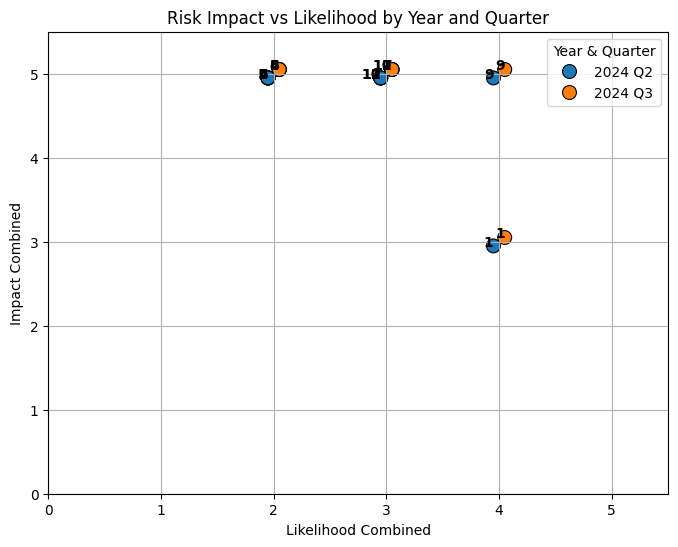

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def scatterplot_risk_historical(df):
    LEGEND_RISK = False

    # Create a new column for the data series label
    df["series"] = df["year"].astype(str) + " Q" + df["quarter"].astype(str)

    # Assign unique numbers to each risk
    risk_mapping = {risk: idx + 1 for idx, risk in enumerate(df["risk"].unique())}
    df["risk_number"] = df["risk"].map(risk_mapping)

    # Offset points slightly to avoid overlap
    offsets = [-0.05, 0.05]
    df["x_adjusted"] = df["likelihood_combined"] + [offsets[i % 2] for i in range(len(df))]
    df["y_adjusted"] = df["impact_combined"] + [offsets[i % 2] for i in range(len(df))]

    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, x="x_adjusted", y="y_adjusted", hue="series", s=100, edgecolor="black"
    )


    # Annotate with numbers instead of series names
    for i, row in df.iterrows():
        plt.text(row["x_adjusted"], row["y_adjusted"], str(row["risk_number"]),
                fontsize=10, ha="right", fontweight="bold")

    # Labels and title
    plt.xlabel("Likelihood Combined")
    plt.ylabel("Impact Combined")
    plt.title("Risk Impact vs Likelihood by Year and Quarter")
    plt.legend(title="Year & Quarter")
    plt.ylim(0, 5.5)
    plt.xlim(0, 5.5)

    if LEGEND_RISK:
        # Add a risk mapping legend
        legend_text = "\n".join([f"{num} = {risk}" for risk, num in risk_mapping.items()])
        plt.figtext(0.15, 0.02, legend_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5})

    # Show plot
    plt.grid(True)
    plt.show()


scatterplot_risk_historical(current_company_df)

# [opt] extract only operational risk

In [32]:
# rmi_data_ops = rmi_data[rmi_data['risk_subcat']=='Operation'] # TODO: if wanna do all category, do rmi_data_ops = rmi_data
rmi_data_ops = df[df['risk_subcat']=='Operation'] # TODO: if wanna do all category, do rmi_data_ops = df

company_names = rmi_data_ops['company'].unique().tolist()
selected_company = company_names[0]
print(selected_company)
list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==selected_company].risk_desc.unique().tolist()
list_of_risk_desc
# list_of_risk_desc = rmi_data_ops.risk_desc.unique().tolist()
# list_of_risk_desc

Chia Tai


['การดำเนินธุรกิจหยุดชะงักหรือได้รับผลกระทบ อันเนื่องมาจากเหตุการณ์วิกฤตต่างๆ ภัยธรรมชาติ (เช่น ไฟไหม้ น้ำท่วม แผ่นดินไหว พายุ) ความไม่สงบทางสังคม (เช่น การจลาจล การก่อการร้าย) วิกฤตทางสาธารณสุข (เช่น โรคระบาดหรืออุบัติใหม่) รวมถึงเหตุการณ์วิกฤตอื่นๆ',
 'ความเสี่ยงจากการเกิดอุบัติของพนักงานและผู้รับเหมาอันเนื่องมาจากการทำงานสภาพแวดล้อมและอุปกรณ์การทำงานไม่ปลอดภัย , อุปกรณ์ PPE ไม่เพียงพอ',
 'การหยุดชะงักของธุรกิจอันเนื่องมาจากภัยพิบัติทางธรรมชาติ, โรคระบาด หรือวิกฤติอื่นที่ทำให้ห่วงโซ่อุปทานหยุดชะงักลง',
 'อุบัติเหตุร้ายแรงจากการปฏิบัติงาน เช่น การขับขี่ การบินโดรน การซ่อมโดรน การติดตั้งโรงเรือน ของพนักงาน คู่ค้า และลูกค้า']

In [33]:
bu_sector = company_details[company_details['BU name']==selected_company]['Business Sector (SET)'].unique().tolist()
bu_sector


[]

In [34]:
company_names[10:11]


['W&W']

# Start Here, 'Gen' analysis

In [35]:
# raise
FORCED_RUN_SINGLE = False # single run (as opposed to multi)
FORCED_RUN = False

## Generate risk report

#### select json report type

In [36]:
# Options:
# 'SINGLE_RISK'
# 'MULTI_RISK_01'
# 'MULTI_RISK_SPLIT_01' # separate risk and control sections
# 'MULTI_RISK_SPLIT_02'
# 'MULTI_RISK_SPLIT_03'

GEN_REPORT = 'MULTI_RISK_SPLIT_03' 

### JSON output setup

#### single risk

In [37]:
from pydantic import BaseModel, Field
from typing import List, Optional
from datetime import date

if GEN_REPORT == 'SINGLE_RISK':
    class ClientQuestions(BaseModel):
        question: str
        rationale: Optional[str] = None  # Why the question is important

    class ExecutiveSummary(BaseModel):
        overview: str
        key_findings: str
        recommendations: str

    class Introduction(BaseModel):
        background: str
        purpose_and_objectives: str

    class RiskIdentification(BaseModel):
        risk_definition: str
        risk_sources: str
        risk_categories: List[str]

    class DetailedRiskAnalysis(BaseModel):
        description: str
        likelihood: str
        impact: str
        current_controls: str
        effectiveness: str

    class RiskAssessment(BaseModel):
        evaluation_criteria: str
        risk_rating_matrix: str
        detailed_risk_analysis: DetailedRiskAnalysis

    class ControlAssessmentAndGaps(BaseModel):
        existing_controls: str
        control_gaps: str
        root_cause_analysis: str

    class RecommendationsForRiskMitigation(BaseModel):
        recommended_controls: str
        cost_benefit_analysis: str
        implementation_timeline: str
        monitoring_strategy: str

    class DetailedActionPlan(BaseModel):
        action_item: str
        objective: str
        responsible_party: str
        timeline: str
        kpis: str
        resources_required: str

    class RiskMitigationActionPlan(BaseModel):
        action_plan_summary: str
        detailed_action_plan: List[DetailedActionPlan]

    class Conclusion(BaseModel):
        summary_of_findings: str
        strategic_implications: str
        next_steps: str

    class Appendices(BaseModel):
        supporting_data: str
        glossary: str
        references: str

    class ReportPreparedBy(BaseModel):
        name: str
        title: str
        date: date

    class RiskAssessmentAnalysisReport(BaseModel):
        executive_summary: ExecutiveSummary
        introduction: Introduction
        risk_identification: RiskIdentification
        risk_assessment: RiskAssessment
        control_assessment_and_gaps: ControlAssessmentAndGaps
        recommendations_for_risk_mitigation: RecommendationsForRiskMitigation
        risk_mitigation_action_plan: RiskMitigationActionPlan
        conclusion: Conclusion
        appendices: Appendices
        # report_prepared_by: ReportPreparedBy
        client_questions: List[ClientQuestions]  # New field for questions to ask the client



#### multi-risk

In [38]:
from pydantic import BaseModel, Field
from typing import List, Optional
from datetime import date

if GEN_REPORT == 'MULTI_RISK_01':
    class ClientQuestions(BaseModel):
        question: str
        rationale: Optional[str] = None  # Why the question is important

    class ExecutiveSummary(BaseModel):
        overview: str
        key_findings: str
        recommendations: str

    class Introduction(BaseModel):
        background: str
        purpose_and_objectives: str

    class RiskIdentification(BaseModel):
        risk_definition: str
        risk_sources: str
        risk_categories: List[str]

    class DetailedRiskAnalysis(BaseModel):
        description: str
        likelihood: str
        impact: str
        current_controls: str
        effectiveness: str

    # class RiskAssessment(BaseModel):
    #     evaluation_criteria: str
    #     risk_rating_matrix: str
    #     detailed_risk_analysis: DetailedRiskAnalysis

    class RiskAssessment(BaseModel):
        risk_identification: RiskIdentification
        evaluation_criteria: str
        risk_rating_matrix: str
        detailed_risk_analysis: DetailedRiskAnalysis

    class ControlAssessmentAndGaps(BaseModel):
        existing_controls: str
        control_gaps: str
        root_cause_analysis: str

    class RecommendationsForRiskMitigation(BaseModel):
        recommended_controls: str
        cost_benefit_analysis: str
        implementation_timeline: str
        monitoring_strategy: str

    class DetailedActionPlan(BaseModel):
        action_item: str
        objective: str
        responsible_party: str
        timeline: str
        kpis: str
        resources_required: str

    class RiskMitigationActionPlan(BaseModel):
        action_plan_summary: str
        detailed_action_plan: List[DetailedActionPlan]

    class Conclusion(BaseModel):
        summary_of_findings: str
        strategic_implications: str
        next_steps: str

    class Appendices(BaseModel):
        supporting_data: str
        glossary: str
        references: str

    class ReportPreparedBy(BaseModel):
        name: str
        title: str
        date: date

    class RiskAssessmentAnalysisReport(BaseModel):
        executive_summary: ExecutiveSummary
        introduction: Introduction
        risks: List[RiskAssessment]  # List of risks
        control_assessment_and_gaps: ControlAssessmentAndGaps
        recommendations_for_risk_mitigation: RecommendationsForRiskMitigation
        risk_mitigation_action_plan: RiskMitigationActionPlan
        conclusion: Conclusion
        appendices: Appendices
        # report_prepared_by: ReportPreparedBy
        client_questions: List[ClientQuestions]

#### multi-risk, split_03
split means gen both risk and control in one go, but user can separate the results

#### multi-risk, v2

In [ ]:
from pydantic import BaseModel
from datetime import date
from typing import List, Optional

# References:
# 2004 COSO ERM - Integrated Framework - Application Techniques.pdf, p.43 (51)
# _COSO Enterprise Risk Management - Integrating with Strategy and Performance.pdf, p.82 (88)

if GEN_REPORT == 'MULTI_RISK_SPLIT_03':
    # ===========  SUMMARY  ===========
    class ExecutiveSummary(BaseModel):
        overview: str
        key_findings: str
        recommendations: str

    class Introduction(BaseModel):
        background: str
        purpose_and_objectives: str

    class Conclusion(BaseModel):
        summary_of_findings: str
        strategic_implications: str
        next_steps: str

    class References(BaseModel):
        reference: str
        link: str

    class Appendices(BaseModel):
        supporting_data: str
        glossary: List[str]
        # references: str
        references: List[References]
        
    class CombinedRisksSummary(BaseModel):
        executive_summary: ExecutiveSummary
        introduction: Introduction
        conclusion: Conclusion
        appendices: Appendices
        # summary_slide_title: str = Field(...,description="action-oriented, insightful, clear, and concise slide title that represents the whole analysis")
        summary_slide_title: str = Field(...,description="clear and concise call to action, based on the whole analysis")

    # ===========  OPPORTUNITY  ===========
    class OpportunityDetail(BaseModel):
        opportunity: str
        impact: str

    class ProjectOpportunity(BaseModel):
        hardware_robotics_and_automation_opportunities: List[OpportunityDetail]
        AI_opportunities: List[OpportunityDetail]

    # ===========  RISK ANALYSIS  ===========
    class ClientQuestions(BaseModel):
        question: str
        rationale: Optional[str] = None  # Why the question is important
    
    class FollowupQuestions(BaseModel):
        question: str
        rationale: Optional[str] = None  # Why the question is important

    class IdentifiedRisk(BaseModel):
        risk_description: str

    class RiskCategory(BaseModel):
        risk_category_name: str
        rationale: str
        # risk_category_applicable_detail: str

    class RiskIdentification(BaseModel):
        # risk_definition: str
        identified_risk: IdentifiedRisk
        risk_sources: List[str]
        risk_categories: List[RiskCategory]
        # risk_categories: List[str]

    # Part 1: Risk Description and Clarification
    class RiskScenarios(BaseModel):
        scenario_description: str = Field(...,description="likely scenario for the given risk")
        potential_impact: str
        KRIs: List[str] # key risk indicators

    # Detailed Risk Analysis now has two main parts
    class DetailedRiskAnalysisReport(BaseModel):
        # risk_clarification: RiskClarification
        # control_assessment: ControlAssessment
        description: str
        risk_owner: str
        potential_scenarios: List[RiskScenarios]
        followup_questions_risk: List[FollowupQuestions]

    # RiskAssessment model now includes the updated DetailedRiskAnalysisReport
    class RiskAssessment(BaseModel):
        risk_identification: RiskIdentification
        # evaluation_criteria: str
        # risk_rating_matrix: str
        detailed_risk_analysis: DetailedRiskAnalysisReport

    # ===========  CONTROL ANALYSIS  ===========
    # Part 2: Control of the Given Risk and Various Scenarios
    class ControlScenarios(BaseModel):
        control_strategy: str
        effectiveness_in_scenarios: List[str]  # Describe effectiveness for each scenario

    class ControlAssessment(BaseModel):
        existing_controls: str
        control_effectiveness: str
        control_gaps: str
        root_cause_analysis: str
        # proposed_controls: List[ControlScenarios]
        # control_scenarios: List[ControlScenarios]

    class RecommendationsForRiskMitigation(BaseModel): # TODO: can combine this with ControlAssessment, but may keep for when combining multiple risks
        recommended_controls: str
        cost_benefit_analysis: str
        implementation_timeline: str
        monitoring_strategy: str
        
    class DetailedActionPlan(BaseModel):
        action_item: str
        objective: str
        cost_benefit_analysis: str
        responsible_party: str
        timeline: str
        kpis: str
        resources_required: str
        estimate_impact_reduction: str
        estimate_likelihood_reduction: str
        effectiveness_in_scenarios: List[str]  # Describe effectiveness for each scenario. 

    class RiskMitigationActionPlan(BaseModel):
        action_plan_summary: str
        monitoring_and_review: List[str]
        detailed_action_plan: List[DetailedActionPlan]

    class SlideTitle(BaseModel):
        slide_title: List[str]

    # Report Option 2: AI-enhanced Analysis (User-input risk a ,jmn89kssessment + AI-gen analysis)
    # Input: company's product, company's risk assessment
    # Date added: 250320
    # TODO: change this
    class RiskAssessmentAnalysisReport_Single(BaseModel):
        risk_analysis: RiskAssessment  # risk analysis
        control_analysis: ControlAssessment
        risk_mitigation_action_plan: RiskMitigationActionPlan
        project_opportunity: ProjectOpportunity
        client_questions: List[ClientQuestions] # additional general questions
        # slide_title: str = Field(...,description="action-oriented, insightful, clear, and concise slide title that represents the whole analysis")
        slide_title: str = Field(...,description="clear and concise key action of the given risk")

### prompt setup

#### choose LLM vendor

In [40]:
# LLM_VENDOR = 'lmstudio' # openai
# MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

LLM_VENDOR = 'openai' # openai
MODEL = "gpt-4.1" # "gpt-4o"



#### risk+control (original)

In [41]:
import json
from textwrap import dedent
from openai import OpenAI
import openai

if LLM_VENDOR == 'openai':
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # MODEL = "gpt-4o-2024-08-06"
    # MODEL = "gpt-4.1" # "gpt-4o"
elif LLM_VENDOR == 'lmstudio':
    client = OpenAI(
        base_url="http://localhost:1234/v1",
        api_key="lm-studio"
    )
    # MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

system_prompt = '''
    You are a world-class risk management consultant working at a world-class risk management consulting company. 
    You are specialized in conducting analysis on client's risk assessment and suggesting holistic control methods to mitigate risks.
    You will be provided with a user input and additional context such as client's risk description and company's business sector.
    Based on the user input and context, write up a comprehensive risk assessment analysis report that should include, but not limited to, several possible scenarios, several questions to ask the client, as well as identifying promising opportunities.
'''

    # Based on the user input, write up a comprehensive risk assessment analysis report.
    # Based on the user input and context, write up a comprehensive risk assessment analysis report that should include, but not limited to, several possible scenarios and several questions to ask the client.

# system_prompt = '''
#     You are a world-class management consultant working at a world-class management consulting company. 
#     You are specialized in conducting analysis on client's risk assessment and suggesting holistic control methods to mitigate risks.
#     You will be provided with a user input such as client's risk description.
#     Based on the user input, write up a comprehensive risk assessment analysis report.
# '''

# You will list at least 3 follow-up questions to help understand the client's risk better.

def get_response(user_input, context):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        # temperature=0,
        messages=[
            {
                "role": "system",
                "content": dedent(system_prompt)
            },
            {
                "role": "user",
                # "content": f"USER INPUT: {user_input}"
                "content": f"CONTEXT: {context}\n USER INPUT: {user_input}"
            }
        ],
        response_format=RiskAssessmentAnalysisReport
        # tools=[
        #     openai.pydantic_function_tool(RiskAssessmentAnalysisReport)  # if using function
        # ]
    )

    return response

# response.choices[0].message.tool_calls

#### risk+control (based on 1 risk data row)

In [42]:
import json
from textwrap import dedent
from openai import OpenAI
import openai

if LLM_VENDOR == 'openai':
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # MODEL = "gpt-4o-2024-08-06"
    # MODEL = "gpt-4o"
elif LLM_VENDOR == 'lmstudio':
    client = OpenAI(
        base_url="http://localhost:1234/v1",
        api_key="lm-studio"
    )
    # MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

system_prompt = '''
    1. You are a world-class risk management consultant working at a world-class risk management consulting company. 
    2. You are specialized in conducting analysis on client's risk assessment.
    3. You are excellent at suggesting comprehensive control methods to mitigate risks.
    4. You will be provided with client's company information (such as their products) and risk assessment (which may include the risk description, control methods, related processes, and any other relevant information).
    5. Based on above information, write up a comprehensive risk assessment analysis report that should include, but not limited to, the following.
    5.1 Risk Analysis: possible scenarios, possible impact, possible root causes, key risk indicators (KRI), follow-up questions to ask the client. Several examples should be included.
    5.2 Control Analysis: monitoring methods, action plans (objective, KPIs, resource required, expected results). Several examples should be included.
    5.3 Promising opportunities. Identify as many opportunities as possible.
'''

    # Based on the user input, write up a comprehensive risk assessment analysis report.
    # Based on the user input and context, write up a comprehensive risk assessment analysis report that should include, but not limited to, several possible scenarios and several questions to ask the client.

# system_prompt = '''
#     You are a world-class management consultant working at a world-class management consulting company. 
#     You are specialized in conducting analysis on client's risk assessment and suggesting holistic control methods to mitigate risks.
#     You will be provided with a user input such as client's risk description.
#     Based on the user input, write up a comprehensive risk assessment analysis report.
# '''

# You will list at least 3 follow-up questions to help understand the client's risk better.

def get_response_riskcontrol(df):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        # temperature=0,
        messages=[
            {
                "role": "system",
                "content": dedent(system_prompt)
            },
            {
                "role": "user",
                # "content": f"USER INPUT: {user_input}"
                "content": f'''COMPANY'S PRODUCTS: {df['company_product']}\n 
                            RISK: {df['risk']}\n 
                            RISK DESCRIPTION: {df['risk_desc']}\n
                            CONTROL METHOD: {df['control_name']}\n
                            CONTROL DESCRIPTION: {df['control_des']}'''
            }
        ],
        response_format=RiskAssessmentAnalysisReport_Single
        # tools=[
        #     openai.pydantic_function_tool(RiskAssessmentAnalysisReport)  # if using function
        # ]
    )

    return response

# response.choices[0].message.tool_calls

#### opportunity

In [43]:
## TODO: revise and test this
import json
from textwrap import dedent
from openai import OpenAI
import openai

if LLM_VENDOR == 'openai':
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # MODEL = "gpt-4o-2024-08-06"
    # MODEL = "gpt-4o"
elif LLM_VENDOR == 'lmstudio':
    client = OpenAI(
        base_url="http://localhost:1234/v1",
        api_key="lm-studio"
    )
    # MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

system_opp_prompt = '''
    You are a world-class risk management consultant working at a world-class risk management consulting company. 
    You are specialized in conducting analysis on client's risk assessment and identifying opportunities.
    You will be provided with a user input and additional context such as client's risk description and company's business sector.
    Based on the user input and context, write up a comprehensive assessment in identifying promising opportunities. Provide as many details as possible.
'''

    # Based on the user input, write up a comprehensive risk assessment analysis report.
    # Based on the user input and context, write up a comprehensive risk assessment analysis report that should include, but not limited to, several possible scenarios and several questions to ask the client.

# system_prompt = '''
#     You are a world-class management consultant working at a world-class management consulting company. 
#     You are specialized in conducting analysis on client's risk assessment and suggesting holistic control methods to mitigate risks.
#     You will be provided with a user input such as client's risk description.
#     Based on the user input, write up a comprehensive risk assessment analysis report.
# '''

# You will list at least 3 follow-up questions to help understand the client's risk better.

def get_response_opportunity(user_input, context):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        # temperature=0,
        messages=[
            {
                "role": "system",
                "content": dedent(system_opp_prompt)
            },
            {
                "role": "user",
                # "content": f"USER INPUT: {user_input}"
                "content": f"CONTEXT: {context}\n USER INPUT: {user_input}"
            }
        ],
        response_format=ProjectOpportunity
        # tools=[
        #     openai.pydantic_function_tool(RiskAssessmentAnalysisReport)  # if using function
        # ]
    )

    return response


#### summary, intro, conclusion

In [44]:
## TODO: revise and test this
import json
from textwrap import dedent
from openai import OpenAI
import openai

if LLM_VENDOR == 'openai':
    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
    # MODEL = "gpt-4o-2024-08-06"
    # MODEL = "gpt-4o"
elif LLM_VENDOR == 'lmstudio':
    client = OpenAI(
        base_url="http://localhost:1234/v1",
        api_key="lm-studio"
    )
    # MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

system_sum_prompt = '''
    You are a world-class risk management consultant working at a world-class risk management consulting company. 
    You are specialized in conducting analysis on client's risk assessment and identifying opportunities.
    You will be provided with a user input and additional context such as a list of client's risks description and company's business sector.
    Based on the user input and context, write up a comprehensive executive summary, introduction, conclusion, and appendices. Provide as many details as possible.
'''

    # Based on the user input, write up a comprehensive risk assessment analysis report.
    # Based on the user input and context, write up a comprehensive risk assessment analysis report that should include, but not limited to, several possible scenarios and several questions to ask the client.

# system_prompt = '''
#     You are a world-class management consultant working at a world-class management consulting company. 
#     You are specialized in conducting analysis on client's risk assessment and suggesting holistic control methods to mitigate risks.
#     You will be provided with a user input such as client's risk description.
#     Based on the user input, write up a comprehensive risk assessment analysis report.
# '''

# You will list at least 3 follow-up questions to help understand the client's risk better.

def get_response_summary(user_input, context):
    response = client.beta.chat.completions.parse(
        model=MODEL,
        # temperature=0,
        messages=[
            {
                "role": "system",
                "content": dedent(system_sum_prompt)
            },
            {
                "role": "user",
                # "content": f"USER INPUT: {user_input}"
                "content": f"CONTEXT: {context}\n USER INPUT: {user_input}"
            }
        ],
        response_format=CombinedRisksSummary
        # tools=[
        #     openai.pydantic_function_tool(RiskAssessmentAnalysisReport)  # if using function
        # ]
    )

    return response


#### summarize risk_desc texts

In [45]:
## TODO: revise and test this
import json
from textwrap import dedent
from openai import OpenAI
import openai

# if LLM_VENDOR == 'openai':
#     client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
#     # MODEL = "gpt-4o-2024-08-06"
#     # MODEL = "gpt-4o-mini"
#     # MODEL = "gpt-4.1-nano"
# elif LLM_VENDOR == 'lmstudio':
#     client = OpenAI(
#         base_url="http://localhost:1234/v1",
#         api_key="lm-studio"
#     )
#     # MODEL = "lmstudio-community/qwen2.5-7b-instruct-1m"

# system_sumtext_prompt = '''
#     Summarize the following data, so it's concise without losing any meaning.
# '''

# def get_response_sumtext(user_input_data):
#     response = client.beta.chat.completions.parse(
#         model=MODEL,
#         # temperature=0,
#         messages=[
#             {
#                 "role": "system",
#                 "content": dedent(system_sumtext_prompt)
#             },
#             {
#                 "role": "user",
#                 # "content": f"USER INPUT: {user_input}"
#                 "content": f"DATA: {user_input_data}"
#             }
#         ],
#         # response_format=CombinedRisksSummary
#         # tools=[
#         #     openai.pydantic_function_tool(RiskAssessmentAnalysisReport)  # if using function
#         # ]
#     )

#     return response

def summarize_text(text: str) -> str:
    """
    Summarize the given text using OpenAI's API.
    
    Parameters:
        text (str): The text to summarize.
        api_key (str): OpenAI API key.
    
    Returns:
        str: Summarized text.
    """
    
    prompt = f"Summarize the following data in the original language, so it's concise without losing any meaning:\n\n{text}"
    
    response = client.chat.completions.create(
        # model="gpt-4o-mini", # gpt-4o-mini
        # model='gpt-4.1-nano',
        model='gpt-4.1-mini',
        messages=[
            {"role": "system", "content": "You are a professional data analyst."},
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message.content.strip()


In [46]:
# data = f'''{'การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเสียง และความเสียหายทางธุรกิจ', 'สินค้าที่ขายไม่เป็นไปตามมาตรฐาน ส่งผลให้ลูกค้าร้องเรียน', 'เม็ดอาหารที่ผลิตออกมาไม่ได้คุณภาพตามมาตรฐานที่กำหนด ซึ่งส่งผลกระทบต่อบริษัทและความต้องการของลูกค้า', 'ผลิตภัณฑ์ในกระบวนการบรรจุไม่เป็นไปตามมาตรฐาน ส่งผลให้เกิดความไม่พึงพอใจของลูกค้า เกิดข้อร้องเรียนหรือการสูญเสียทางธุรกิจ', 'สินค้าบริษัทไม่เป็นไปตามมาตรฐาน ส่งผลให้เกิดความเสี่ยงด้านความไม่พอใจ ร้องเรียน หรือการสูญเสียทางธุรกิจ'}'''
# response = get_response_sumtext(data)
# display(response.choices[0].message.content)

In [47]:
# data = '''{'การตรวจสอบคุณภาพวัตถุดิบและผลิตภัณฑ์ทุกขั้นตอน, การจัดทำมาตรฐานการดำเนินงาน (SOP) สำหรับกระบวนการผลิต การตรวจสอบคุณภาพวัตถุดิบและผลิตภัณฑ์ทุกขั้นตอน, การจัดทำมาตรฐานการดำเนินงาน (SOP) สำหรับกระบวนการผลิต', '1) วิเคราะห์หาสาเหตุเมื่อพบปัญหาคุณภาพโดยแผนกผลิต และแผนกคุณภาพ 2) อบรมพนักงานกรณีปัญหานั้นมีที่มาจากความรู้ของพนักงานเอง และกำหนดมาตรฐานคุณภาพเพิ่มเติม 3) จัดหาวิธีการหรือเครื่องมือที่สามารถป้องกันการผิดพลาดของพนักงาน', 'ให้พนักงาน หัวหน้างานทวนสอบการทำงานทุกวันเพื่อตรวจสอบความผิดพลาดที่อาจเกิดขึ้น', 'ตรวจสอบความพร้อมของเครื่องจักรก่อนการผลิตทุกครั้ง'}'''
# sumtext = summarize_text(data)
# display(sumtext)

### gen report data, single run

#### risk and control

In [48]:
if FORCED_RUN_SINGLE:
    try:
        response = get_response(list_of_risk_desc[1],bu_sector)
        # response = get_response(list_of_risk_desc,bu_sector) # multi-risks

        response_ = response.choices[0].message
        if response_.parsed:
            print('success')
            print(response_.parsed)
        elif response_.refusal:
            # handle refusal
            print('refusal')
            print(response_.refusal)
    except Exception as e:
        print('error')
        # Handle edge cases
        if type(e) == openai.LengthFinishReasonError:
            # Retry with a higher max tokens
            print("Too many tokens: ", e)
            pass
        else:
            # Handle other exceptions
            print(e)
            pass

In [49]:
# tmp_res_single = response.choices[0].message.content
# usage_count_single = response.usage
# report_json_single = json.loads(tmp_res_single)
# report_json_single

#### opportunity

In [50]:
if FORCED_RUN_SINGLE:
    try:
        response_opportunity = get_response_opportunity(list_of_risk_desc[1],bu_sector)
        # response = get_response(list_of_risk_desc,bu_sector) # multi-risks

        response_ = response_opportunity.choices[0].message
        if response_.parsed:
            print('success')
            print(response_.parsed)
        elif response_.refusal:
            # handle refusal
            print('refusal')
            print(response_.refusal)
    except Exception as e:
        print('error')
        # Handle edge cases
        if type(e) == openai.LengthFinishReasonError:
            # Retry with a higher max tokens
            print("Too many tokens: ", e)
            pass
        else:
            # Handle other exceptions
            print(e)
            pass

In [51]:
# tmp_res_opp = response_opportunity.choices[0].message.content
# usage_count_opp = response_opportunity.usage
# report_json_opp = json.loads(tmp_res_opp)
# report_json_opp

In [52]:
# estimate_cost(response_opportunity.usage)

#### summary, intro, conclusion

In [53]:
if FORCED_RUN_SINGLE:
    try:
        response_summary = get_response_summary(list_of_risk_desc,bu_sector)
        # response = get_response(list_of_risk_desc,bu_sector) # multi-risks

        response_ = response_summary.choices[0].message
        if response_.parsed:
            print('success')
            print(response_.parsed)
        elif response_.refusal:
            # handle refusal
            print('refusal')
            print(response_.refusal)
    except Exception as e:
        print('error')
        # Handle edge cases
        if type(e) == openai.LengthFinishReasonError:
            # Retry with a higher max tokens
            print("Too many tokens: ", e)
            pass
        else:
            # Handle other exceptions
            print(e)
            pass

In [54]:
if FORCED_RUN_SINGLE:
    tmp_res_summary = response_summary.choices[0].message.content
    usage_count_summary = response_summary.usage
    report_json_summary = json.loads(tmp_res_summary)
    report_json_summary

### gen report data, multi runs

#### openai estimated cost

In [ ]:
def estimate_cost_v0(res_usage, model='gpt-4o', type = 'single'):
    # gpt-4o-2024-08-06, https://openai.com/api/pricing/
    if model == 'gpt-4o':
        INPUT_RATE = 2.5
        OUTPUT_RATE = 10
    elif model == 'gpt-4.1':
        INPUT_RATE = 2.0
        OUTPUT_RATE = 8.0
    elif model == 'gpt-4.1-mini':
        INPUT_RATE = .4
        OUTPUT_RATE = 1.6
    elif model == 'gpt-4o-mini':
        INPUT_RATE = .15
        OUTPUT_RATE = .6
    elif model == 'gpt-o3-mini':
        INPUT_RATE = 1.1
        OUTPUT_RATE = 4.4

    if type == 'multi':
        total_prompt_tokens = sum(item.prompt_tokens for item in res_usage)
        total_completion_tokens = sum(item.completion_tokens for item in res_usage)
        input_cost = INPUT_RATE*total_prompt_tokens/1000000.0
        output_cost = OUTPUT_RATE*total_completion_tokens/1000000.0
    else:
        input_cost = INPUT_RATE*res_usage.prompt_tokens/1000000.0
        output_cost = OUTPUT_RATE*res_usage.completion_tokens/1000000.0

    total_cost = input_cost + output_cost
    total_cost_THB = total_cost*35 # 35 THB/USD
    print('total cost (THB): ' + str(total_cost_THB))
    return total_cost_THB

# example 1
# estimate_cost(res_usage = usage_count_list,type='multi',model='gpt-4o-mini')

# example 2, use default value of 'single' run and '4o' model
# estimate_cost(res_usage = response.usage)
# estimate_cost(response.usage)

In [147]:
# this can do cumulative cost
# static variable in a function, see https://stackoverflow.com/questions/279561/what-is-the-python-equivalent-of-static-variables-inside-a-function
def estimate_cost(res_usage, model='gpt-4o', type = 'single',showcost=False):
    # gpt-4o-2024-08-06, https://openai.com/api/pricing/
    if model == 'gpt-4o':
        INPUT_RATE = 2.5
        OUTPUT_RATE = 10
    elif model == 'gpt-4.1':
        INPUT_RATE = 2.0
        OUTPUT_RATE = 8.0
    elif model == 'gpt-4.1-mini':
        INPUT_RATE = .4
        OUTPUT_RATE = 1.6
    elif model == 'gpt-4.1-nano':
        INPUT_RATE = .1
        OUTPUT_RATE = 0.4
    elif model == 'gpt-4o-mini':
        INPUT_RATE = .15
        OUTPUT_RATE = .6
    elif model == 'gpt-o3-mini':
        INPUT_RATE = 1.1
        OUTPUT_RATE = 4.4
        
    if type == 'multi':
        total_prompt_tokens = sum(item.prompt_tokens for item in res_usage)
        total_completion_tokens = sum(item.completion_tokens for item in res_usage)
        input_cost = INPUT_RATE*total_prompt_tokens/1000000.0
        output_cost = OUTPUT_RATE*total_completion_tokens/1000000.0
    else:
        input_cost = INPUT_RATE*res_usage.prompt_tokens/1000000.0
        output_cost = OUTPUT_RATE*res_usage.completion_tokens/1000000.0

    total_cost = input_cost + output_cost
    total_cost_THB = total_cost*35 # 35 THB/USD
    estimate_cost.total_cost_THB += total_cost_THB
    # openaicall_total_cost_THB += total_cost_THB

    if showcost:
        print('single call cost (THB): ' + str(total_cost_THB))
        # print('cumulative total cost (THB): ' + str(total_cost_THB))

    return total_cost_THB # cost per call (as opposed to cumulative cost)

# example 1
# estimate_cost.total_cost_THB = 0 # initialization
# estimate_cost(res_usage = usage_count_list,type='multi',model='gpt-4o-mini')

# example 2, use default value of 'single' run and '4o' model
# estimate_cost(res_usage = response.usage)
# estimate_cost(response.usage)

In [ ]:
class res_usage():
    def __init__(self):
        self.prompt_tokens = 10
        self.completion_tokens = 10
    
res_usage = res_usage()
display(res_usage.prompt_tokens)

estimate_cost.total_cost_THB = 0 # initialization
# estimate_cost(res_usage)
# estimate_cost(res_usage)
estimate_cost(res_usage,showcost=True)
print(estimate_cost.total_cost_THB)
estimate_cost(res_usage,showcost=True)
print(estimate_cost.total_cost_THB) # have to use this to access the static variable


10

single call cost (THB): 0.004375
0.004375
single call cost (THB): 0.004375
0.00875


In [138]:
def foo(x):
    foo.counter += x
    print('Counter is ' + str(foo.counter))
foo.counter = 0
foo(2)
print(foo.counter)
foo(3)
print(foo.counter)


Counter is 2
2
Counter is 5
5


In [56]:
# company_names = rmi_data_ops['company'].unique().tolist()
# print(company_names)


#### V1: risk+control, opportunity, summary

In [57]:
import json
import os

# FORCED_RUN = True

# if FORCED_RUN:
def gen_data(GEN_DATA, SOURCE, company, bu_desc, selected_risklist):
    # #  TODO: config these
    # GEN_DATA = 'opportunity' # 'riskcontrol' 'opportunity' 'summary'
    # SOURCE = 'RMI' # 'RMI' '56'

    # # Path to your JSON file
    # # file_path = './output/report_json/gen_from_rmi_' + + '.json'
    # company_names = rmi_data_ops['company'].unique().tolist()
    # selected_company = company_names[10:11] # TODO: choose the company you wanna gen the data

    # df_list = []
    # usage_count_list = []

    # for company in selected_company:
    #     print('current company: ' + company)
    #     company_ = company.replace(' ','_')

    #     bu_sector_list = company_details[company_details['BU name']==company]['Business Sector (SET)'].unique().tolist()
    #     if bu_sector_list:
    #         print('current bu_sector: ' + str(bu_sector_list))
    #         selected_bu_sector = bu_sector_list[0:1] # TODO: currently, only use just the first sector, need to loop this if want all sectors
    #         # selected_bu_sector = bu_sector_list # TODO: if use all sectors
    #     else:
    #         print('no bu sector to match')
    #         break

    #     for bu_desc in selected_bu_sector:
    usage_count_list = []
    company_ = company.replace(' ','_')
    bu_desc_ = bu_desc.replace(' ','_')

    file_path = GEN_DATA + '_' + SOURCE + '_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
    file_path = external_data_folder + 'report_json/' + file_path

    # Check if the file exists and is not empty
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Open the file and load existing data
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        # If the file doesn't exist or is empty, start with an empty list or dictionary
        data = []

    if SOURCE == 'RMI':
        # current_list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist()
        current_list_of_risk_desc = selected_risklist
    if SOURCE == '56': # TODO: change this to reflect 56-1 A-B, risk_in_sector_not_in_company
        # current_list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist() 
        top5 = topN_risk_in_sector_not_in_company(df_56,company,bu_desc, 5)
        current_list_of_risk_desc = top5['risk_sub_category'].unique().tolist() # currently use risk_sub_cat, not topic_name (which is equi of risk_desc)
        # print(current_list_of_risk_desc)

    # TODO: test this piece of code, maybe wrap it in a function?, I think this is done
    if GEN_DATA == 'summary':
        try:
            print('summary of ' + str(current_list_of_risk_desc))
            response = get_response_summary(current_list_of_risk_desc,bu_desc)
            response_ = response.choices[0].message
            if response_.parsed:
                print('success')
                print(response_.parsed)
            elif response_.refusal:
                # handle refusal
                print('refusal')
                print(response_.refusal)

            tmp_res = response.choices[0].message.content
            usage_count = response.usage
            report_json = []
            report_json = json.loads(tmp_res)
            report_json['company'] = company
            report_json['bu_sector'] = bu_desc
            report_json['risk_desc'] = current_list_of_risk_desc
            # Append new data
            data.append(report_json)
            usage_count_list.append(usage_count)            

        except Exception as e:
            print('error')
            # Handle edge cases
            if type(e) == openai.LengthFinishReasonError:
                # Retry with a higher max tokens
                print("Too many tokens: ", e)
                pass
            else:
                # Handle other exceptions
                print(e)
                pass
    else:
        for risk_desc in current_list_of_risk_desc:
            try:
                if GEN_DATA == 'riskcontrol':
                    print('risk_desc: ' + risk_desc + ', bu desc: ' + bu_desc)
                    # response = get_response_riskcontrol()
                    response = get_response(risk_desc, bu_desc)
                if GEN_DATA == 'opportunity':
                    response = get_response_opportunity(risk_desc, bu_desc)
                # response = get_response(list_of_risk_desc,bu_sector) # multi-risks

                response_ = response.choices[0].message
                if response_.parsed:
                    print('success')
                    print(response_.parsed)
                elif response_.refusal:
                    # handle refusal
                    print('refusal')
                    print(response_.refusal)

                tmp_res = response.choices[0].message.content
                usage_count = response.usage
                report_json = []
                report_json = json.loads(tmp_res)
                report_json['company'] = company
                report_json['bu_sector'] = bu_desc
                report_json['risk_desc'] = risk_desc

                # Append new data
                data.append(report_json)

                # # Create an instance of RiskControlList
                # risk_control_list = RiskControlList(**report_json)

                # # Convert to DataFrame
                # df = pd.DataFrame([control.model_dump() for control in risk_control_list.riskcontrol])

                # df_list.append(df)
                usage_count_list.append(usage_count)            

            except Exception as e:
                print('error')
                # Handle edge cases
                if type(e) == openai.LengthFinishReasonError:
                    # Retry with a higher max tokens
                    print("Too many tokens: ", e)
                    pass
                else:
                    # Handle other exceptions
                    print(e)
                    pass

    # estimate_cost(res_usage = usage_count_list,type='multi',model='4.1')
    estimate_cost(res_usage = usage_count_list,type='multi',model=MODEL)
    
    # TODO: check if this one needs to be indented 
    # Write the updated data back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

    print(f"Data appended to {file_path}")

    # result_all = pd.concat(df_list, ignore_index=True)
    # result_all


#### V2: risk+control, opportunity, summary

In [58]:
import json
import os

# FORCED_RUN = True

# if FORCED_RUN:
# def gen_data_v2(GEN_DATA, SOURCE, company, bu_desc, selected_risklist):
def gen_data_v2(GEN_DATA, SOURCE, company, bu_desc, df, file_path):
    selected_risklist = df['risk_desc'].tolist()
    
    usage_count_list = []
    company_ = company.replace(' ','_')
    bu_desc_ = bu_desc.replace(' ','_')

    # file_path = GEN_DATA + '_' + SOURCE + '_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
    # file_path = external_data_folder + 'report_json/' + file_path

    # Check if the file exists and is not empty
    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        # Open the file and load existing data
        with open(file_path, 'r') as file:
            data = json.load(file)
    else:
        # If the file doesn't exist or is empty, start with an empty list or dictionary
        data = []

    if SOURCE == 'RMI':
        # current_list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist()
        current_list_of_risk_desc = selected_risklist
    if SOURCE == '56': # TODO: change this to reflect 56-1 A-B, risk_in_sector_not_in_company
        # current_list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist() 
        top5 = topN_risk_in_sector_not_in_company(df_56,company,bu_desc, 5)
        current_list_of_risk_desc = top5['risk_sub_category'].unique().tolist() # currently use risk_sub_cat, not topic_name (which is equi of risk_desc)
        # print(current_list_of_risk_desc)

    # TODO: test this piece of code, maybe wrap it in a function?, I think this is done
    if GEN_DATA == 'summary':
        try:
            print('summary of ' + str(current_list_of_risk_desc))
            response = get_response_summary(current_list_of_risk_desc,bu_desc)
            response_ = response.choices[0].message
            if response_.parsed:
                print('success')
                print(response_.parsed)
            elif response_.refusal:
                # handle refusal
                print('refusal')
                print(response_.refusal)

            tmp_res = response.choices[0].message.content
            usage_count = response.usage
            report_json = []
            report_json = json.loads(tmp_res)
            report_json['company'] = company
            report_json['bu_sector'] = bu_desc
            report_json['risk_desc'] = str(current_list_of_risk_desc)
            # Append new data
            data.append(report_json)
            usage_count_list.append(usage_count)            

        except Exception as e:
            print('error')
            # Handle edge cases
            if type(e) == openai.LengthFinishReasonError:
                # Retry with a higher max tokens
                print("Too many tokens: ", e)
                pass
            else:
                # Handle other exceptions
                print(e)
                pass
    else:
        # for risk_desc in current_list_of_risk_desc:
        for i, row in df.iterrows():
            risk_desc = str(row['risk_desc'])
            # user-input dat
            risk_name = str(row['risk'])
            # risk_desc = str(row['risk_desc'])
            control_name = str(row['control_name'])
            control_desc = str(row['control_des'])
            KRI_name = str(row['KRI_name'])
            KRI_desc = str(row['KRI_desc'])
            try:
                if GEN_DATA == 'riskcontrol':
                    print('risk_desc: ' + risk_desc + ', bu desc: ' + bu_desc)
                    response = get_response_riskcontrol(df)
                    # response = get_response(risk_desc, bu_desc)
                if GEN_DATA == 'opportunity':
                    response = get_response_opportunity(risk_desc, bu_desc)
                # response = get_response(list_of_risk_desc,bu_sector) # multi-risks

                response_ = response.choices[0].message
                if response_.parsed:
                    print('success')
                    print(response_.parsed)
                elif response_.refusal:
                    # handle refusal
                    print('refusal')
                    print(response_.refusal)

                tmp_res = response.choices[0].message.content
                usage_count = response.usage
                report_json = []
                report_json = json.loads(tmp_res)
                # display('report json: ')
                # display(report_json)

                # TODO: consolidate all user-input data, have 2 sections: raw, ai_processed
                # ===== USER-INPUT DATA =====
                # display('user_input_data_raw start')
                user_input_data_raw = {
                    'company': company,
                    'bu_sector': bu_desc,
                    'risk_name': risk_name,
                    'risk_desc': risk_desc,
                    'control_name': control_name,
                    'control_desc': control_desc,
                    'KRI_name': KRI_name,
                    'KRI_desc': KRI_desc
                }
                report_json['user_input_raw'] = user_input_data_raw
                # display('user_input_data_raw end')

                # display('user_input_data_ai start')
                user_input_data_ai = {
                    'company': company,
                    'bu_sector': bu_desc,
                    'risk_name': risk_name,
                    'risk_desc': summarize_text(risk_desc),
                    'control_name': summarize_text(control_name),
                    'control_desc': summarize_text(control_desc),
                    'KRI_name': summarize_text(KRI_name),
                    'KRI_desc': summarize_text(KRI_desc)
                }
                report_json['user_input_ai'] = user_input_data_ai
                # display('user_input_data_ai end')

                # report_json['company'] = company
                # report_json['bu_sector'] = bu_desc
                # report_json['risk_name'] = risk_name
                # report_json['risk_desc'] = risk_desc
                # report_json['control_name'] = control_name
                # report_json['control_desc'] = control_desc
                # report_json['KRI_name'] = KRI_name
                # report_json['KRI_desc'] = KRI_desc

                # Append new data
                data.append(report_json)

                # # Create an instance of RiskControlList
                # risk_control_list = RiskControlList(**report_json)

                # # Convert to DataFrame
                # df = pd.DataFrame([control.model_dump() for control in risk_control_list.riskcontrol])

                # df_list.append(df)
                usage_count_list.append(usage_count)            

            except Exception as e:
                print('error')
                # Handle edge cases
                if type(e) == openai.LengthFinishReasonError:
                    # Retry with a higher max tokens
                    print("Too many tokens: ", e)
                    pass
                else:
                    # Handle other exceptions
                    print(e)
                    pass

    # estimate_cost(res_usage = usage_count_list,type='multi',model='4.1')
    estimate_cost(res_usage = usage_count_list,type='multi',model=MODEL)
    
    # TODO: check if this one needs to be indented 
    # Write the updated data back to the file
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

    print(f"Data appended to {file_path}")

    # result_all = pd.concat(df_list, ignore_index=True)
    # result_all


In [59]:
if FORCED_RUN:
    class CompletionUsage:
        def __init__(self, completion_tokens, prompt_tokens, total_tokens):
            self.completion_tokens = completion_tokens
            self.prompt_tokens = prompt_tokens
            self.total_tokens = total_tokens

    # Convert the list of CompletionUsage objects to a list of dictionaries
    usage_dicts = [
        {'completion_tokens': u.completion_tokens, 'prompt_tokens': u.prompt_tokens, 'total_tokens': u.total_tokens}
        for u in usage_count_list
    ]

    # Create the DataFrame
    usage_all = pd.DataFrame(usage_dicts)

    usage_all
    # usage_all.prompt_tokens.sum()

    # estimate cost, assume gpt-3.5-turbo-0125, https://openai.com/api/pricing/
    # gpt-4o-2024-08-06, https://openai.com/api/pricing/
    input_cost = 2.5*usage_all.prompt_tokens.sum()/1000000.0
    output_cost = 10.0*usage_all.completion_tokens.sum()/1000000.0

    total_cost = input_cost + output_cost
    total_cost_THB = total_cost*35 # 38 THB/USD
    print('total cost (THB): ' + str(total_cost_THB))


In [60]:
# response_

In [61]:
# estimate_cost(response.usage)

### extract only json results from gpt response

In [62]:
# tmp_res = response.choices[0].message.content

# # tmp_res = response.choices[0].message.tool_calls[0].function.arguments # if using function
# report_json = json.loads(tmp_res) # python dict
# report_json

In [63]:
# report_json['client_questions']

In [64]:
# estimate_cost(response.usage)

### generic doc writing functions

In [65]:
from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.style import WD_STYLE_TYPE
from typing import List
from pydantic import BaseModel, Field
from docx.shared import Pt, Cm, RGBColor
from docx.oxml.ns import nsdecls, qn
from docx.oxml import parse_xml, OxmlElement

def add_toc_placeholder(paragraph):
    """Adds a TOC field to the paragraph."""
    # Create field begin element
    fldChar_begin = OxmlElement('w:fldChar')
    fldChar_begin.set(qn('w:fldCharType'), 'begin')

    # Create field instructions (TOC field)
    instrText = OxmlElement('w:instrText')
    instrText.set(qn('xml:space'), 'preserve')
    instrText.text = 'TOC \\o "1-3" \\h \\z \\u'

    # Create field separator
    fldChar_separate = OxmlElement('w:fldChar')
    fldChar_separate.set(qn('w:fldCharType'), 'separate')

    # Create field end element
    fldChar_end = OxmlElement('w:fldChar')
    fldChar_end.set(qn('w:fldCharType'), 'end')

    # Add elements in the right order
    paragraph._element.append(fldChar_begin)
    paragraph._element.append(instrText)
    paragraph._element.append(fldChar_separate)
    paragraph._element.append(fldChar_end)

def set_cell_margins(cell, top=0, start=0, bottom=0, end=0):
    """
    Set cell margins in twips (twentieths of a point).
    """
    tc = cell._element
    tcPr = tc.get_or_add_tcPr()
    
    for margin_name, margin_value in (("top", top), ("start", start), ("bottom", bottom), ("end", end)):
        if margin_value:
            margin_element = OxmlElement(f'w:{margin_name}')
            margin_element.set('w:w', str(int(margin_value)))
            margin_element.set('w:type', 'dxa')
            tcPr.append(margin_element)

def add_bulleted_list(doc: Document, items: list):
    for item in items:
        doc.add_paragraph(item, style='List Bullet')

def add_numbered_list(doc: Document, items: list):
    for item in items:
        doc.add_paragraph(item, style='List Number')

def add_bulleted_list_with_values(doc: Document, data: list):
    for item in data:
        # Combine all values in the dictionary into one string, separated by ':'
        line = ': '.join(item.values())
        # Add the line to the document as a bullet point
        doc.add_paragraph(line, style='List Bullet')

def add_item_list_newline(doc: Document, items: list):
    # print(items)
    for item in items:
        doc.add_paragraph(item)

def add_numbered_questions_with_rationale(doc: Document, data: list):
    """
    Adds a numbered list of questions with rationales to the provided Document object.

    Each entry will be formatted as:
    1. What are the primary reasons employees cite for leaving the company?
       [Rationale: Understanding employee exit motivations can help address root causes and inform retention strategies.]
    """
    # Define a custom style for the rationale
    styles = doc.styles
    if "RationaleStyle" not in styles:
        rationale_style = styles.add_style("RationaleStyle", WD_STYLE_TYPE.PARAGRAPH)
        rationale_font = rationale_style.font
        rationale_font.size = Pt(10)
        rationale_font.italic = True
        rationale_font.color.rgb = RGBColor(100, 100, 100)  # Optional: Gray color

    for item_number, item in enumerate(data):
        question = item.get("question", "")
        rationale = item.get("rationale", "")

        # Create a numbered list item as a string
        numbered_item = f"{item_number+1}. {question}"
        doc.add_paragraph(numbered_item)
        # Add the rationale as a separate paragraph with the custom style
        doc.add_paragraph(  # Add the rationale as a separate paragraph
            f"[Rationale: {rationale}]", style="RationaleStyle"
        )
        
def list_to_table(doc: Document, data: list):
    # Determine the number of columns based on the first dictionary
    num_columns = len(data[0])
    # Add a table with the number of rows equal to len(data) + 1 (for the header)
    table = doc.add_table(rows=len(data) + 1, cols=num_columns)
    table.style = 'Table Grid'

    # Add the header row
    header_cells = table.rows[0].cells
    headers = list(data[0].keys())
    for i, header in enumerate(headers):
        # header_cells[i].text = header.replace('_', ' ').title()

        headertext = header.replace('_', ' ').title()
        if headertext == 'Kris':
            headertext = 'KRIs'
        cell = header_cells[i]
        # Clear any existing paragraphs in the cell (if you need full control)
        cell.clear_content = True
        paragraph = cell.paragraphs[0]
        # Add the text with bold formatting
        run = paragraph.add_run(headertext)
        run.bold = True
        
        # headertext = header.replace('_', ' ').title()
        # # Add the text with bold formatting
        # run = header_cells[i].paragraph[0].add_run(headertext)
        # run.bold = True

    # Add the data rows
    for row_idx, item in enumerate(data, start=1):
        row_cells = table.rows[row_idx].cells
        for col_idx, key in enumerate(headers):
            row_cells[col_idx].text = item[key]

            for paragraph in row_cells[col_idx].paragraphs:
                paragraph.paragraph_format.space_before = Pt(6)
                paragraph.paragraph_format.space_after = Pt(6)
                paragraph.paragraph_format.line_spacing = Pt(12)  # Line spacing for readability

def list_to_table_vertical(doc: Document, data: list):
    # Determine the number of columns based on the first dictionary
    num_rows = len(data)
    # Add a table with the number of rows equal to len(data) + 1 (for the header)
    # table = doc.add_table(rows=len(data) + 1, cols=num_columns)
    table = doc.add_table(rows=num_rows, cols=2)
    table.style = 'Table Grid'

    # Add the header columns
    header_cells = table.columns[0].cells
    headers = list(data.keys())
    for i, header in enumerate(headers):
        # header_cells[i].text = header.replace('_', ' ').title()

        headertext = header.replace('_', ' ').title()
        if headertext == 'Kpis':
            headertext = 'KPIs'
        if headertext == 'Effectiveness In Scenarios':
            headertext = '(if effective)'
        cell = header_cells[i]
        # Clear any existing paragraphs in the cell (if you need full control)
        cell.clear_content = True
        paragraph = cell.paragraphs[0]
        # Add the text with bold formatting
        run = paragraph.add_run(headertext)
        run.bold = True
        
        # headertext = header.replace('_', ' ').title()
        # # Add the text with bold formatting
        # run = header_cells[i].paragraph[0].add_run(headertext)
        # run.bold = True

    # Add the data rows
    # print(data)
    # for row_idx, item in enumerate(data):
    #     print(row_idx)
    #     print(item)

    row_cells = table.columns[1].cells
    for col_idx, key in enumerate(headers):
        # print(col_idx)
        # print(key)
        # row_cells[col_idx].text = data[key]
        if key == 'effectiveness_in_scenarios':
            print(row_cells[col_idx].paragraphs[-1].text)
            # Remove the last paragraph if it's empty
            if not row_cells[col_idx].paragraphs[-1].text.strip():
                p = row_cells[col_idx].paragraphs[-1]._element
                p.getparent().remove(p)
                
            for item in data[key]:
                # row_cells[col_idx].add_paragraph(item)
                # print(item)
                row_cells[col_idx].add_paragraph(item, style='List Bullet')
                
                
        else:
            row_cells[col_idx].text = data[key]

        for paragraph in row_cells[col_idx].paragraphs:
            paragraph.paragraph_format.space_before = Pt(6)
            paragraph.paragraph_format.space_after = Pt(6)
            paragraph.paragraph_format.line_spacing = Pt(12)  # Line spacing for readability


### report layout, risk-only 

#### single risk

In [66]:
# from docx import Document
# from typing import List, Dict, Any
# from pydantic import BaseModel

from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from docx.enum.style import WD_STYLE_TYPE
from typing import List
from pydantic import BaseModel, Field
from docx.shared import Pt, Cm, RGBColor
from docx.oxml.ns import nsdecls
from docx.oxml import parse_xml, OxmlElement

def json_to_word_riskonly_v1(data: dict, output_file: str):
    doc = Document()

    doc.add_heading('Risk Assessment Analysis Report', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # # Executive Summary
    # exec_summary = data.get('executive_summary')
    # if exec_summary:
    #     doc.add_heading('Executive Summary', level=1)
    #     doc.add_heading('Overview', level=2)
    #     doc.add_paragraph(exec_summary['overview'])
    #     doc.add_heading('Key Findings', level=2)
    #     doc.add_paragraph(exec_summary['key_findings'])
    #     doc.add_heading('Recommendations', level=2)
    #     doc.add_paragraph(exec_summary['recommendations'])

    # # Introduction
    # intro = data.get('introduction')
    # if intro:
    #     doc.add_heading('Introduction', level=1)
    #     doc.add_heading('Background', level=2)
    #     doc.add_paragraph(intro['background'])
    #     doc.add_heading('Purpose and Objectives', level=2)
    #     doc.add_paragraph(intro['purpose_and_objectives'])

    # Risks
    risks = data.get('risks')
    if risks:
        for i, risk in enumerate(risks, 1):
            doc.add_heading(f'Risk {i}: ', level=1)
            
            # Risk Identification
            risk_identification = risk['risk_identification']
            doc.add_heading('Risk Identification', level=2)
            doc.add_heading('Identified Risk', level=3)
            doc.add_paragraph(f"{risk_identification['identified_risk']['risk_description']}")
            doc.add_heading('Risk Sources', level=3)
            # doc.add_paragraph(', '.join(risk_identification['risk_sources']))
            add_bulleted_list(doc, risk_identification['risk_sources'])

            doc.add_heading('Risk Categories', level=3)
            add_bulleted_list_with_values(doc, risk_identification['risk_categories'])
            # for category in risk_identification['risk_categories']:
            #     doc.add_paragraph(f"Category Name: {category['risk_category_name']}")
            #     doc.add_paragraph(f"Details: {category['risk_category_applicable_detail']}")

            # Detailed Risk Analysis Report
            detailed_risk_analysis = risk['detailed_risk_analysis']
            doc.add_heading('Detailed Risk Analysis Report', level=2)
            doc.add_paragraph(f"Description: {detailed_risk_analysis['description']}")
            doc.add_paragraph(f"Risk Owner: {detailed_risk_analysis['risk_owner']}")

            # Potential Scenarios
            doc.add_heading('Potential Scenarios', level=3)
            list_to_table(doc, detailed_risk_analysis['potential_scenarios'])

            # for scenario in detailed_risk_analysis['potential_scenarios']:
            #     doc.add_paragraph(f"Scenario Description: {scenario['scenario_description']}")
            #     doc.add_paragraph(f"Potential Impact: {scenario['potential_impact']}")
            #     doc.add_paragraph(f"KRIs: {scenario['KRIs']}")

            # Followup Questions
            followup_questions = detailed_risk_analysis.get('followup_questions', [])
            if followup_questions:
                doc.add_heading('Follow-up Questions', level=3)
                add_numbered_questions_with_rationale(doc, followup_questions)
            #     for question in followup_questions:
            #         doc.add_paragraph(f"Question: {question['question']}")
            #         if question.get('rationale'):
            #             doc.add_paragraph(f"Rationale: {question['rationale']}")

    # # Control Assessment and Gaps
    # control_assessment = data.get('control_assessment_and_gaps')
    # if control_assessment:
    #     doc.add_heading('Control Assessment and Gaps', level=1)
    #     doc.add_paragraph(f"Existing Controls: {control_assessment['existing_controls']}")
    #     doc.add_paragraph(f"Control Effectiveness: {control_assessment['control_effectiveness']}")
    #     doc.add_paragraph(f"Control Gaps: {control_assessment['control_gaps']}")
    #     doc.add_paragraph(f"Root Cause Analysis: {control_assessment['root_cause_analysis']}")

    # # Control Scenarios
    # control_scenarios = data.get('control_scenarios', [])
    # if control_scenarios:
    #     doc.add_heading('Control Scenarios', level=1)
    #     for scenario in control_scenarios:
    #         doc.add_heading('Control Strategy', level=2)
    #         doc.add_paragraph(f"Control Strategy: {scenario['control_strategy']}")
    #         doc.add_heading('Effectiveness in Scenarios', level=3)
    #         doc.add_paragraph(', '.join(scenario['effectiveness_in_scenarios']))

    # # Risk Mitigation Action Plan
    # risk_mitigation_plan = data.get('risk_mitigation_action_plan')
    # if risk_mitigation_plan:
    #     doc.add_heading('Risk Mitigation Action Plan', level=1)
    #     doc.add_paragraph(f"Action Plan Summary: {risk_mitigation_plan['action_plan_summary']}")
    #     doc.add_heading('Monitoring and Review', level=2)
    #     doc.add_paragraph(', '.join(risk_mitigation_plan['monitoring_and_review']))

    #     # Detailed Action Plan
    #     detailed_action_plan = risk_mitigation_plan.get('detailed_action_plan', [])
    #     if detailed_action_plan:
    #         for action in detailed_action_plan:
    #             doc.add_heading('Detailed Action Plan', level=2)
    #             doc.add_paragraph(f"Action Item: {action['action_item']}")
    #             doc.add_paragraph(f"Objective: {action['objective']}")
    #             doc.add_paragraph(f"Cost-Benefit Analysis: {action['cost_benefit_analysis']}")
    #             doc.add_paragraph(f"Responsible Party: {action['responsible_party']}")
    #             doc.add_paragraph(f"Timeline: {action['timeline']}")
    #             doc.add_paragraph(f"KPIs: {action['kpis']}")
    #             doc.add_paragraph(f"Resources Required: {action['resources_required']}")

    # # Conclusion
    # conclusion = data.get('conclusion')
    # if conclusion:
    #     doc.add_heading('Conclusion', level=1)
    #     doc.add_paragraph(f"Summary of Findings: {conclusion['summary_of_findings']}")
    #     doc.add_paragraph(f"Strategic Implications: {conclusion['strategic_implications']}")
    #     doc.add_paragraph(f"Next Steps: {conclusion['next_steps']}")

    # # Appendices
    # appendices = data.get('appendices')
    # if appendices:
    #     doc.add_heading('Appendices', level=1)
    #     doc.add_heading('Supporting Data', level=2)
    #     doc.add_paragraph(appendices['supporting_data'])
    #     doc.add_heading('Glossary', level=2)
    #     doc.add_paragraph(appendices['glossary'])
    #     doc.add_heading('References', level=2)
    #     doc.add_paragraph(appendices['references'])

    # Client Questions
    # Insert a paragraph to break the sequence
    doc.add_paragraph(" ", style='Normal')  # Adding a blank paragraph to break the list sequence

    client_questions = data.get('client_questions', [])
    if client_questions:
        doc.add_heading('Client Questions', level=1)
        add_numbered_questions_with_rationale(doc,client_questions)
        # for question in client_questions:
        #     doc.add_paragraph(f"Question: {question['question']}")
        #     if question.get('rationale'):
        #         doc.add_paragraph(f"Rationale: {question['rationale']}")

    # Save the document
    doc.save(output_file)

# Usage Example
# Assuming json_output is a dictionary representation of the Pydantic model
# json_to_word(json_output, "RiskAssessmentReport.docx")

In [67]:
# tmp = data[1].get('risks')
# tmp

# for i in data:
#     print(i)

# data[0].get('risk_desc')
# data[0].get('risks')[0].get('detailed_risk_analysis').get('followup_questions')
# data[0].get('client_questions')

#### multi-risk

In [68]:
from docx import Document
from docx.oxml.ns import qn
from docx.oxml import OxmlElement

def json_to_word_multi_riskonly_v1(data: dict, output_file: str, *args, **kwargs):
    summary_data = kwargs.get('summary', None)
    doc = Document()

    doc.add_heading('Risk Assessment Analysis Report', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # choose which summary file to load
    if summary_data:
        print('load from a summary json file')
        # exec_summary = summary_data[0].get('executive_summary') 
        data_summary_json = summary_data[0]
    else:
        print('use data[0] to create summary')
        data_summary_json = data[0]

    # Executive Summary
    # exec_summary = data.get('executive_summary')
    exec_summary = data_summary_json.get('executive_summary')
    if exec_summary:
        doc.add_heading('Executive Summary', level=1)
        doc.add_heading('Overview', level=2)
        doc.add_paragraph(exec_summary['overview'])
        doc.add_heading('Key Findings', level=2)
        doc.add_paragraph(exec_summary['key_findings'])
        # doc.add_heading('Recommendations', level=2)
        # doc.add_paragraph(exec_summary['recommendations'])

    # Introduction
    intro = data_summary_json.get('introduction')
    if intro:
        doc.add_heading('Introduction', level=1)
        doc.add_heading('Background', level=2)
        doc.add_paragraph(intro['background'])
        # doc.add_heading('Purpose and Objectives', level=2)
        # doc.add_paragraph(intro['purpose_and_objectives'])

    for k, single_risk in enumerate(data, 1):
    # for single_risk in data:
        # Risks
        risks = single_risk.get('risks')
        if risks:
            for i, risk in enumerate(risks, 1):
                doc.add_heading(f'Risk {k}: ' + single_risk.get('risk_desc'), level=1)
                
                # Risk Identification
                risk_identification = risk['risk_identification']
                doc.add_heading('Risk Identification', level=2)
                doc.add_heading('Identified Risk', level=3)
                doc.add_paragraph(f"{risk_identification['identified_risk']['risk_description']}")
                doc.add_heading('Risk Sources', level=3)
                # doc.add_paragraph(', '.join(risk_identification['risk_sources']))
                add_bulleted_list(doc, risk_identification['risk_sources'])

                doc.add_heading('Risk Categories', level=3)
                add_bulleted_list_with_values(doc, risk_identification['risk_categories'])
                # for category in risk_identification['risk_categories']:
                #     doc.add_paragraph(f"Category Name: {category['risk_category_name']}")
                #     doc.add_paragraph(f"Details: {category['risk_category_applicable_detail']}")

                # Detailed Risk Analysis Report
                detailed_risk_analysis = risk['detailed_risk_analysis']
                doc.add_heading('Detailed Risk Analysis Report', level=2)
                doc.add_paragraph(f"Description: {detailed_risk_analysis['description']}")
                doc.add_paragraph(f"Risk Owner: {detailed_risk_analysis['risk_owner']}")

                # Potential Scenarios
                doc.add_heading('Potential Scenarios', level=3)
                list_to_table(doc, detailed_risk_analysis['potential_scenarios'])

                # for scenario in detailed_risk_analysis['potential_scenarios']:
                #     doc.add_paragraph(f"Scenario Description: {scenario['scenario_description']}")
                #     doc.add_paragraph(f"Potential Impact: {scenario['potential_impact']}")
                #     doc.add_paragraph(f"KRIs: {scenario['KRIs']}")

                # Followup Questions
                # followup_questions = detailed_risk_analysis.get('followup_questions', [])
                # if followup_questions:
                #     doc.add_heading('Follow-up Questions', level=3)
                #     add_numbered_questions_with_rationale(doc, followup_questions)
                #     # list_to_table(doc, followup_questions)

                followup_questions = detailed_risk_analysis.get('followup_questions', [])
                client_questions = single_risk.get('client_questions', [])
                combined_questions = followup_questions + client_questions
                if followup_questions:
                    doc.add_heading('Follow-up Questions', level=3)
                    add_numbered_questions_with_rationale(doc, combined_questions)

        # Client Questions
        # Insert a paragraph to break the sequence
        # doc.add_paragraph(" ", style='Normal')  # Adding a blank paragraph to break the list sequence

        # client_questions = single_risk.get('client_questions', [])
        # if client_questions:
        #     doc.add_heading('Client Questions', level=1)
        #     add_numbered_questions_with_rationale(doc,client_questions)
            
    # Conclusion
    conclusion = data_summary_json.get('conclusion')
    if conclusion:
        doc.add_heading('Conclusion', level=1)
        doc.add_paragraph(f"Summary of Findings: {conclusion['summary_of_findings']}")
        doc.add_paragraph(f"Strategic Implications: {conclusion['strategic_implications']}")
        # doc.add_paragraph(f"Next Steps: {conclusion['next_steps']}")

    # # Appendices
    # appendices = data.get('appendices')
    # if appendices:
    #     doc.add_heading('Appendices', level=1)
    #     doc.add_heading('Supporting Data', level=2)
    #     doc.add_paragraph(appendices['supporting_data'])
    #     doc.add_heading('Glossary', level=2)
    #     doc.add_paragraph(appendices['glossary'])
    #     doc.add_heading('References', level=2)
    #     doc.add_paragraph(appendices['references'])
    # Save the document
    doc.save(output_file)


### report layout, risk-control

#### single risk

In [69]:
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

def json_to_word_single(report_json: dict, output_file: str):
    # Create a new Word document
    doc = Document()

    # Set up the title of the document
    doc.add_heading('Risk Assessment Analysis Report', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # Add the Executive Summary section
    doc.add_heading('Executive Summary', level=1)
    doc.add_paragraph(report_json['executive_summary']['overview'])
    doc.add_paragraph('Key Findings: ' + report_json['executive_summary']['key_findings'])
    doc.add_paragraph('Recommendations: ' + report_json['executive_summary']['recommendations'])

    # Add the Introduction section
    doc.add_heading('Introduction', level=1)
    doc.add_paragraph(report_json['introduction']['background'])
    doc.add_paragraph('Purpose and Objectives: ' + report_json['introduction']['purpose_and_objectives'])

    # Add the Risk Identification section
    doc.add_heading('Risk Identification', level=1)
    doc.add_paragraph('Risk Definition: ' + report_json['risk_identification']['risk_definition'])
    doc.add_paragraph('Risk Sources: ' + report_json['risk_identification']['risk_sources'])
    doc.add_paragraph('Risk Categories: ' + ', '.join(report_json['risk_identification']['risk_categories']))

    # Add the Risk Assessment section
    doc.add_heading('Risk Assessment', level=1)
    doc.add_paragraph('Evaluation Criteria: ' + report_json['risk_assessment']['evaluation_criteria'])
    doc.add_paragraph('Risk Rating Matrix: ' + report_json['risk_assessment']['risk_rating_matrix'])

    # Add the Detailed Risk Analysis sub-section
    doc.add_heading('Detailed Risk Analysis', level=2)
    detailed_risk = report_json['risk_assessment']['detailed_risk_analysis']
    doc.add_paragraph('Description: ' + detailed_risk['description'])
    doc.add_paragraph('Likelihood: ' + detailed_risk['likelihood'])
    doc.add_paragraph('Impact: ' + detailed_risk['impact'])
    doc.add_paragraph('Current Controls: ' + detailed_risk['current_controls'])
    doc.add_paragraph('Effectiveness: ' + detailed_risk['effectiveness'])

    # Add the Control Assessment and Gaps section
    doc.add_heading('Control Assessment and Gaps', level=1)
    doc.add_paragraph('Existing Controls: ' + report_json['control_assessment_and_gaps']['existing_controls'])
    doc.add_paragraph('Control Gaps: ' + report_json['control_assessment_and_gaps']['control_gaps'])
    doc.add_paragraph('Root Cause Analysis: ' + report_json['control_assessment_and_gaps']['root_cause_analysis'])

    # Add the Recommendations for Risk Mitigation section
    doc.add_heading('Recommendations for Risk Mitigation', level=1)
    doc.add_paragraph('Recommended Controls: ' + report_json['recommendations_for_risk_mitigation']['recommended_controls'])
    doc.add_paragraph('Cost-Benefit Analysis: ' + report_json['recommendations_for_risk_mitigation']['cost_benefit_analysis'])
    doc.add_paragraph('Implementation Timeline: ' + report_json['recommendations_for_risk_mitigation']['implementation_timeline'])
    doc.add_paragraph('Monitoring Strategy: ' + report_json['recommendations_for_risk_mitigation']['monitoring_strategy'])

    # Add the Risk Mitigation Action Plan section
    doc.add_heading('Risk Mitigation Action Plan', level=1)
    doc.add_paragraph('Action Plan Summary: ' + report_json['risk_mitigation_action_plan']['action_plan_summary'])

    # Add each action item in the Detailed Action Plan
    for action_item in report_json['risk_mitigation_action_plan']['detailed_action_plan']:
        doc.add_heading('Action Item: ' + action_item['action_item'], level=2)
        doc.add_paragraph('Objective: ' + action_item['objective'])
        doc.add_paragraph('Responsible Party: ' + action_item['responsible_party'])
        doc.add_paragraph('Timeline: ' + action_item['timeline'])
        doc.add_paragraph('KPIs: ' + action_item['kpis'])
        doc.add_paragraph('Resources Required: ' + action_item['resources_required'])

    # Add the Conclusion section
    doc.add_heading('Conclusion', level=1)
    doc.add_paragraph('Summary of Findings: ' + report_json['conclusion']['summary_of_findings'])
    doc.add_paragraph('Strategic Implications: ' + report_json['conclusion']['strategic_implications'])
    doc.add_paragraph('Next Steps: ' + report_json['conclusion']['next_steps'])

    # Add the Appendices section
    doc.add_heading('Appendices', level=1)
    doc.add_paragraph('Supporting Data: ' + report_json['appendices']['supporting_data'])
    doc.add_paragraph('Glossary: ' + report_json['appendices']['glossary'])
    doc.add_paragraph('References: ' + report_json['appendices']['references'])

    # Client Questions
    doc.add_heading('Client Questions', level=1)
    for question in report_json['client_questions']:
        doc.add_heading(f"Question: {question['question']}", level=2)
        if question['rationale']:
            doc.add_paragraph(f"Rationale: {question['rationale']}")

    # # Add the Report Prepared By section
    # doc.add_heading('Report Prepared By', level=1)
    # prepared_by = report_json['report_prepared_by']
    # doc.add_paragraph(f"Name: {prepared_by['name']}")
    # doc.add_paragraph(f"Title: {prepared_by['title']}")
    # doc.add_paragraph(f"Date: {prepared_by['date']}")

    # Save the document
    doc.save(output_file)


#### multi-risk

In [70]:
from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT

def json_to_word_multi(report_json: dict, output_file: str):
# report_json: dict
# def json_to_word_multi(report: RiskAssessmentAnalysisReport, output_file: str):
    # Create a new Word document
    doc = Document()

    # Title
    doc.add_heading('Risk Assessment Analysis Report', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # Executive Summary
    doc.add_heading('Executive Summary', level=1)
    doc.add_paragraph(report_json['executive_summary']['overview'])
    doc.add_paragraph('Key Findings: ' + report_json['executive_summary']['key_findings'])
    doc.add_paragraph('Recommendations: ' + report_json['executive_summary']['recommendations'])

    # Introduction
    doc.add_heading('Introduction', level=1)
    doc.add_paragraph(report_json['introduction']['background'])
    doc.add_paragraph('Purpose and Objectives: ' + report_json['introduction']['purpose_and_objectives'])

    # Risks Section
    for i, risk in enumerate(report_json['risks'], start=1):
        doc.add_heading(f'Risk {i}: {risk['detailed_risk_analysis']['description']}', level=1)
        
        # Risk Identification
        doc.add_heading('Risk Identification', level=2)
        doc.add_paragraph(f"Risk Definition: {risk['risk_identification']['risk_definition']}")
        doc.add_paragraph(f"Risk Sources: {risk['risk_identification']['risk_sources']}")
        doc.add_paragraph(f"Risk Categories: {', '.join(risk['risk_identification']['risk_categories'])}")

        # Risk Assessment
        doc.add_heading('Risk Assessment', level=2)
        doc.add_paragraph(f"Evaluation Criteria: {risk['evaluation_criteria']}")
        doc.add_paragraph(f"Risk Rating Matrix: {risk['risk_rating_matrix']}")

        # Detailed Risk Analysis
        doc.add_heading('Detailed Risk Analysis', level=2)
        doc.add_paragraph(f"Likelihood: {risk['detailed_risk_analysis']['likelihood']}")
        doc.add_paragraph(f"Impact: {risk['detailed_risk_analysis']['impact']}")
        doc.add_paragraph(f"Current Controls: {risk['detailed_risk_analysis']['current_controls']}")
        doc.add_paragraph(f"Effectiveness: {risk['detailed_risk_analysis']['effectiveness']}")

    # Control Assessment and Gaps (Assumed to be common for all risks)
    doc.add_heading('Control Assessment and Gaps', level=1)
    doc.add_paragraph('Existing Controls: ' + report_json['control_assessment_and_gaps']['existing_controls'])
    doc.add_paragraph('Control Gaps: ' + report_json['control_assessment_and_gaps']['control_gaps'])
    doc.add_paragraph('Root Cause Analysis: ' + report_json['control_assessment_and_gaps']['root_cause_analysis'])

    # Recommendations for Risk Mitigation (Assumed to be common for all risks)
    doc.add_heading('Recommendations for Risk Mitigation', level=1)
    doc.add_paragraph('Recommended Controls: ' + report_json['recommendations_for_risk_mitigation']['recommended_controls'])
    doc.add_paragraph('Cost-Benefit Analysis: ' + report_json['recommendations_for_risk_mitigation']['cost_benefit_analysis'])
    doc.add_paragraph('Implementation Timeline: ' + report_json['recommendations_for_risk_mitigation']['implementation_timeline'])
    doc.add_paragraph('Monitoring Strategy: ' + report_json['recommendations_for_risk_mitigation']['monitoring_strategy'])

    # Risk Mitigation Action Plan (Assumed to be common for all risks)
    doc.add_heading('Risk Mitigation Action Plan', level=1)
    doc.add_paragraph('Action Plan Summary: ' + report_json['risk_mitigation_action_plan']['action_plan_summary'])
    
    for action_item in report_json['risk_mitigation_action_plan']['detailed_action_plan']:
        doc.add_heading('Action Item: ' + action_item['action_item'], level=2)
        doc.add_paragraph('Objective: ' + action_item['objective'])
        doc.add_paragraph('Responsible Party: ' + action_item['responsible_party'])
        doc.add_paragraph('Timeline: ' + action_item['timeline'])
        doc.add_paragraph('KPIs: ' + action_item['kpis'])
        doc.add_paragraph('Resources Required: ' + action_item['resources_required'])

    # Conclusion 
    doc.add_heading('Conclusion', level=1)
    doc.add_paragraph('Summary of Findings: ' + report_json['conclusion']['summary_of_findings'])
    doc.add_paragraph('Strategic Implications: ' + report_json['conclusion']['strategic_implications'])
    doc.add_paragraph('Next Steps: ' + report_json['conclusion']['next_steps'])

    # Appendices 
    doc.add_heading('Appendices', level=1)
    doc.add_paragraph('Supporting Data: ' + report_json['appendices']['supporting_data'])
    doc.add_paragraph('Glossary: ' + report_json['appendices']['glossary'])
    doc.add_paragraph('References: ' + report_json['appendices']['references'])

    # Client Questions
    doc.add_heading('Client Questions', level=1)
    for question in report_json['client_questions']:
        doc.add_heading(f"Question: {question['question']}", level=2)
        if question['rationale']:
            doc.add_paragraph(f"Rationale: {question['rationale']}")

    # # Add the Report Prepared By section
    # doc.add_heading('Report Prepared By', level=1)
    # prepared_by = report_json['report_prepared_by']
    # doc.add_paragraph(f"Name: {prepared_by['name']}")
    # doc.add_paragraph(f"Title: {prepared_by['title']}")
    # doc.add_paragraph(f"Date: {prepared_by['date']}")

    # Save the document
    doc.save(output_file)


In [71]:
# report_json

#### multi-risk, split_03

In [72]:
# from docx import Document
# from typing import List, Dict, Any
# from pydantic import BaseModel

from docx import Document
from docx.enum.text import WD_PARAGRAPH_ALIGNMENT
from typing import List
from pydantic import BaseModel, Field
from docx.shared import Pt

def json_to_word_multi_split_03(data: dict, output_file: str, *args, **kwargs):
    summary_data = kwargs.get('summary', None)
    opportunity_data = kwargs.get('opportunity', None)
    doc = Document()

    doc.add_heading('Risk Assessment Analysis Report', 0).alignment = WD_PARAGRAPH_ALIGNMENT.CENTER

    # choose which summary file to load
    if summary_data:
        print('load from a summary json file')
        # exec_summary = summary_data[0].get('executive_summary') 
        data_summary_json = summary_data[0]
    else:
        print('use data[0] to create summary')
        data_summary_json = data[0]

    # Executive Summary
    exec_summary = data_summary_json.get('executive_summary')
        
    if exec_summary:
        doc.add_heading('Executive Summary', level=1)
        doc.add_heading('Overview', level=2)
        doc.add_paragraph(exec_summary['overview'])
        doc.add_heading('Key Findings', level=2)
        doc.add_paragraph(exec_summary['key_findings'])
        doc.add_heading('Recommendations', level=2)
        doc.add_paragraph(exec_summary['recommendations'])

    # Introduction
    intro = data_summary_json.get('introduction')
    if intro:
        doc.add_heading('Introduction', level=1)
        doc.add_heading('Background', level=2)
        doc.add_paragraph(intro['background'])
        doc.add_heading('Purpose and Objectives', level=2)
        doc.add_paragraph(intro['purpose_and_objectives'])

    # Risks
    for k, single_risk in enumerate(data, 1):
    # for single_risk in data:
        # Risks
        print('k: ' + str(k))
        # risks = single_risk.get('risks')
        risks = single_risk.get('risk_analysis')
        # display(risks['risk_identification'])
        risk = risks
        if risks:
            # for i, risk in enumerate(risks, 1):
                # display(risk)
                doc.add_heading(f'Risk {k}: ' + single_risk.get('risk_desc'), level=1)
                
                # Risk Identification
                risk_identification = risk['risk_identification']
                doc.add_heading('Risk Identification', level=2)
                doc.add_heading('Identified Risk', level=3)
                doc.add_paragraph(f"{risk_identification['identified_risk']['risk_description']}")
                doc.add_heading('Risk Sources', level=3)
                # doc.add_paragraph(', '.join(risk_identification['risk_sources']))
                add_bulleted_list(doc, risk_identification['risk_sources'])

                doc.add_heading('Risk Categories', level=3)
                add_bulleted_list_with_values(doc, risk_identification['risk_categories'])
                # for category in risk_identification['risk_categories']:
                #     doc.add_paragraph(f"Category Name: {category['risk_category_name']}")
                #     doc.add_paragraph(f"Details: {category['risk_category_applicable_detail']}")

                # Detailed Risk Analysis Report
                detailed_risk_analysis = risk['detailed_risk_analysis']
                doc.add_heading('Detailed Risk Analysis Report', level=2)
                doc.add_paragraph(f"Description: {detailed_risk_analysis['description']}")
                doc.add_paragraph(f"Risk Owner: {detailed_risk_analysis['risk_owner']}")

                # Potential Scenarios
                doc.add_heading('Potential Scenarios', level=3)
                list_to_table(doc, detailed_risk_analysis['potential_scenarios'])

                # for scenario in detailed_risk_analysis['potential_scenarios']:
                #     doc.add_paragraph(f"Scenario Description: {scenario['scenario_description']}")
                #     doc.add_paragraph(f"Potential Impact: {scenario['potential_impact']}")
                #     doc.add_paragraph(f"KRIs: {scenario['KRIs']}")

                # Followup Questions
                # followup_questions = detailed_risk_analysis.get('followup_questions', [])
                # if followup_questions:
                #     doc.add_heading('Follow-up Questions', level=3)
                #     add_numbered_questions_with_rationale(doc, followup_questions)
                #     # list_to_table(doc, followup_questions)

                followup_questions = detailed_risk_analysis.get('followup_questions_risk', [])
                client_questions = single_risk.get('client_questions', [])
                combined_questions = followup_questions + client_questions
                if followup_questions:
                    doc.add_heading('Follow-up Questions', level=3)
                    add_numbered_questions_with_rationale(doc, combined_questions)
                    
        # Control Assessment and Gaps
        # control_assessment = single_risk.get('control_assessment_and_gaps')
        control_assessment = single_risk.get('control_analysis')
        if control_assessment:
            doc.add_heading('Control Assessment and Gaps', level=2)
            doc.add_heading('Existing Controls', level=3)
            doc.add_paragraph(f"{control_assessment['existing_controls']}")
            doc.add_heading('Control Effectiveness', level=3)
            doc.add_paragraph(f"{control_assessment['control_effectiveness']}")
            doc.add_heading('Control Gaps', level=3)
            doc.add_paragraph(f"{control_assessment['control_gaps']}")
            doc.add_heading('Root Cause Analysis', level=3)
            doc.add_paragraph(f"{control_assessment['root_cause_analysis']}")

        # # Control Scenarios
        control_scenarios = single_risk.get('control_scenarios', [])
        # if control_scenarios:
        #     doc.add_heading('Control Scenarios', level=1)
        #     for scenario in control_scenarios:
        #         doc.add_heading('Control Strategy', level=2)
        #         doc.add_paragraph(f"Control Strategy: {scenario['control_strategy']}")
        #         doc.add_heading('Effectiveness in Scenarios', level=3)
        #         doc.add_paragraph(', '.join(scenario['effectiveness_in_scenarios']))

        # Risk Mitigation Action Plan
        risk_mitigation_plan = single_risk.get('risk_mitigation_action_plan')
        if risk_mitigation_plan:
            doc.add_heading('Risk Mitigation Action Plan', level=2)
            doc.add_heading('Action Plan Summary', level=3)
            doc.add_paragraph(f"{risk_mitigation_plan['action_plan_summary']}")
            doc.add_heading('Monitoring and Review', level=3)
            add_bulleted_list(doc, risk_mitigation_plan['monitoring_and_review'])
            # doc.add_paragraph(', '.join(risk_mitigation_plan['monitoring_and_review']))

            # Detailed Action Plan
            detailed_action_plan = risk_mitigation_plan.get('detailed_action_plan', [])
            print(detailed_action_plan)
            if detailed_action_plan:
                for iac, action in enumerate(detailed_action_plan):
                    doc.add_heading(f"Detailed Action Plan {iac+1}", level=3)
                    # list_to_table(doc,detailed_action_plan)
                    # action2 = action + control_scenarios[iac]
                    # print(action)
                    # print(control_scenarios[iac])

                    # TODO: this was removed to debug 'effectiveness_in_scenarios'
                    # action['effectiveness_in_scenarios'] = control_scenarios[iac]['effectiveness_in_scenarios']

                    list_to_table_vertical(doc,action)

                    # doc.add_paragraph(f"Action Item: {action['action_item']}")
                    # doc.add_paragraph(f"Objective: {action['objective']}")
                    # doc.add_paragraph(f"Cost-Benefit Analysis: {action['cost_benefit_analysis']}")
                    # doc.add_paragraph(f"Responsible Party: {action['responsible_party']}")
                    # doc.add_paragraph(f"Timeline: {action['timeline']}")
                    # doc.add_paragraph(f"KPIs: {action['kpis']}")
                    # doc.add_paragraph(f"Resources Required: {action['resources_required']}")

        # Project Opportunities Section
        # TODO: 
        # 1. properly select the correct risk_desc (since the opportunity is all in one file). 
        # Currently, assume the index is the same, may need to check if the risk_desc is matched
        # 2. modify the section to be displayed as a table
        if opportunity_data:
            print(opportunity_data)
            data_opportunity_json = opportunity_data[k-1]
            print(data_opportunity_json)

            # project_opportunity = single_risk.get('project_opportunity')
            project_opportunity = data_opportunity_json
            if project_opportunity:
                doc.add_heading('Project Opportunities', level=2)
                
                # Hardware Robotics and Automation Opportunities
                doc.add_heading('Hardware Robotics and Automation Opportunities', level=3)
                for opportunity in project_opportunity['hardware_robotics_and_automation_opportunities']:
                    doc.add_heading('Opportunity:', level=4)
                    doc.add_paragraph(opportunity['opportunity'])
                    doc.add_heading('Impact:', level=4)
                    doc.add_paragraph(opportunity['impact'])
                
                # AI Opportunities
                doc.add_heading('AI Opportunities', level=3)
                for opportunity in project_opportunity['AI_opportunities']:
                    doc.add_heading('Opportunity:', level=4)
                    doc.add_paragraph(opportunity['opportunity'])
                    doc.add_heading('Impact:', level=4)
                    doc.add_paragraph(opportunity['impact'])

    # Conclusion
    conclusion = data_summary_json.get('conclusion')
    if conclusion:
        doc.add_heading('Conclusion', level=1)
        doc.add_paragraph(f"Summary of Findings: {conclusion['summary_of_findings']}")
        doc.add_paragraph(f"Strategic Implications: {conclusion['strategic_implications']}")
        doc.add_paragraph(f"Next Steps: {conclusion['next_steps']}")

    # Appendices
    appendices = data_summary_json.get('appendices')
    if appendices:
        doc.add_heading('Appendices', level=1)
        doc.add_heading('Supporting Data', level=2)
        doc.add_paragraph(appendices['supporting_data'])

        doc.add_heading('Glossary', level=2)
        add_item_list_newline(doc,appendices['glossary'])
        # doc.add_paragraph(appendices['glossary'])

        # doc.add_heading('References', level=2)
        # add_item_list_newline(doc,appendices['references'])
        # doc.add_paragraph(appendices['references'])


    # # Add a paragraph to hold the TOC
    # toc_paragraph = doc.add_paragraph()
    # add_toc_placeholder(toc_paragraph)  # Add the TOC field

    # # Client Questions
    # client_questions = data.get('client_questions', [])
    # if client_questions:
    #     doc.add_heading('Client Questions', level=1)
    #     for question in client_questions:
    #         doc.add_paragraph(f"Question: {question['question']}")
    #         if question.get('rationale'):
    #             doc.add_paragraph(f"Rationale: {question['rationale']}")

    # Save the document
    doc.save(output_file)

# Usage Example
# Assuming json_output is a dictionary representation of the Pydantic model
# json_to_word(json_output, "RiskAssessmentReport.docx")


### test openai call

In [73]:
TEST_OPENAI_CALL = False

from openai import OpenAI

if TEST_OPENAI_CALL:
    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": "Write a haiku about recursion in programming."
            }
        ]
    )

    print(completion.choices[0].message)

### risk matrix plot

#### *select set of risks to plot

In [74]:
# select data for plot
selected_company_plot = 'PCG' # Chia Tai
selected_year = 2024
selected_quarter = 3
ALLQUARTERS = False

if ALLQUARTERS:
    current_company_df = df3[(df3['company']==selected_company_plot)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level','control_name','control_des']]
else:
    current_company_df = df3[(df3['company']==selected_company_plot) & (df3['year']==selected_year) & (df3['quarter']==selected_quarter)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level','control_name','control_des']]
# current_company_df = df3[(df3['company']==selected_company_plot)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level','control_name','control_des']]
# current_company_df = df3[(df3['risk_level']>= 3) & (df3['company']==company)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level']]

# # List of (year, quarter) pairs to filter
# target_periods = [(2024, 3), (2023, 2)]
# # Filter based on year and quarter tuples
# filtered_df = df3[df3[['year', 'quarter']].apply(tuple, axis=1).isin(target_periods)]

current_company_df

,risk,year,quarter,risk_desc,impact_combined,likelihood_combined,risk_score,risk_level,control_name,control_des
1097,Accounting errors,2024,3,{การแจ้งรายละเอียดค่าใช้จ่ายที่เกิดขึ้นในคลังม...,2.0,2.0,4.0,2,{การตรวจสอบข้อผิดพลาดทางบัญชีแบบเรียลไทม์},"{""- Recheck ค่าใช้จ่ายที่เกิดขึ้นจริงกับทางบัญ..."
1098,Air pollution,2024,3,{มลพิษทางอากาศที่เกิดจากกระบวนการผลิตที่มีค่าเ...,3.0,2.0,6.0,2,{ระบบบำบัดมลพิษทางอากาศ},{มีการบำบัดมลพิษทางอากาศก่อนปล่อยออกสู่บรรยากาศ}
1099,Business interruption from fire hazards,2024,3,{เกิดเพลิงไหม้อาคารคลังสินค้า ส่งผลให้อาคารคลั...,3.0,2.0,6.0,2,"{ระบบติดตามและแจ้งเตือน, แผนฉุกเฉินป้องกันและร...",{ติดตั้ง Digitail Termomiter ติดตามอุณหภูมิ แล...
1100,Business interruption from flood,2024,3,{น้ำท่วมพื้นที่คลังสินค้า หรือบริเวณใกล้เคียง},3.0,1.0,3.0,1,{แผนรับมือน้ำท่วมคลังสินค้าและบริเวณใกล้เคียง},{จัดเตรียมอุปกรณ์และแผนการรับมือน้ำท่วม โดน mo...
1101,Business interruption from labor dispute,2024,3,{การหยุดชะงักของธุรกิจจากข้อพิพาทแรงงาน ครอบคล...,1.0,1.0,1.0,1,{nan},{nan}
...,...,...,...,...,...,...,...,...,...,...
1163,Water scarcity,2024,3,{ส่งผลกระทบต่อกระบวนการผลิต ไม่สามารถผลิตสินค้...,3.0,3.0,9.0,2,{ซื้อน้ำจากซัพพลายเออร์},{ดำเนินการจัดหาซัพพลายเออร์}
1164,Workforce shortage,2024,3,{จำนวนบุคลากรภายในหน่วยงานไม่เพียงพอต่อกำลังกา...,3.0,3.0,9.0,2,"{nan, ประกาศรับสมัครงานในเพจออนไลน์}",{ประกาศรับสมัครงานในเพจออนไลน์ ตามคุณสมบัติ ปร...
1165,Wrong delivery,2024,3,"{กรณีที่ผู้ขายจัดส่งสินค้าไม่ตรงตามใบสั่งซื้อ,...",2.0,3.0,6.0,2,"{nan, ระเบียนขนส่ง 2024}",{กำหนดบทลงโทษ 3 ระดับ และปรับปรุงระเบียบข้อบัง...
1166,แบบดายรั่วไหล,2024,3,{แบบดายถูกเลียนแบบและพัฒนาต่อโดยคู่แข่ง ส่งผลใ...,4.0,3.0,12.0,3,{เยี่ยมชมโรงงานของ Supplier},{กำหนดการเยี่ยมชมโรงงาน supplier ไตรมาสละ 1 คร...


#### dotsize ~ n_risk (single series data only, e.g. single quarter)

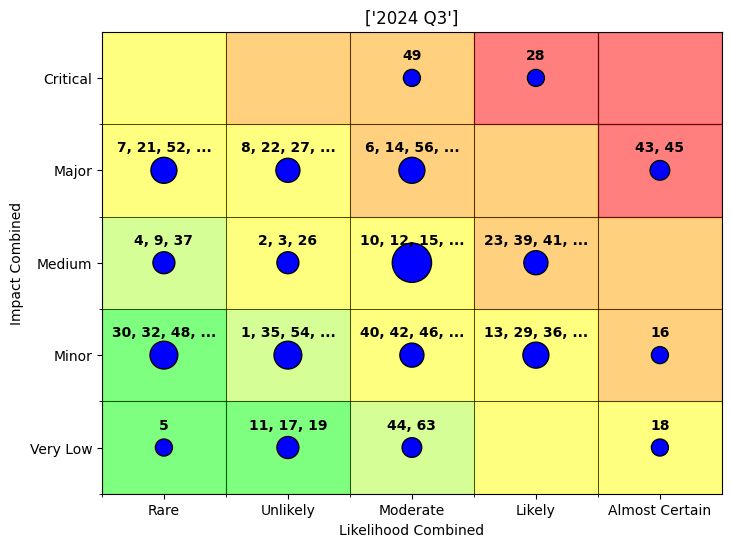

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

def scatterplot_risk_dotsize(df, riskheatmap_name):
    LEGEND_RISK = False
    # Define risk matrix colors
    colors = np.array([
        ["#00FF00", "#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00"],  # Very Low to Critical
        ["#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500"],
        ["#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500", "#FFA500"],
        ["#FFFF00", "#FFFF00", "#FFA500", "#FFA500", "#FF0000"],
        ["#FFFF00", "#FFA500", "#FFA500", "#FF0000", "#FF0000"]
    ])

    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw colored background
    for i in range(5):
        for j in range(5):
            ax.add_patch(plt.Rectangle((j+0.5, i+0.5), 1, 1, color=colors[i, j], alpha=0.5))

    # Labels for axes
    ax.set_xticks(np.arange(5)+1)
    ax.set_xticklabels(["Rare", "Unlikely", "Moderate", "Likely", "Almost Certain"])
    ax.set_yticks(np.arange(5)+1)
    ax.set_yticklabels(["Very Low", "Minor", "Medium", "Major", "Critical"])
    ax.set_xlabel("Likelihood")
    ax.set_ylabel("Impact")

    # Create a new column for the data series label
    df["series"] = df["year"].astype(str) + " Q" + df["quarter"].astype(str)

    # offset so the dots are inside its colorbox
    offset_risk = 0.5 # not needed, shift axes and axes' labels instead
    
    # Assign unique numbers to each risk
    risk_mapping = {risk: idx + 1 for idx, risk in enumerate(df["risk"].unique())}
    df["risk_number"] = df["risk"].map(risk_mapping)

    # Count occurrences of each (x, y) pair
    coord_counts = Counter(zip(df["likelihood_combined"], df["impact_combined"]))

    # Prepare lists for plotting
    plot_data = []
    marker_sizes = []
    labels = []

    # Process each unique (x, y) coordinate
    for (x, y), count in coord_counts.items():
        subset = df[(df["likelihood_combined"] == x) & (df["impact_combined"] == y)]
        risk_numbers = list(subset["risk_number"].unique())  # Unique risk numbers at this (x, y)
        
        # Create label
        if len(risk_numbers) > 3:
            label = ", ".join(map(str, risk_numbers[:3])) + ", ..."  # Show only first 3 + "..."
        else:
            label = ", ".join(map(str, risk_numbers))  # Show all risk numbers
        
        plot_data.append((x, y))
        marker_sizes.append(100 + count * 50)  # Increase marker size with count
        labels.append(label)

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data, columns=["x", "y"])
    plot_df["size"] = marker_sizes
    plot_df["label"] = labels

    # Create the plot
    sns.scatterplot(x=plot_df["x"], y=plot_df["y"], s=plot_df["size"], edgecolor="black", color="blue")

    # Annotate with risk numbers
    for i, row in plot_df.iterrows():
        plt.text(row["x"], row["y"]+0.2, row["label"], fontsize=10, ha="center", fontweight="bold", color="black")

    # Labels and title
    plt.xlabel("Likelihood Combined")
    plt.ylabel("Impact Combined")
    # plt.title("Risk Impact vs Likelihood (Marker Size & Labels)")
    # plt.grid(True)

    # # Add risk number legend
    # legend_text = "\n".join([f"{num} = {risk}" for risk, num in risk_mapping.items()])
    # plt.figtext(0.15, 0.02, legend_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5})

    # Final plot adjustments
    ax.set_xticks(np.arange(5)+0.5, minor=True)
    ax.set_yticks(np.arange(5)+0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    plt.title(df['series'].unique())
    # plt.title("Risk Matrix Over Time")
    # plt.legend(title="Year & Quarter")
    # plt.legend()
    plt.savefig(riskheatmap_name)
    plt.show()
    return df

doc_type = 'plot'
doc_subtype = 'heatmap'
riskheatmap_name = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_plot + '_' + doc_type + '_' + doc_subtype + '.png'
riskheatmap_path = asset_folder + riskheatmap_name

current_company_df_risknumber = scatterplot_risk_dotsize(current_company_df, riskheatmap_path)

#### table by risk numbers

In [76]:
current_company_df_risknumber

import dataframe_image as dfi
from importlib.metadata import version

# print(version('dataframe_image'))

import matplotlib as mpl
import matplotlib.pyplot as plt
# !wget -q https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
mpl.font_manager.fontManager.addfont('./../Sarabun-Regular.ttf')
mpl.rc('font', family='Sarabun')
plt.rcParams ['font.family'] = ('Sarabun')

def table_toprisk(df,name,risk_level):
    # df_top_5 = df.nlargest(3, 'risk_score')
    df = df[df['risk_level']>=risk_level]
    df = df[['risk_number','risk','risk_desc','control_des']]
    df.reset_index(drop=True, inplace=True)
    # Set column width to a higher value
    # pd.set_option('display.max_colwidth', None)
    # pd.set_option('display.max_colwidth', 0)
    pd.set_option('display.max_colwidth', 100)
    df.style.set_properties(**{'max-width': '150px', 'text-overflow': 'ellipsis'})
    display(df)
    dfi.export(df,name,table_conversion='matplotlib')
    return df
# all
# select_row = df6

# table_toprisk(current_company_df_risknumber,"toprisks_3_pcg.png",3)

doc_type = 'table'

doc_subtype = 'allrisks'
tablename = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_plot + '_' + doc_type + '_' + doc_subtype + '.png'
table_path = asset_folder + tablename
table_toprisk(current_company_df_risknumber,table_path,0)

doc_subtype = 'highrisks'
tablename = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_plot + '_' + doc_type + '_' + doc_subtype + '.png'
table_path = asset_folder + tablename
table_toprisk(current_company_df_risknumber,table_path,3)

doc_subtype = 'criticalrisks'
tablename = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_plot + '_' + doc_type + '_' + doc_subtype + '.png'
table_path = asset_folder + tablename
table_toprisk(current_company_df_risknumber,table_path,4)


,risk_number,risk,risk_desc,control_des
0,1,Accounting errors,{การแจ้งรายละเอียดค่าใช้จ่ายที่เกิดขึ้นในคลังมีความคลาดเคลื่อน ส่งผลให้ค่าใช้จ่ายด้านโลจิสติกส์ ...,"{""- Recheck ค่าใช้จ่ายที่เกิดขึ้นจริงกับทางบัญชีแจ้ง -ตรวจสอบร่วมกับกับทางบัญชีและทำการแก้ไข""}"
1,2,Air pollution,{มลพิษทางอากาศที่เกิดจากกระบวนการผลิตที่มีค่าเกินมาตรฐาน ส่งผลกระทบต่อการดำเนินงาน หรือชุมชน},{มีการบำบัดมลพิษทางอากาศก่อนปล่อยออกสู่บรรยากาศ}
2,3,Business interruption from fire hazards,"{เกิดเพลิงไหม้อาคารคลังสินค้า ส่งผลให้อาคารคลังสินค้า รวมถึงสินค้าได้รับความเสียหาย, กระบวนการทำ...","{ติดตั้ง Digitail Termomiter ติดตามอุณหภูมิ และแจ้งเตือน เมื่อพบความร้อนสูง, บริษัทมีการจัดทำแผน..."
3,4,Business interruption from flood,{น้ำท่วมพื้นที่คลังสินค้า หรือบริเวณใกล้เคียง},{จัดเตรียมอุปกรณ์และแผนการรับมือน้ำท่วม โดน monitor จากระดับความสูงแม่น้ำปิง}
4,5,Business interruption from labor dispute,{การหยุดชะงักของธุรกิจจากข้อพิพาทแรงงาน ครอบคลุมถึงการนัดหยุดงาน หรือข้อพิพาทของพนักงาน ที่อาจขั...,{nan}
...,...,...,...,...
66,67,Water scarcity,{ส่งผลกระทบต่อกระบวนการผลิต ไม่สามารถผลิตสินค้าได้},{ดำเนินการจัดหาซัพพลายเออร์}
67,68,Workforce shortage,{จำนวนบุคลากรภายในหน่วยงานไม่เพียงพอต่อกำลังการผลิต (หน่วยงานบรรจุสินค้า หน่วยงานผลิต หน่วยงานคล...,"{ประกาศรับสมัครงานในเพจออนไลน์ ตามคุณสมบัติ ประกาศรับสมัครงานช่องทาง Offline, nan}"
68,69,Wrong delivery,"{กรณีที่ผู้ขายจัดส่งสินค้าไม่ตรงตามใบสั่งซื้อ, สินค้าถูกส่งไปยังผู้รับที่ไม่ถูกต้อง หรือในปริมาณ...","{กำหนดบทลงโทษ 3 ระดับ และปรับปรุงระเบียบข้อบังคับให้ทันสมัยอยู่เสมอ, nan}"
69,70,แบบดายรั่วไหล,{แบบดายถูกเลียนแบบและพัฒนาต่อโดยคู่แข่ง ส่งผลให้กระทบต่อการดำเนินงาน/สูญเสียโอกาสทางธุรกิจ/ยอดขาย},"{กำหนดการเยี่ยมชมโรงงาน supplier ไตรมาสละ 1 ครั้ง โดยจะไปเช็ควิธีการจัดเก็บแบบดาย, ตรวจดูที่เครื..."


,risk_number,risk,risk_desc,control_des
0,6,Business interruption from natural disasters,{การหยุดชะงักของกระบวนการผลิตหรือการดำเนินธุรกิจอันเนื่องมาจากภัยพิบัติทางธรรมชาติ เช่น น้ำท่วม ...,"{กำหนด แผนป้องกันวาตภัย และดำเนินการซักซ้อมแผนการรับมือ หากเกิดสถานการณ์ประจำในทุกปี, nan}"
1,14,Emerging technologies or Innovation product replacing old ones,{มีเทคโนโลยีในการผลิตและนวัตกรรมที่ล้าหลังกว่าคู่แข่ง ส่งผลให้กระทบต่อต้นทุนการดำเนินงาน และ สูญ...,{ทำการศึกษาเทคโนโลยีการผลิตใหม่ที่เหมาะสมกับผลิตภัณฑ์ เช่น อาหารปลาแบบ corn flake ที่ผลิตในประเท...
2,16,Facility infrastructure failure and damage,{ระบบไฟฟ้าขัดข้องทำให้ไม่สามารถตรวจสอบคุณภาพได้วัตถุดิบและอาหารได้ ระบบประปาขัดข้องไม่สามารถใช้น...,{จัดหาผู้ให้บริการเครื่องปั่นไฟฟ้า พร้อมแนวทางติดตั้งเพื่อรองรับเมื่อได้รับแจ้ง หรือทราบข้อมูลจา...
3,23,Human execution errors,{ความผิดพลาดในการปฏิบัติงานของพนักงาน เช่น การตั้งค่าผิดพลาด การใส่วัตถุดิบผิดชนิด หรือการตรวจสอ...,"{nan, การแจ้งให้พนักงานปฎิบัติตามกฎระเบียบ หรือ แนวปฎิบัติ WI อย่างเคร่งครัด โดยผ่านสื่อต่างๆ เช..."
4,28,Intense market competition,{สถานการณ์ที่ธุรกิจต่างๆในอุตสาหกรรมเดียวกันมีการแข่งขันที่รุนแรง ซึ่งอาจส่งผลกระทบต่อกำไรและส่ว...,{ประเมินแผนเดิมและสถานการณ์ปัจจุบันนำข้อมูลมาวิเคราะห์และปรับแผนงานให้สอดคล้องและแข่งขันได้}
5,39,Operational inefficiency,{ระบบการจัดการควบคุมคุณภาพล้มเหลว เช่น แผนการสุ่มตัวอย่างที่ไม่ถูกต้อง ขั้นตอนการทดสอบที่ไม่เหมา...,"{nan, ตรวจเช็คคุณภาพอาหาร ทั้งเรื่องกายภาพ สี Density ทุกๆ 30 นาที, เพื่อให้พนักงานเข้าใจการทำงา..."
6,41,Overstocking inventory,{การผิดพลาดในการวางแผนการจัดเก็บสินค้าให้เหมาะสมกับปริมาณการขาย หรือการจัดเก็บเพื่อรองรับการผลิต...,{นำสถิติการขายสินค้าย้อนหลัง 3 เดือนของแต่ละ SKU เพื่อนำมาเป็นข้อมูลในการตัดสินใจ สต็อคสินค้า SK...
7,43,Poor product quality,{การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเ...,"{nan, ให้พนักงาน หัวหน้างานทวนสอบการทำงานทุกวันเพื่อตรวจสอบความผิดพลาดที่อาจเกิดขึ้น, 1) วิเคราะ..."
8,45,Poor supply quality,{ส่งมอบมาแล้วตรวจสอบพบว่าไม่ได้มาตรฐาน อาจส่งผลต่อ Safety stock ลดลง เสียเวลาในขั้นตอนตรวจสอบ กา...,"{rolling inventory vs order lead time and forecast, เก็บตัวอย่างไปส่องกล้องเพื่อวิเคราะห์ค่าต่าง..."
9,49,Product safety concern,{การปนเปื้อนหรือปัญหาด้านความปลอดภัยของผลิตภัณฑ์ อาจทำให้เกิดการเรียกคืนสินค้า (Recall) ความเสีย...,"{การตรวจสอบวัตถุดิบก่อนนำเข้าสู่กระบวนการผลิต, การจัดการระบบ HACCP (Hazard Analysis and Critical..."


,risk_number,risk,risk_desc,control_des
0,28,Intense market competition,{สถานการณ์ที่ธุรกิจต่างๆในอุตสาหกรรมเดียวกันมีการแข่งขันที่รุนแรง ซึ่งอาจส่งผลกระทบต่อกำไรและส่ว...,{ประเมินแผนเดิมและสถานการณ์ปัจจุบันนำข้อมูลมาวิเคราะห์และปรับแผนงานให้สอดคล้องและแข่งขันได้}
1,43,Poor product quality,{การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเ...,"{nan, ให้พนักงาน หัวหน้างานทวนสอบการทำงานทุกวันเพื่อตรวจสอบความผิดพลาดที่อาจเกิดขึ้น, 1) วิเคราะ..."
2,45,Poor supply quality,{ส่งมอบมาแล้วตรวจสอบพบว่าไม่ได้มาตรฐาน อาจส่งผลต่อ Safety stock ลดลง เสียเวลาในขั้นตอนตรวจสอบ กา...,"{rolling inventory vs order lead time and forecast, เก็บตัวอย่างไปส่องกล้องเพื่อวิเคราะห์ค่าต่าง..."


,risk_number,risk,risk_desc,control_des
0,28,Intense market competition,{สถานการณ์ที่ธุรกิจต่างๆในอุตสาหกรรมเดียวกันมีการแข่งขันที่รุนแรง ซึ่งอาจส่งผลกระทบต่อกำไรและส่ว...,{ประเมินแผนเดิมและสถานการณ์ปัจจุบันนำข้อมูลมาวิเคราะห์และปรับแผนงานให้สอดคล้องและแข่งขันได้}
1,43,Poor product quality,{การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเ...,"{nan, ให้พนักงาน หัวหน้างานทวนสอบการทำงานทุกวันเพื่อตรวจสอบความผิดพลาดที่อาจเกิดขึ้น, 1) วิเคราะ..."
2,45,Poor supply quality,{ส่งมอบมาแล้วตรวจสอบพบว่าไม่ได้มาตรฐาน อาจส่งผลต่อ Safety stock ลดลง เสียเวลาในขั้นตอนตรวจสอบ กา...,"{rolling inventory vs order lead time and forecast, เก็บตัวอย่างไปส่องกล้องเพื่อวิเคราะห์ค่าต่าง..."


In [77]:
# current_company_df_risknumber[current_company_df_risknumber['risk'].str.contains('Fe')] # fertilizer
# current_company_df_risknumber[current_company_df_risknumber['risk'].str.contains('Tech')] # agtech
# current_company_df_risknumber[current_company_df_risknumber['risk'].str.contains('eed')] # seed
# current_company_df_risknumber[current_company_df_risknumber['risk'].str.contains('PP')] # plant protection

### * write report *

#### preview: select company

In [78]:
company_names = df3['company'].unique().tolist()
selected_company = company_names[16:17] # TODO: choose the company you wanna write the report
company = selected_company[0]

display(company_names)
display(company) # selected company


['ALL NOW',
 'Advance AQ',
 'Advance-AHBG',
 'Altervim',
 'Ascend Commerce Group',
 'Ascend Money',
 'CPCRT',
 'CPFC',
 'CPLAND',
 'CPLI',
 'CPMC',
 'CPPC',
 'Chia Tai',
 'ECI',
 'Freewill',
 'KPI/KSP',
 'PCG',
 'SLF',
 'TIDC',
 'Thana Digital Life_Game',
 'Thana Digital Life_True Click Life',
 'True Leasing',
 'True Lifestyle Retail',
 'True Properties',
 'True Space',
 'W&W']

'PCG'

#### preview: select sector

In [79]:
# bu_sector_list = company_details[company_details['BU name']==company]['Business Sector (SET)'].unique().tolist() # based on stakeholder
bu_sector_list_tmp = df3[df3['company']==company]['company_sector'].tolist()
bu_sector_list = list(set.union(*bu_sector_list_tmp))
bu_desc = bu_sector_list[0] # TODO: choose the sector. Currently, only use just the first sector, need to loop this if want all sectors
display(bu_sector_list)

# TODO: need to take care of no bu_desc case

['Agro-Industry and Food']

#### preview: select subset of a company

In [80]:
# company = 'PCG'
# current_company_df = df3[(df3['company']==company)]
current_company_df = df3[(df3['company']==company) & (df3['year']==2024) & (df3['quarter']==3)]
# current_company_df = df3[(df3['risk_level']>= 3) & (df3['company']==company)]
# current_company_df = df3[(df3['risk_level']>= 3) & (df3['company']==company)][['risk','year','quarter','risk_desc','impact_combined','likelihood_combined','risk_score','risk_level']]
current_company_df

,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,risk_level_nonfin,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue
1097,PCG,Accounting errors,2024,3,{การแจ้งรายละเอียดค่าใช้จ่ายที่เกิดขึ้นในคลังมีความคลาดเคลื่อน ส่งผลให้ค่าใช้จ่ายด้านโลจิสติกส์ ...,{False},{Agro-Industry and Food},{Operation},2.0,NaN,...,2.0,{การตรวจสอบข้อผิดพลาดทางบัญชีแบบเรียลไทม์},"{""- Recheck ค่าใช้จ่ายที่เกิดขึ้นจริงกับทางบัญชีแจ้ง -ตรวจสอบร่วมกับกับทางบัญชีและทำการแก้ไข""}",{['ค่าใช้จ่าย บาท/ชิ้น']},{['']},{['ข้อผิดพลาดในการคำนวณ การบันทึกข้อมูล หรือการตัดสินใจผิดพลาดระหว่างกระบวนการทางบัญชี']},{['']},"{['Finance and Accounting', 'Distribution Center (DC)']}","{['', '']}",16579.0
1098,PCG,Air pollution,2024,3,{มลพิษทางอากาศที่เกิดจากกระบวนการผลิตที่มีค่าเกินมาตรฐาน ส่งผลกระทบต่อการดำเนินงาน หรือชุมชน},{False},{Agro-Industry and Food},{Environment},3.0,1.0,...,2.0,{ระบบบำบัดมลพิษทางอากาศ},{มีการบำบัดมลพิษทางอากาศก่อนปล่อยออกสู่บรรยากาศ},{['มาตรฐานการปล่อยมลพิษทางอากาศ ตามที่กฎหมายกำหนด']},{['ค่าการปล่อยไม่เกินค่ามาตรฐานตามกฎหมายกำหนด']},{['ไม่มีการควบคุมและบำบัดก่อนปล่อยสู่บรรยากาศภายนอก']},{['ไม่มีการควบคุมและบำบัดก่อนปล่อยสู่บรรยากาศภายนอก']},"{['Health, Safety, and Environment (HSE)', 'Research and Development', 'Production']}","{['มลพิษทางอากาศที่เกิดจากกระบวนการผลิต', 'หน่วยงานสิ่งแวดล้อมเป็นผู้ดูแลระบบ', 'ค่าความเข้มข้นข...",16579.0
1099,PCG,Business interruption from fire hazards,2024,3,"{เกิดเพลิงไหม้อาคารคลังสินค้า ส่งผลให้อาคารคลังสินค้า รวมถึงสินค้าได้รับความเสียหาย, กระบวนการทำ...",{False},{Agro-Industry and Food},{Operation},3.0,NaN,...,2.0,"{ระบบติดตามและแจ้งเตือน, แผนฉุกเฉินป้องกันและระงับอัคคีภัย}","{ติดตั้ง Digitail Termomiter ติดตามอุณหภูมิ และแจ้งเตือน เมื่อพบความร้อนสูง, บริษัทมีการจัดทำแผน...","{['อุณหภูมิบริเวณ ตู้ MDB , Main circuit breaker'], []}","{['อุณหภูมิบริเวณ ตู้ MDB , Main circuit breaker > 70 องศา'], []}","{['การฝึกอบรมด้านความปลอดภัยสำหรับอัคคีภัยที่ไม่เพียงพอ', 'ขั้นตอนการสื่อสารในภาวะฉุกเฉินที่ไม่ด...","{['', '', ''], ['เช่น พนักงานไม่ได้รับการอบรมดับเพลิงขั้นต้นตามที่กฎหมายกำหนด, ทีมดับเพลิงของบริ...","{['Maintenance', 'Health, Safety, and Environment (HSE)', 'Production', 'Packing', 'Engineering'...","{['', '', '', '', ''], ['']}",16579.0
1100,PCG,Business interruption from flood,2024,3,{น้ำท่วมพื้นที่คลังสินค้า หรือบริเวณใกล้เคียง},{False},{Agro-Industry and Food},{Operation},3.0,3.0,...,1.0,{แผนรับมือน้ำท่วมคลังสินค้าและบริเวณใกล้เคียง},{จัดเตรียมอุปกรณ์และแผนการรับมือน้ำท่วม โดน monitor จากระดับความสูงแม่น้ำปิง},{['ระดับความสูง ของแม่น้ำปิง']},{['ติดตามระดับความสูงของแม่น้ำปิง เพื่อดำเนินการแผนรับมือ']},"{['ขาดความตระหนักถึงความเสี่ยงจากภัยน้ำท่วม', 'การบำรุงรักษาโครงสร้างพื้นฐานเป็นประจำที่ไม่เพียง...","{['', '', '', '', '', '']}",{['Distribution Center (DC)']},{['']},16579.0
1101,PCG,Business interruption from labor dispute,2024,3,{การหยุดชะงักของธุรกิจจากข้อพิพาทแรงงาน ครอบคลุมถึงการนัดหยุดงาน หรือข้อพิพาทของพนักงาน ที่อาจขั...,{False},{Agro-Industry and Food},{Operation},1.0,NaN,...,1.0,{nan},{nan},{[]},{[]},"{['ขาดทักษะในการแก้ไขความขัดแย้ง', 'ขาดการวางแผนความต่อเนื่องทางธุรกิจ', 'ขาดข้อตกลงเกี่ยวกับสภา...","{['', '', '', '', '']}","{['Human Resources', 'Legal', 'Corporate Communication', 'Warehouse']}","{['', '', '', '']}",16579.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,PCG,Water scarcity,2024,3,{ส่งผลกระทบต่อกระบวนการผลิต ไม่สามารถผลิตสินค้าได้},{False},{Agro-Industry and Food},{Environment},3.0,2.0,...,2.0,{ซื้อน้ำจากซัพพลายเออร์},{ดำเนินการจัดหาซัพพลายเออร์},{['ระยะเวลาของการขาดแคลนน้ำ']},{['ไม่เกิน 24 ชั่วโมง']},{['สภาวะภัยแล้งและความแปรปรวนของสภาพภูมิอากาศ']},{['']},{['Production']},{['ไม่สามารถผลิตสินค้าได้']},16579.0
1164,PCG,Workforce shortage,2024,3,{จำนวนบุคลากรภายในหน่วยงานไม่เพียงพอต่อกำลังการผลิต (หน่วยงานบรรจุสินค้า หน่วยงานผลิต หน่วยงานคล...,{False},{Agro-Industry and Food},{Operation},3.0,1.0,...,2.0,"{nan, ประกาศรับสมัครงานใ

#### preview: select risks

In [81]:
# TODO: option to select only some risks to gen
# list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist()
# tmp = df3[(df3['risk_level']>= 3) & (df3['company']=='CPPC')] # high, critical

list_of_risk_desc_tmp = df3[(df3['risk_level']>= 3) & (df3['company']==company) & (df3['year']==2024) & (df3['quarter']==3)].risk_desc.tolist()
list_of_risk_desc = list(set.union(*list_of_risk_desc_tmp))
# selected_risklist = list_of_risk_desc
# selected_risklist = [list_of_risk_desc[2], list_of_risk_desc[3]]
selected_risklist = [list_of_risk_desc[0]]

display(list_of_risk_desc)
display(selected_risklist)

['การปนเปื้อนหรือปัญหาด้านความปลอดภัยของผลิตภัณฑ์ อาจทำให้เกิดการเรียกคืนสินค้า (Recall) ความเสียหายต่อชื่อเสียง และการสูญเสียลูกค้า',
 'การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเสียง และความเสียหายทางธุรกิจ',
 'สินค้าปนเปื้อน เน่าเสีย พบมอดแมลง',
 'กระแสไฟฟ้าดับต่อเนื่องติดต่อกัน ส่งผลให้ไม่สามารถดำเนินงานได้',
 'ส่งมอบมาแล้วตรวจสอบพบว่าไม่ได้มาตรฐาน อาจส่งผลต่อ Safety stock ลดลง เสียเวลาในขั้นตอนตรวจสอบ การตีกลับและต้องจัดหาจัดเตรียมวัตถุดิบที่มีคุณภาพมาส่งใหม่',
 'การจัดหาวัตถุดิบไม่ทันตามกระบวนการผลิต อาจทำให้การผลิตต้องเลื่อนออกไปหรือล่าช้ากว่าปกติ หรือ อาจต้องประสานงานกับทาง RD เพื่อหาวัตถุดิบทดแทน',
 'The unqualified supplier may deliver their low materials quality with the chemical contamination that cannot eliminate the risk by production process.',
 '1. ขาดการสื่อสาร และการอบรมการปฏิบัติงานเฉพาะที่จำเป็นสำหรับการทำงาน ด้าน Functional skill 2. พนักงานอาุยน้อย และอายุงานน้อย ขาดประสบการณ์ 3. มาตรฐานการทำงานไม่ชัดเจน',
 'กระบว

['การปนเปื้อนหรือปัญหาด้านความปลอดภัยของผลิตภัณฑ์ อาจทำให้เกิดการเรียกคืนสินค้า (Recall) ความเสียหายต่อชื่อเสียง และการสูญเสียลูกค้า']

#### *select df for report gen

In [82]:
# loop until have at least 3 risks but only high/critical risks
selected_company_report = 'PCG' # Chia Tai
selected_year = 2024
selected_quarter = 3

df_for_report_gen = df3[(df3['risk_level']>= 4) & (df3['company']==selected_company_report) & (df3['year']==selected_year) & (df3['quarter']==selected_quarter)]
if len(df_for_report_gen) < 3:
    df_for_report_gen = df3[(df3['risk_level']>= 3) & (df3['company']==selected_company_report) & (df3['year']==selected_year) & (df3['quarter']==selected_quarter)]

product_list = str(stakeholder_product[stakeholder_product['BU name']==selected_company_report]['Description'].tolist())
product_list

df_for_report_gen['company_product'] = product_list

# TODO: change this, for debug use only first risk to gen
# df_for_report_gen = df_for_report_gen.iloc[0:2,:]
df_for_report_gen
# display(df_for_report_gen['risk_desc'][0])
# display(df_for_report_gen['risk_desc'].tolist())

/var/folders/08/7pzsbdnx74z7t2ykrb_hk6pw0000gn/T/ipykernel_14595/3800701100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_report_gen['company_product'] = product_list


,company,risk,year,quarter,risk_desc,iscustom,company_sector,risk_subcat,impact_combined,impact_fin_combined,...,control_name,control_des,KRI_name,KRI_desc,rootcause,rootcause_desc,process,process_desc,est_revenue,company_product
1124,PCG,Intense market competition,2024,3,{สถานการณ์ที่ธุรกิจต่างๆในอุตสาหกรรมเดียวกันมีการแข่งขันที่รุนแรง ซึ่งอาจส่งผลกระทบต่อกำไรและส่ว...,{False},{Agro-Industry and Food},{Competitor},5.0,5.0,...,{ปรับแผนกลยุทธ์และการตลาด},{ประเมินแผนเดิมและสถานการณ์ปัจจุบันนำข้อมูลมาวิเคราะห์และปรับแผนงานให้สอดคล้องและแข่งขันได้},"{['ยอดขาย', 'ยอดขาย']}","{['ยอดขายเทียบเป้าหมายการขาย', 'อัตราการเติบโตเทียบกับปีก่อน']}","{['จำนวนคู่แข่งในตลาดมีจำนวนมาก', 'กลยุทธ์ด้านราคาที่มีการแข่งขันสูง']}","{['ธุรกิจอาหารสัตว์เลี้ยงเติบโตมากอย่างต่อเนื่องทำให้ผู้ผลิตอาหารอื่นๆเข้ามาในตลาดนี้มากขึ้น', '...","{['Finance and Accounting', 'Information Technology (IT)', 'Procurement', 'Research and Developm...","{['พัฒนาสินค้าที่มีคุณภาพและแข่งขันได้', 'การบริการหลังการขายเพื่อสร้างความพอใจให้ลูกค้า', 'เก็บ...",16579.0,"['pet foods', 'pet accessories (shampoo, cat sand, etc.)']"
1139,PCG,Poor product quality,2024,3,{การผลิตสินค้าที่ไม่ได้มาตรฐานคุณภาพ อาจทำให้เกิดการร้องเรียนจากลูกค้า การคืนสินค้า การเสียชื่อเ...,{False},{Agro-Industry and Food},{Operation},4.0,1.0,...,"{ตรวจเช็คเครื่องจักรก่อนการเดินเครื่อง, การพัฒนาความสามารถของผู้ปฏิบัติงานตาม Skill matrix, nan,...","{nan, ให้พนักงาน หัวหน้างานทวนสอบการทำงานทุกวันเพื่อตรวจสอบความผิดพลาดที่อาจเกิดขึ้น, 1) วิเคราะ...","{['- อัตราสินค้าถูกคืน (% Return Rate) - จำนวนข้อร้องเรียนจากลูกค้า'], ['Customer Complain'], ['...","{[""'- วัตถุดิบที่ไม่ได้คุณภาพตั้งแต่ต้นทาง - การตั้งค่าหรือปรับเครื่องจักรไม่เหมาะสม - กระบวนการ...","{['ปัญหาข้อผิดพลาดหรือความผิดปกติที่เกิดขึ้นระหว่างกระบวนการผลิต', 'ความผิดพลาด การกํากับดูแล หร...","{['', ''], [''], ['การตั้งค่าหรือปรับเครื่องจักรไม่เหมาะสม', 'วัตถุดิบที่ไม่ได้คุณภาพตั้งแต่ต้นท...","{['Planning', 'Production', 'Packing'], ['Production', 'Quality Assurance', 'Other'], ['Producti...","{['รับข้อร้องเรียน', 'ต้องคัดแยกสินค้าไม่ได้มาตรฐานโอนย้ายเพื่อดำเนินการ', 'กรณีเป็นปัญหาด้านคุณ...",16579.0,"['pet foods', 'pet accessories (shampoo, cat sand, etc.)']"
1141,PCG,Poor supply quality,2024,3,{ส่งมอบมาแล้วตรวจสอบพบว่าไม่ได้มาตรฐาน อาจส่งผลต่อ Safety stock ลดลง เสียเวลาในขั้นตอนตรวจสอบ กา...,{False},{Agro-Industry and Food},{Operation},4.0,1.0,...,"{การตรวจสอบคุณภาพวัตถุดิบก่อนนำเข้า, Inventory control, nan, มาตรการตรวจสอบคุณภาพ, การควบคุมคุณภ...","{rolling inventory vs order lead time and forecast, เก็บตัวอย่างไปส่องกล้องเพื่อวิเคราะห์ค่าต่าง...","{['อัตราการปฏิเสธวัตถุดิบ (%)'], ['Short safety stock'], []}","{['วัตถุดิบไม่ได้คุณภาพ (Poor Quality Raw Materials)'], ['จำนวน stock น้อยกว่าค่า safety ที่ตั้ง...","{['กระบวนการควบคุมคุณภาพไม่เพียงพอ', 'การคัดเลือกซัพพลายเออร์โดยพิจารณาจากต้นทุนเพียงอย่างเดียว ...","{['', '', '', ''], ['', '', 'การเก็บรักษาวัตถุดิบที่ไม่เหมาะสม'], ['', ''], ['supplier อาจกำหนดค...","{['Procurement', 'Quality Assurance'], ['Other'], ['Procurement', 'Planning', 'Quality Assurance...","{['', '', 'หน่วยงานตรวจวัตถุดิบควบคุมคุณภาพ ตรวจก่อนเก็บเข้าคลัง', ''], ['แจ้งส่งกลับไม่รับวัตถุ...",16579.0,"['pet foods', 'pet accessories (shampoo, cat sand, etc.)']"


#### any: risk, +control, +opportunity 

In [83]:
import os

def get_unique_filename(filename):
    # Split the filename into name and extension
    name, ext = os.path.splitext(filename)
    counter = 1

    # Loop to check if the file exists and increment the counter
    while os.path.exists(filename):
        filename = f"{name}_{counter:02d}{ext}"
        counter += 1

    return filename


In [ ]:
import json

#  TODO: config these
REPORT_OUTPUTTYPE = 'ppt' # doc
WRITE_RISK_REPORT = 'RISKCONTROLOPP_MULTI_SPLIT' # 'RISK_MULTI' 'RISKCONTROL_MULTI_SPLIT' 'RISKCONTROLOPP_MULTI_SPLIT'
DATASOURCE = 'RMI' # 'RMI' '56'
AUTOGEN = True # true if wanna gen the necessary files automatically

# TODO: add option to select LLM vendor here, and pass to the function

# company_names = rmi_data_ops['company'].unique().tolist()
# selected_company = company_names[10:11] # TODO: choose the company you wanna write the report
# company = selected_company[0]

# # bu_sector_list = company_details[company_details['BU name']==company]['Business Sector (SET)'].unique().tolist() # based on stakeholder
# bu_sector_list = rmi_data_ops[rmi_data_ops['company']==company]['company_sector'].unique().tolist() # based on RMI, TODO: need to make sure it's compatible with 56-1 data
# bu_desc = bu_sector_list[0] # TODO: choose the sector. Currently, only use just the first sector, need to loop this if want all sectors
# # TODO: need to take care of no bu_desc case

# # TODO: option to select only some risks to gen
# list_of_risk_desc = rmi_data_ops[rmi_data_ops['company']==company].risk_desc.unique().tolist()
# selected_risklist = list_of_risk_desc[0:1]

# display(company_names)
# display(company) # selected company
# display(bu_sector_list)
# display(list_of_risk_desc)
# display(selected_risklist) # selected risks, only applied to RMI (not 56-1 yet)

company_ = company.replace(' ','_')
bu_desc_ = bu_desc.replace(' ','_') 


# report_dir = external_data_folder + 'report_json/'
report_json_folder = external_data_folder + 'report_json/'
input_file = report_json_folder + str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_report + '_json_riskcontrol.json'
summary_file = report_json_folder + str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_report + '_json_summary.json'
opportunity_file = report_json_folder + str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_report + '_json_opportunity.json'

# report_dir = './output/report_json/'
# input_file = report_dir + 'riskcontrol_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
# summary_file = report_dir + 'summary_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
# opportunity_file = report_dir + 'opportunity_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'

# # load data
# input_file = './output/report_json/data.json' 
# # summary_file = './output/report_json/data.json' 
# summary_file = './output/report_json/summary_gen_from_rmi_BU-Freewill_Solution_SEC-Information_&_Communication_Technology.json'
# opportunity_file = './output/report_json/opportunity_gen_from_rmi_BU-Freewill_Solution_SEC-Information_&_Communication_Technology.json'

estimate_cost.total_cost_THB = 0 # initialization

# ===================================================================================
# check if the appropriate files exist
# TODO: need to check if the file is empty as well (i.e., only has [])
import os.path
if WRITE_RISK_REPORT == 'RISK_MULTI' or WRITE_RISK_REPORT == 'RISKCONTROL_MULTI_SPLIT': # risk-only, risk+control 
    if (not os.path.isfile(input_file)):
        print('need to gen risk data')
    if (not os.path.isfile(summary_file)):
        print('need to gen summary data')
if WRITE_RISK_REPORT == 'RISKCONTROLOPP_MULTI_SPLIT': # risk+control+opportunity
    if (not os.path.isfile(input_file)):
        print('need to gen risk data')
        if AUTOGEN:
            # gen_data('riskcontrol', DATASOURCE, company, bu_desc, selected_risklist)
            gen_data_v2('riskcontrol', DATASOURCE, company, bu_desc, df_for_report_gen, input_file)
            print('cumulative cost THB: '+ str(estimate_cost.total_cost_THB))
    if (not os.path.isfile(summary_file)):
        print('need to gen summary data')
        if AUTOGEN:
            # gen_data('summary', DATASOURCE, company, bu_desc, selected_risklist)
            gen_data_v2('summary', DATASOURCE, company, bu_desc, df_for_report_gen, summary_file)
            print('cumulative cost THB: '+ str(estimate_cost.total_cost_THB))
    if (not os.path.isfile(opportunity_file)):
        print('need to gen opportunity data')
        if AUTOGEN:
            # gen_data('opportunity', DATASOURCE, company, bu_desc, selected_risklist)
            gen_data_v2('opportunity', DATASOURCE, company, bu_desc, df_for_report_gen, opportunity_file)
            print('cumulative cost THB: '+ str(estimate_cost.total_cost_THB))

# ===================================================================================
# TODO: if there's only one risk, summary_file can be the same file as the input_file
if REPORT_OUTPUTTYPE == 'doc':
    with open(input_file) as f:
        data = json.load(f)

    with open(summary_file) as f:
        summary_data = json.load(f)

    with open(opportunity_file) as f:
        opportunity_data = json.load(f)

    # output_file_init = WRITE_RISK_REPORT + '_' + DATASOURCE + '_' + company_ + '_' + bu_desc_ + '.docx'
    output_file_init = report_folder + 'doc/'+ WRITE_RISK_REPORT + '_' + DATASOURCE + '_' + company_ + '_' + bu_desc_ + '.docx'
    output_file = get_unique_filename(output_file_init) # if filename already exists, increment number at the end
    print(output_file)
    # ================ RISK-ONLY REPORT ================
    if WRITE_RISK_REPORT == 'RISK_SINGLE':
        report_json = data[0] # only try the first one, may have multiples
        # output_file = "Risk_Assessment_Report_riskonly_v11.docx"
        json_to_word_riskonly_v1(report_json, output_file) # likely won't be using this anymore since MULTI would work

    if WRITE_RISK_REPORT == 'RISK_MULTI':
        # output_file = "Risk_Assessment_Report_multi_riskonly_v12.docx"
        # json_to_word_multi_riskonly_v1(data, output_file)
        json_to_word_multi_riskonly_v1(data, output_file, summary = summary_data)

    # ================ RISK+CONTROL REPORT ================
    if WRITE_RISK_REPORT == 'RISKCONTROL_SINGLE': # SINGLE_RISK
        report_json = data[0]
        # output_file = "Risk_Assessment_Report_v4.docx"
        json_to_word_single(report_json, output_file) # likely won't be using this anymore since MULTI would work

    if WRITE_RISK_REPORT == 'RISKCONTROL_MULTI': # MULTI_RISK_01
        # output_file = "Risk_Assessment_Report_multi_v2-only1risk.docx"
        json_to_word_multi(report_json, output_file)

    if WRITE_RISK_REPORT == 'RISKCONTROL_MULTI_SPLIT':
        # output_file = "Risk_Assessment_Report_multi_split03_v3_34.docx"
        # json_to_word_multi_split_03(data, output_file) # not using summary json file
        json_to_word_multi_split_03(data, output_file, summary = summary_data)

    # ================ RISK+CONTROL+OPPORTUNITY REPORT ================
    if WRITE_RISK_REPORT == 'RISKCONTROLOPP_MULTI_SPLIT':
        # output_file = "RiskOpp_Assessment_Report_multi_split03_v3_44.docx"
        # output_file = WRITE_RISK_REPORT + '_' + DATASOURCE + '_' + company_ + '_' + bu_desc_ + '.docx'
        json_to_word_multi_split_03(data, output_file, summary = summary_data, opportunity = opportunity_data)

need to gen risk data
risk_desc: {'สถานการณ์ที่ธุรกิจต่างๆในอุตสาหกรรมเดียวกันมีการแข่งขันที่รุนแรง ซึ่งอาจส่งผลกระทบต่อกำไรและส่วนแบ่งตลาด'}, bu desc: Agro-Industry and Food
success
risk_analysis=RiskAssessment(risk_identification=RiskIdentification(identified_risk=IdentifiedRisk(risk_description='The company faces three primary risks for its line of pet foods and accessories: (1) Intense market competition, (2) Poor product quality, and (3) Poor supply quality.'), risk_sources=['Competitors launching similar products or promotional campaigns', 'Lack of effective quality controls or process deviation', 'Supplier inconsistencies, inferior inputs or supply chain disruptions'], risk_categories=[RiskCategory(risk_category_name='Market & Strategic Risk', rationale='Market competition can impact sales, margin, and brand position.'), RiskCategory(risk_category_name='Operational Risk', rationale='Quality and supply issues can disrupt business operations, lead to customer dissatisfaction, and 

In [85]:
# data[1]
# report_json['executive_summary']
# report_json['risks'][0]['risk_identification']['risk_sources']
# report_json['risks'][0]['risk_identification']['risk_categories']
# report_json['risks'][0]['detailed_risk_analysis']['potential_scenarios']
# report_json['risks'][0]['detailed_risk_analysis']['followup_questions']
# response.__dict__

### historical trace plot

#### linestyle for plot

In [86]:
# reference risk matrix color
colors = np.array([
    ["#00FF00", "#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00"],  # Very Low to Critical
    ["#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500"],
    ["#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500", "#FFA500"],
    ["#FFFF00", "#FFFF00", "#FFA500", "#FFA500", "#FF0000"],
    ["#FFFF00", "#FFA500", "#FFA500", "#FF0000", "#FF0000"]
])

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 5))),
     ('densely dotted',        (0, (1, 1))),

     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

linestyle_dict = dict(linestyle_tuple)
linestyle_dict['dashed']

(0, (5, 5))

#### historical trace, use init values from df_for_report_gen

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define risk matrix colors
colors = np.array([
    ["#00FF00", "#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00"],  # Very Low to Critical
    ["#00FF00", "#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500"],
    ["#ADFF2F", "#FFFF00", "#FFFF00", "#FFA500", "#FFA500"],
    ["#FFFF00", "#FFFF00", "#FFA500", "#FFA500", "#FF0000"],
    ["#FFFF00", "#FFA500", "#FFA500", "#FF0000", "#FF0000"]
])

def historical_trace(points, filename):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw colored background
    for i in range(5):
        for j in range(5):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i, j], alpha=0.5))

    # Labels for axes
    ax.set_xticks(np.arange(5) + 0.5)
    ax.set_xticklabels(["Rare", "Unlikely", "Moderate", "Likely", "Almost Certain"])
    ax.set_yticks(np.arange(5) + 0.5)
    ax.set_yticklabels(["Very Low", "Minor", "Medium", "Major", "Critical"])
    ax.set_xlabel("Likelihood")
    ax.set_ylabel("Impact")

    # Risk movement data points
    # points = {
    #     "Q1/2022": (3, 4),  # (Likelihood, Impact)
    #     "Q2/2022": (2, 4),
    #     "Q4/2022": (2, 3),
    #     "Q2/2023": (1, 1),
    # }

    offset = 0.5
    points = {k: (v[0] - offset, v[1] - offset) for k, v in points.items()}

    # Extract coordinates and plot points
    coords = list(points.values())
    x_vals, y_vals = zip(*coords)

    ax.plot(x_vals, y_vals, 'o', color='black', markersize=7, linewidth=1, label="Risk Movement")  # Thinner line

    # Annotate each point with its label
    # for label, (x, y) in points.items():
    #     ax.annotate(label, (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

    # Group labels by (x, y) position
    position_groups = defaultdict(list)
    for label, pos in points.items():
        position_groups[pos].append(label)

    # if more than one point has the same value, stagger the label name
    # Annotate labels with vertical staggering
    for (x, y), labels in position_groups.items():
        for i, label in enumerate(labels):
            offset = 10 * i  # 10 pixels per stagger step
            ax.annotate(label, (x, y), textcoords="offset points", xytext=(5, offset), ha='left')


    # Add arrows to indicate movement
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        
        ax.annotate("",
                    xy=(x2, y2), xycoords='data',
                    xytext=(x1, y1), textcoords='data',
                    arrowprops=dict(arrowstyle="->", linestyle=linestyle_dict['dashed'], color='black', lw=3))  # Thinner arrow line

    # extract risk name
    start = filename.rfind('_') + 1
    end = filename.rfind('.png')
    risk_name = filename[start:end]

    # Final plot adjustments
    ax.set_xticks(np.arange(5), minor=True)
    ax.set_yticks(np.arange(5), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    # plt.title("Risk Matrix Over Time")
    plt.title(risk_name)
    # plt.legend()
    plt.savefig(filename)
    plt.show()
    


In [89]:
DEBUG = False
if DEBUG:
    points = {
            "2022 Q1": (3, 4),  # (Likelihood, Impact)
            "2022 Q2": (2, 4),
            "2022 Q4": (2, 3),
            "2023 Q2": (1, 1),
        }

    doc_type = 'plothistorical'
    doc_subtype = 'riskid' # + str(risk_ind)
    historicalmap_name = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_plot + '_' + doc_type + '_' + doc_subtype + '.png'
    historicalmap_path = asset_folder + historicalmap_name

    historical_trace(points, historicalmap_path)

#### loop all 'critical' risks

In [90]:
risk_to_gen_traceplot = df_for_report_gen['risk'].unique().tolist()
risk_to_gen_traceplot

['Intense market competition', 'Poor product quality', 'Poor supply quality']

In [91]:
def gen_historical_trace_multi(df_for_report_gen): # assume single year, quarter, and company
    selected_year = df_for_report_gen['year'].iloc[0]
    selected_quarter = df_for_report_gen['quarter'].iloc[0]
    selected_company_report = df_for_report_gen['company'].iloc[0]

    # selected_company_report = 'Chia Tai' # only used for debug

    # need to use the whole dataset (i.e. multi-quarters data) in order to gen trace
    # Convert year and quarter into a single period number (e.g., 2024 Q3 = 2024*4 + 3 = 8099)
    df3['period'] = df3['year'] * 4 + df3['quarter']
    target_period = selected_year * 4 + selected_quarter

    # Define range of 5 quarters
    cutoff = target_period - 4  # 5 quarters including the current one

    # Filter rows
    result = df3[(df3['period'] <= target_period) & (df3['period'] >= cutoff) & (df3['company']==selected_company_report)]

    # Drop helper column if you want
    result = result.drop(columns='period')

    # display(result)

    # Group by (year, quarter) and get max likelihood and impact
    grouped = result.groupby(['year', 'quarter','risk']).agg({
        'likelihood_combined': 'max',
        'impact_combined': 'max'
    }).reset_index()

    # select only a risk
    # display(grouped)
    risk_to_gen_traceplot = df_for_report_gen['risk'].unique().tolist()

    for risk_to_trace in risk_to_gen_traceplot:
        # TODO: change the risk name to whatever you're trying to plot
        # have to extract what the critical risks are for the given quarter/year
        # single_risk = grouped[grouped['risk']=='Seed Supply ไม่ได้ตามแผน (Seed)']
        single_risk = grouped[grouped['risk']==risk_to_trace]
        display(single_risk)

        # Create the points dictionary
        points = {
            f"{row['year']} Q{row['quarter']}": (row['likelihood_combined'], row['impact_combined'])
            for _, row in single_risk.iterrows()
        }

        # print(points)

        doc_type = 'plothistorical'
        doc_subtype = risk_to_trace # 'riskid' # + str(risk_ind)
        historicalmap_name = str(selected_year) + '_Q' + str(selected_quarter) + '_' + selected_company_report + '_' + doc_type + '_' + doc_subtype + '.png'
        historicalmap_path = asset_folder + historicalmap_name

        historical_trace(points, historicalmap_path)

,year,quarter,risk,likelihood_combined,impact_combined
27,2024,3,Intense market competition,4.0,5.0


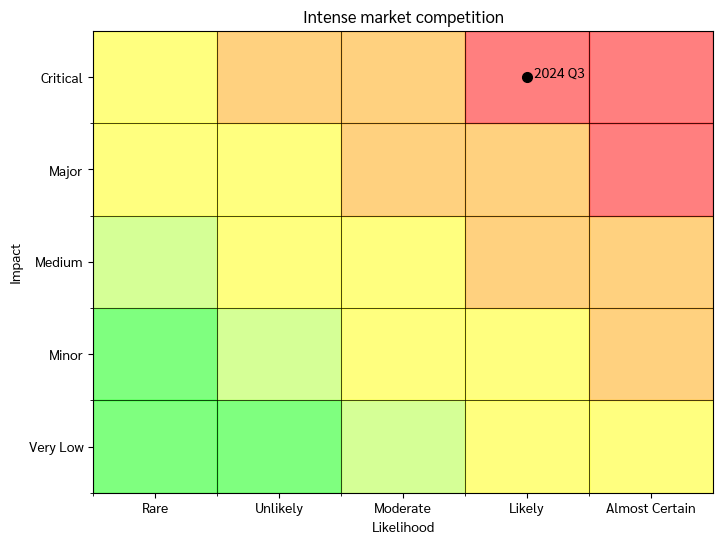

,year,quarter,risk,likelihood_combined,impact_combined
42,2024,3,Poor product quality,5.0,4.0


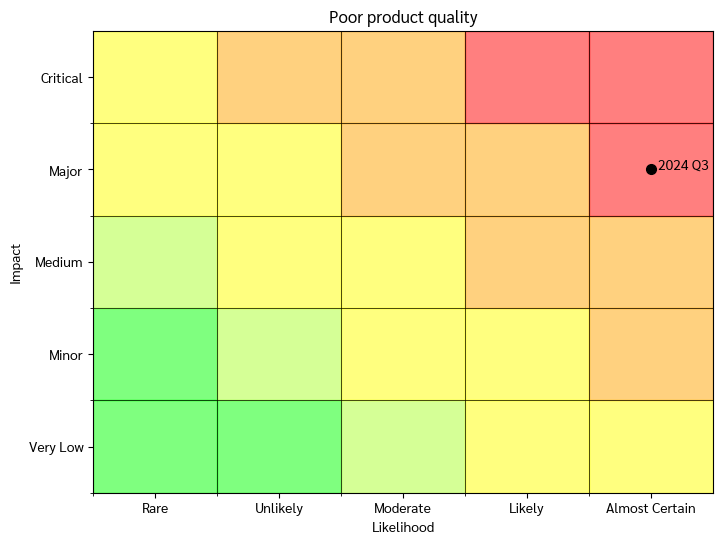

,year,quarter,risk,likelihood_combined,impact_combined
44,2024,3,Poor supply quality,5.0,4.0


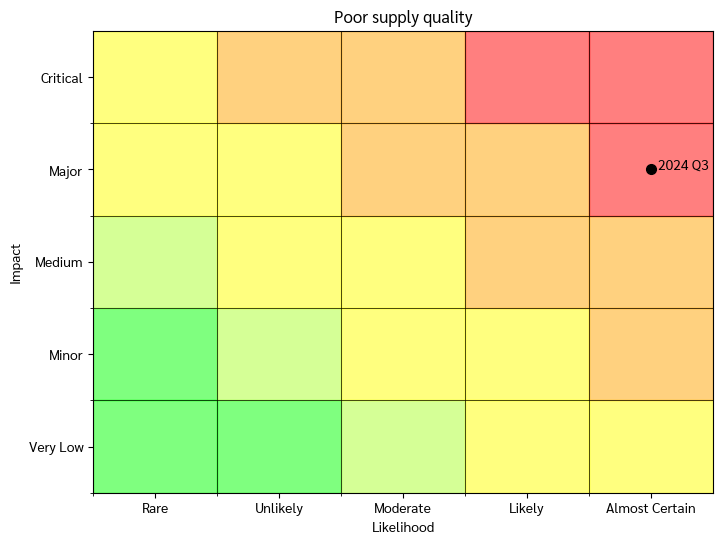

In [92]:
gen_historical_trace_multi(df_for_report_gen)

## Translate json to other languages

In [94]:
input_file

'./external/report_json/2024_Q3_PCG_json_riskcontrol.json'

In [ ]:
# def translate_text(text, translator):
#     # Detect if the text is not empty
#     if text:
#         result = translator.translate(text, dest='th')
#         return result.text
#     return text

def translate_text(text: str, target_language: str) -> str:
    """
    Translates the given text into the target language using OpenAI's API.
    
    Parameters:
        text (str): The text to translate.
        target_language (str): The language to translate into (e.g., 'French', 'Spanish').
        api_key (str): OpenAI API key.
    
    Returns:
        str: Translated text.
    """
    
    prompt = f"Translate the following text into {target_language}:\n\n{text}"
    model="gpt-4o-mini"
    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a professional translator."},
            {"role": "user", "content": prompt}
        ]
    )

    estimate_cost(res_usage=response.usage, model=model, type = 'single',showcost=False)
    # estimate_cost(res_usage=response.usage, model=model)
    
    return response.choices[0].message.content.strip()

# translated = translate_text('test', 'Thai')
# display(translated)

### TODO: convert this into a function
handle
- multiple file types (riskcontrol, summary, opportunity)
- filename
- different languages

In [ ]:
import json
import copy
import os
# from googletrans import Translator  # pip install googletrans==4.0.0-rc1

# Load original JSON
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Clone data
cloned_data = copy.deepcopy(data)

# Set up translator
# translator = Translator()

# Customize this
target_lang = 'Thai'
exact_paths_to_translate = [
    ('product', 'name'),  # only this exact path will be translated
]
subtree_keys_to_translate = ['risk_analysis','risk_mitigation_action_plan','slide_title']  # entire subtree under these keys will be translated

def should_translate_path(current_path):
    return current_path in exact_paths_to_translate

def should_translate_subtree(current_path):
    return any(k in current_path for k in subtree_keys_to_translate)

# def translate_deep(obj, path=(), inside_subtree=False):
#     if isinstance(obj, dict):
#         for key in obj:
#             new_path = path + (key,)
#             value = obj[key]

#             in_subtree = inside_subtree or key in subtree_keys_to_translate
#             if isinstance(value, str):
#                 if should_translate_path(new_path) or in_subtree:
#                     # translated = translate_text(value, target_lang)
#                     translated = translate_text(value, target_lang)
#                     obj[key] = translated
#             else:
#                 translate_deep(value, new_path, inside_subtree=in_subtree)
#     elif isinstance(obj, list):
#         for i, item in enumerate(obj):
#             translate_deep(item, path + (str(i),), inside_subtree=inside_subtree)

def translate_deep(obj, path=(), inside_subtree=False):
    if isinstance(obj, dict):
        for key in obj:
            new_path = path + (key,)
            value = obj[key]

            in_subtree = inside_subtree or key in subtree_keys_to_translate
            if isinstance(value, str):
                if should_translate_path(new_path) or in_subtree:
                    obj[key] = translate_text(value, target_lang)
            else:
                translate_deep(value, new_path, inside_subtree=in_subtree)

    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            item_path = path + (str(i),)
            if isinstance(item, str):
                # Translate list of strings directly
                if should_translate_path(path) or inside_subtree:
                    obj[i] = translate_text(item, target_lang)
            else:
                translate_deep(item, item_path, inside_subtree=inside_subtree)


estimate_cost.total_cost_THB = 0 # initialization cost tracking

# Perform translation
translate_deep(cloned_data)

display('total_cost_THB: '+ str(estimate_cost.total_cost_THB))

original_path = input_file

# Split into directory, filename, and extension
directory = os.path.dirname(original_path)
filename, extension = os.path.splitext(os.path.basename(original_path))

# Create new filename with 'th' appended before the extension
new_filename = filename + target_lang + extension

# Join to form the new filepath
new_path = os.path.join(directory, new_filename)

# Save to new file
with open(new_path, 'w', encoding='utf-8') as f:
    json.dump(cloned_data, f, ensure_ascii=False, indent=4)


single call cost (THB): 0.0016904999999999997
single call cost (THB): 0.0006509999999999999
single call cost (THB): 0.00076125
single call cost (THB): 0.0009555
single call cost (THB): 0.000399
single call cost (THB): 0.000777
single call cost (THB): 0.0003465
single call cost (THB): 0.00127575
single call cost (THB): 0.000315
single call cost (THB): 0.0009502499999999998
single call cost (THB): 0.00207375
single call cost (THB): 0.0010237500000000001
single call cost (THB): 0.00104475
single call cost (THB): 0.0009502499999999999
single call cost (THB): 0.00037275
single call cost (THB): 0.000357
single call cost (THB): 0.0005197499999999999
single call cost (THB): 0.0010762500000000002
single call cost (THB): 0.0013545
single call cost (THB): 0.00033075
single call cost (THB): 0.0002625
single call cost (THB): 0.0004935
single call cost (THB): 0.001197
single call cost (THB): 0.0009502499999999998
single call cost (THB): 0.00043575000000000005
single call cost (THB): 0.00044625000000

'total_cost_THB: 0.14749874999999996'

## debug

In [ ]:
import json

if DEBUG:
    WRITE_RISK_REPORT = 'RISK_MULTI' # 'RISK_MULTI' 'RISKCONTROL_MULTI_SPLIT' 'RISKCONTROLOPP_MULTI_SPLIT'
    DATASOURCE = 'rmi' # 'rmi' '56'

    company_names = rmi_data_ops['company'].unique().tolist()
    selected_company = company_names[0:1]

    company = selected_company[0]
    bu_sector_list = company_details[company_details['BU name']==company]['Business Sector (SET)'].unique().tolist()

    company_ = 'Freewill Solution'.replace(' ','_')
    bu_desc_ = bu_sector_list[0].replace(' ','_') 

    input_file = './output/report_json/riskcontrol_gen_from_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
    summary_file = './output/report_json/summary_gen_from_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'
    opportunity_file = './output/report_json/opportunity_gen_from_'+ DATASOURCE +'_BU-' + company_ + '_SEC-' + bu_desc_ + '.json'

    print(input_file)
    print(summary_file)
    print(opportunity_file)


IndexError: list index out of range

# dash cytoscape network graph

In [161]:
# import dash
# from dash import html
# import dash_cytoscape as cyto

# # Define risk nodes
# nodes_data = {
#     "Inequality": {"size": 80, "category": "Societal"},
#     "Economic downturn": {"size": 60, "category": "Economic"},
#     "Involuntary migration": {"size": 55, "category": "Societal"},
#     "Misinformation": {"size": 50, "category": "Technological"},
#     "Extreme weather events": {"size": 45, "category": "Environmental"},
#     "Cyber warfare": {"size": 42, "category": "Technological"},
# }

# # Define edges (source, target, weight)
# edges_data = [
#     ("Inequality", "Economic downturn", 3),
#     ("Inequality", "Involuntary migration", 2),
#     ("Misinformation", "Cyber warfare", 3),
#     ("Extreme weather events", "Involuntary migration", 2),
#     ("Inequality", "Misinformation", 1),
# ]

# # Color mapping
# category_colors = {
#     "Economic": "#1f77b4",
#     "Environmental": "#2ca02c",
#     "Geopolitical": "#ff7f0e",
#     "Societal": "#d62728",
#     "Technological": "#9467bd",
# }

# # Create Cytoscape elements
# elements = []

# # Nodes
# for id, data in nodes_data.items():
#     elements.append({
#         'data': {'id': id, 'label': id},
#         'classes': data['category'],
#         'style': {
#             'width': data['size'],
#             'height': data['size'],
#             'background-color': category_colors[data['category']],
#             'label': id,
#             'font-size': '10px',
#             'color': '#fff',
#             'text-valign': 'center',
#             'text-halign': 'center',
#         }
#     })

# # Edges
# for source, target, weight in edges_data:
#     elements.append({
#         'data': {'source': source, 'target': target},
#         'style': {
#             'width': weight * 2,
#             'line-color': '#888'
#         }
#     })

# # Initialize Dash app
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H2("Global Risk Network", style={"textAlign": "center"}),
#     cyto.Cytoscape(
#         id='cytoscape-network',
#         layout={'name': 'cose'},  # Force-directed layout
#         style={'width': '100%', 'height': '700px'},
#         elements=elements,
#         stylesheet=[
#             {
#                 'selector': 'node',
#                 'style': {
#                     'label': 'data(label)',
#                     'text-wrap': 'wrap',
#                     'text-max-width': 80
#                 }
#             },
#             {
#                 'selector': ':selected',
#                 'style': {
#                     'border-width': 2,
#                     'border-color': 'black'
#                 }
#             }
#         ]
#     )
# ])

# if __name__ == '__main__':
#     app.run(debug=True)


In [ ]:
print(os.getenv("OPENAI_API_KEY"))